In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
from sklearn.model_selection import KFold
# from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import xgboost as xgb
from collections import Counter
from sklearn.metrics import confusion_matrix
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm

**Reference**
https://blog.csdn.net/zwqjoy/article/details/109311133

# load data

In [3]:
def load_data():
    df_train = pd.read_csv(f'./data/training.csv',index_col='id')
    df_test = pd.read_csv(f'./data/test.csv',index_col='id')

    return df_train, df_test

In [4]:
df_train, df_test = load_data()

In [5]:
df_train

,event,var1,var2,var3,var4,var5,var6,var7,var8,split
id,,,,,,,,,,
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev
3,1,1.0,2.096510e+07,NaN,NaN,NaN,NaN,NaN,62.750000,dev
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev
...,...,...,...,...,...,...,...,...,...,...
238831,1,1.0,6.523118e+04,NaN,NaN,NaN,NaN,NaN,58.916667,dev
238832,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev
238833,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev


In [6]:
df_test

,event,var1,var2,var3,var4,var5,var6,var7,var8,split
id,,,,,,,,,,
0,1,1.0,9.248254e+07,0.908051,13.0,0.133592,0.027241,NaN,73.041667,test
1,1,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,test
2,1,1.0,6.718715e+06,7.035461,13.0,41.878073,-7.422937,NaN,76.250000,test
3,1,1.0,3.576348e+06,0.483255,13.0,60.801780,NaN,NaN,80.083333,test
4,1,1.0,8.443072e+06,NaN,NaN,0.525225,NaN,NaN,87.625000,test
...,...,...,...,...,...,...,...,...,...,...
59704,1,1.0,1.060430e+06,NaN,NaN,NaN,NaN,NaN,NaN,test
59705,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
59706,1,1.0,1.593264e+07,NaN,NaN,NaN,NaN,NaN,NaN,test


In [7]:
df_test[df_test['event']==0].shape

(1493, 10)

In [8]:
df_test[df_test['event']==1].shape

(58216, 10)

# EDA

## Feature and label distribution

In [8]:
df_train.describe()

,event,var1,var2,var3,var4,var5,var6,var7,var8
count,238836.000000,133036.000000,1.170360e+05,46637.000000,78187.000000,8287.000000,5939.000000,27542.000000,101147.000000
mean,0.974744,1.873951,5.989773e+06,16.772031,11.586977,289.199746,28.430493,20.646794,58.497153
std,0.156901,3.750522,3.444271e+07,125.433035,3.459597,5099.352261,2133.407579,6.460506,11.731754
min,0.000000,1.000000,0.000000e+00,0.000000,1.000000,0.000000,-3127.163978,2.000000,24.416667
25%,1.000000,1.000000,1.102558e+05,0.397341,13.000000,2.341317,0.012441,22.000000,49.833333
50%,1.000000,1.000000,8.042291e+05,1.509004,13.000000,8.105200,0.296218,24.000000,58.666667
75%,1.000000,1.000000,3.247496e+06,6.628049,13.000000,45.835062,1.378717,24.000000,66.666667
max,1.000000,121.000000,2.817428e+09,10175.481564,13.000000,334283.557143,164300.400000,24.000000,118.666667


In [9]:
df_test.describe()

,event,var1,var2,var3,var4,var5,var6,var7,var8
count,59709.000000,33419.000000,2.939900e+04,11531.000000,19358.000000,2105.000000,1522.000000,6823.000000,25251.000000
mean,0.974995,1.879949,6.126271e+06,16.838853,11.602955,301.994295,16.551022,20.713762,58.518438
std,0.156140,3.787302,3.219775e+07,117.764273,3.445142,3461.241920,506.565248,6.391736,11.788874
min,0.000000,1.000000,0.000000e+00,0.000000,1.000000,0.000000,-391.786290,2.000000,24.500000
25%,1.000000,1.000000,1.098130e+05,0.392199,13.000000,2.195123,0.001879,22.000000,49.916667
50%,1.000000,1.000000,8.263664e+05,1.470276,13.000000,7.976950,0.205745,24.000000,58.750000
75%,1.000000,1.000000,3.384614e+06,6.404448,13.000000,50.664706,1.211077,24.000000,66.666667
max,1.000000,111.000000,1.590072e+09,8615.982450,13.000000,116654.450000,19484.277852,24.000000,107.416667


### label distribution

In [10]:
def label_disb(df_train,df_test):
    """
    df: df_train & df_test
    """
    fig, ax = plt.subplots(1,2, figsize=(15,8))
    train_tmp = df_train['event'].value_counts().div(len(df_train)).mul(100)
    test_tmp = df_test['event'].value_counts().div(len(df_test)).mul(100)
    sns.barplot(x=train_tmp.index, y=train_tmp.values, ax=ax[0])
    sns.barplot(x=test_tmp.index, y=test_tmp.values, ax=ax[1])
    
#     ax = sns.barplot(x=tmp.index, y=tmp.values)
    ax[0].bar_label(ax[0].containers[0], fmt='%.f%%')
    ax[1].bar_label(ax[1].containers[0], fmt='%.f%%')
    ax[0].set_title(f"train Distribution of a target variable")
    ax[1].set_title(f"test Distribution of a target variable")
    ax[0].set_ylabel("Percentage [%]")
    plt.show()

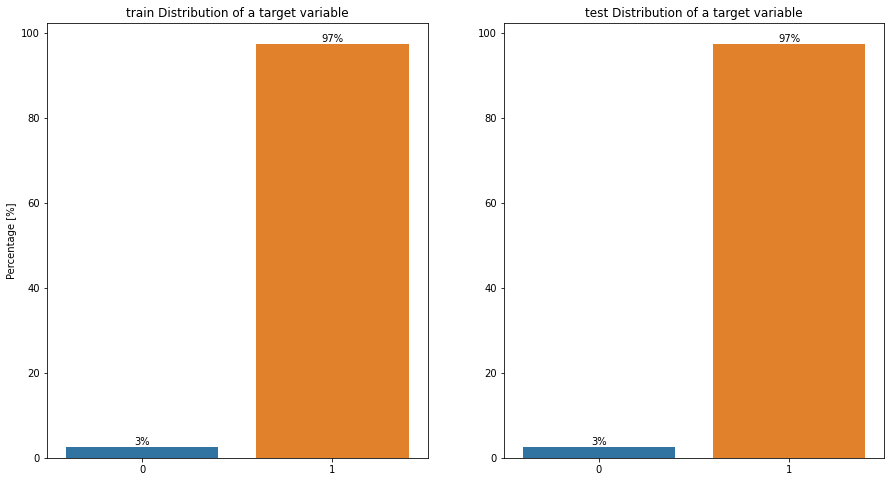

In [11]:
label_disb(df_train,df_test)

### feature distribution

In [12]:
def plot_disb(df_train,df_test):
    fig, ax = plt.subplots(nrows=8,ncols=2,figsize=(15,60))
    for i in range(1,9):
        col = df_train.columns[i]
        sns.kdeplot(df_train[col],ax=ax[i-1][0])
#         ax[i-1][0].hist(df_train[col])
        ax[i-1][0].set_title(f'{col} train distribution',fontsize=16)
        sns.kdeplot(df_test[col],ax=ax[i-1][1])
        ax[i-1][1].set_title(f'{col} test distribution',fontsize=16)
    plt.show()

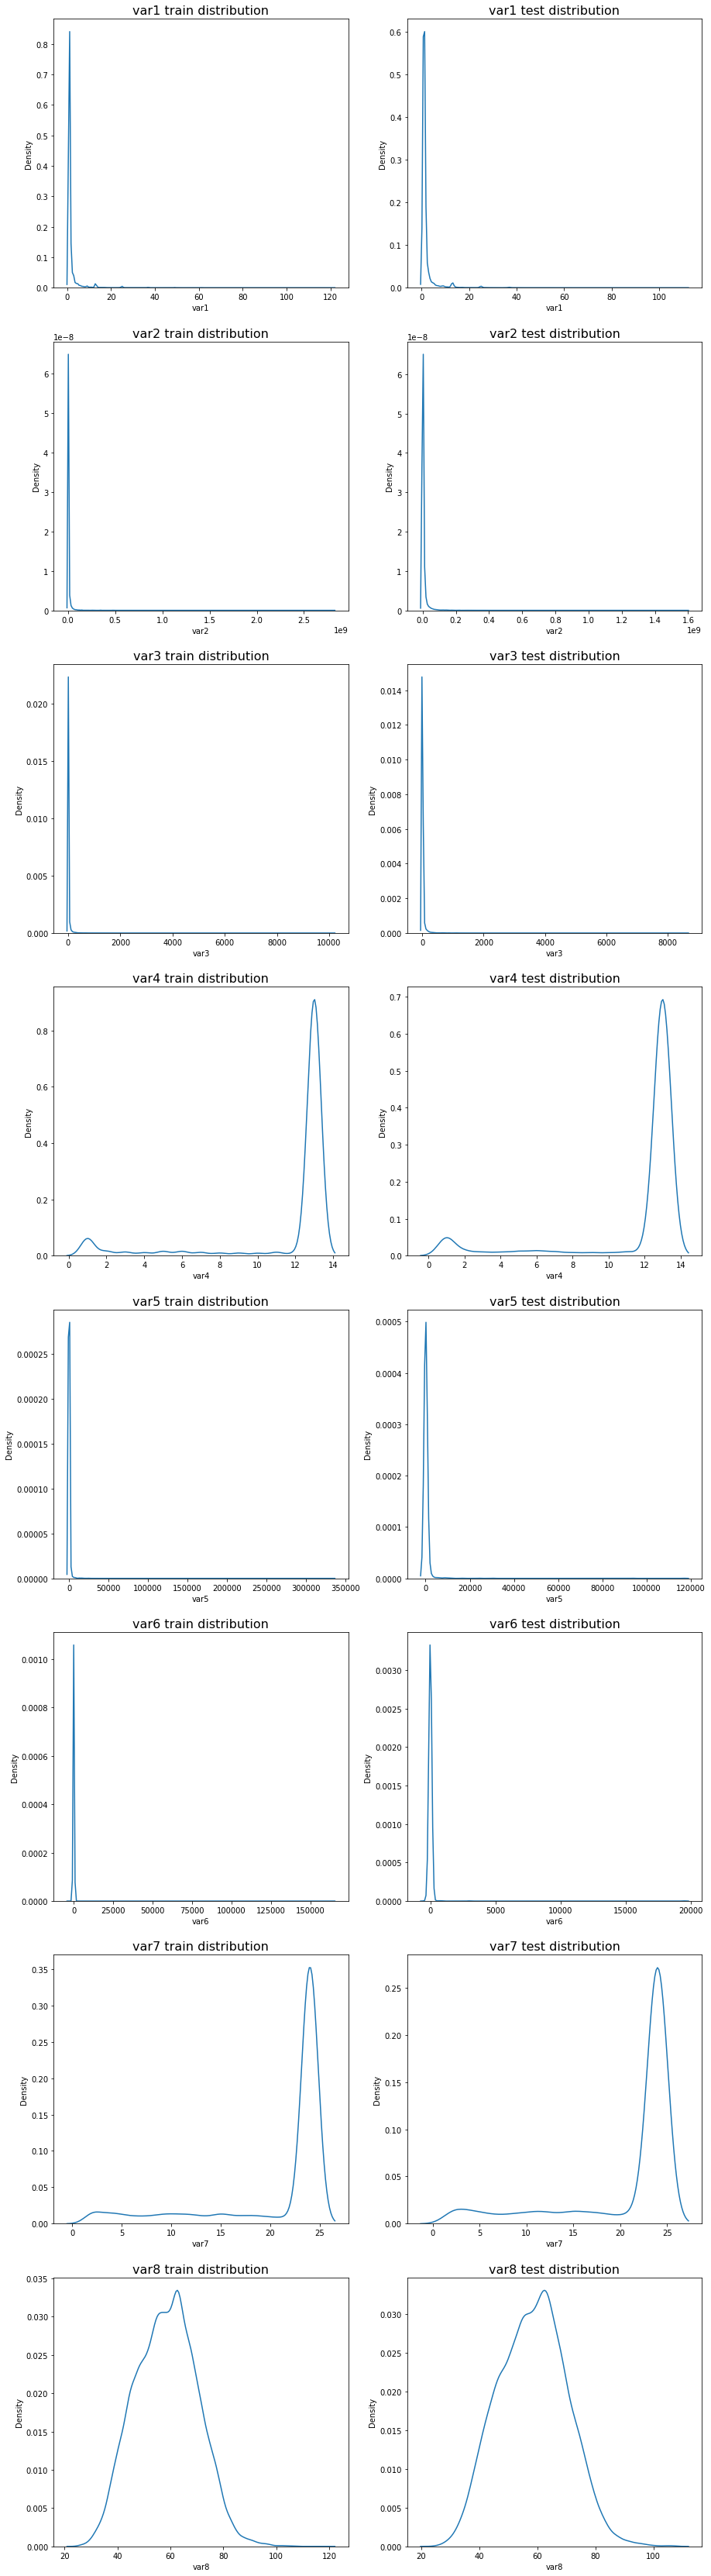

In [13]:
plot_disb(df_train,df_test)

We can see that the train data distribution is similar to the test data

## Missing Data

In [14]:
train_tmp = df_train.isna().sum().div(len(df_train)).mul(100).sort_values(ascending=False)
test_tmp = df_test.isna().sum().div(len(df_test)).mul(100).sort_values(ascending=False)

In [15]:
def Missing_count(train_tmp,test_tmp):
    plt.style.use('Solarize_Light2')
    fig, ax = plt.subplots(2,1, figsize=(15,12))
    sns.barplot(x=train_tmp.index, y=train_tmp.values, ax=ax[0])
    sns.barplot(x=test_tmp.index, y=test_tmp.values, ax=ax[1])
    ax[0].set_ylabel("Percentage [%]",fontsize=20), ax[1].set_ylabel("Percentage [%]",fontsize=20)
    ax[0].tick_params(axis='x',labelsize=20); ax[1].tick_params(axis='x',labelsize=20)
    ax[0].tick_params(axis='y',labelsize=20); ax[1].tick_params(axis='y',labelsize=20)
    plt.suptitle("Amount of missing data",fontsize=20)
    plt.tight_layout()
    plt.show()

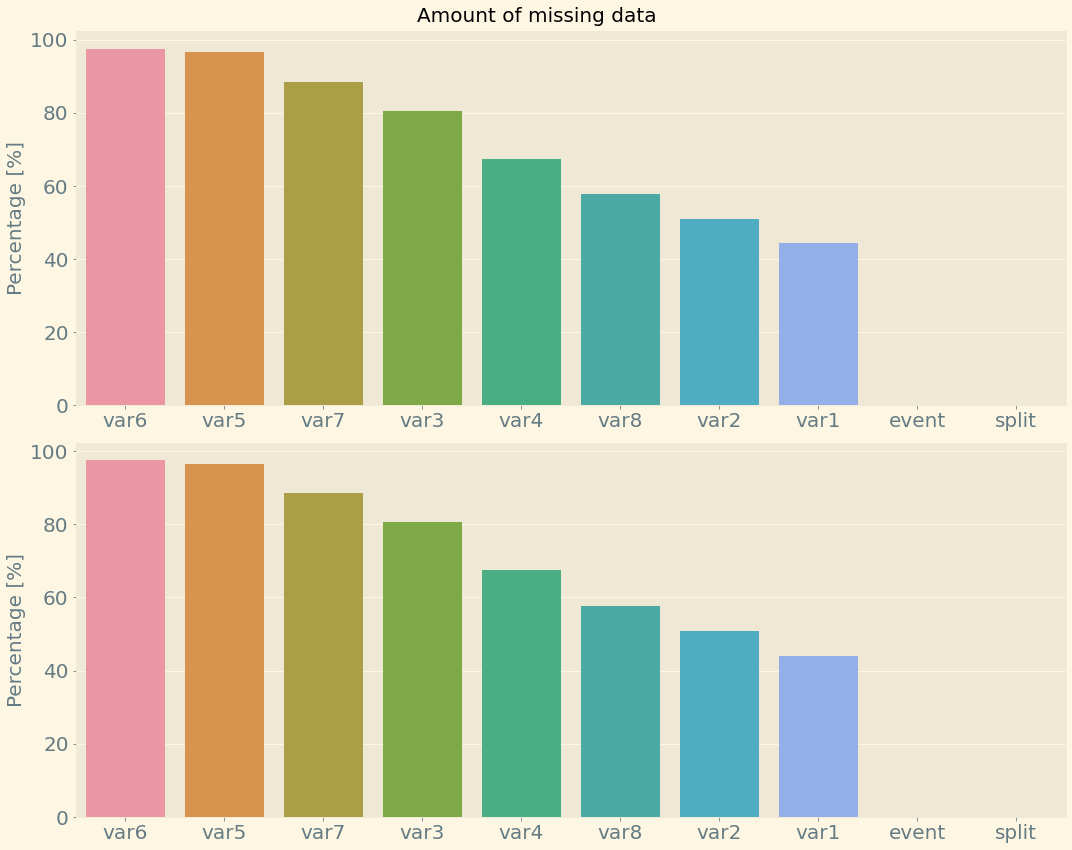

In [16]:
Missing_count(train_tmp,test_tmp)

## Correlation

In [17]:
features = [f'var{i}' for i in range(1,9)]

In [18]:
def plot_corr(df_train,df_test):
    train_corr = df_train.corr()
    test_corr = df_test.corr()
    mask_train=np.triu(np.ones_like(train_corr))
    mask_test=np.triu(np.ones_like(test_corr))

    fig, ax = plt.subplots(1,2, figsize=(16,7))
    sns.heatmap(train_corr, ax=ax[0], mask=mask_train ,vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
    sns.heatmap(test_corr, ax=ax[1], mask=mask_test,vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
    ax[0].set_title("Correlation of train features")
    ax[1].set_title("Correlation of test features")
    plt.show()

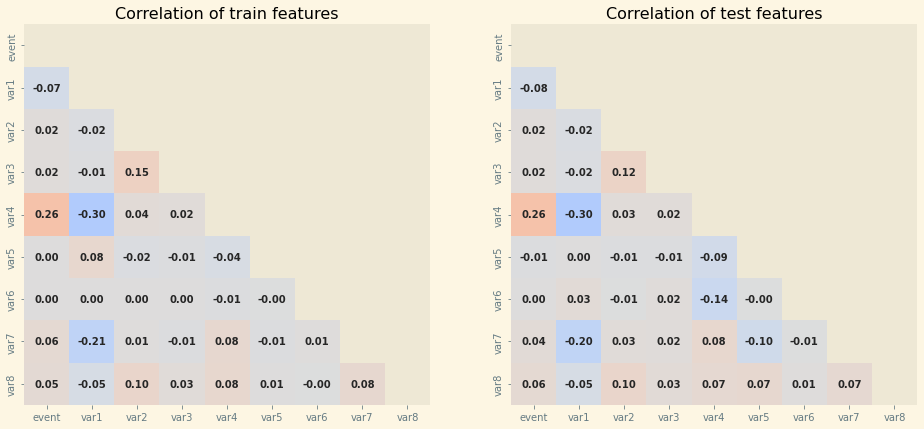

In [19]:
plot_corr(df_train,df_test)

# Model Training

We use xgboost and lightgbm which has several advantages
* It can deal with NANs
* No need standardization
* Deal with imbalanced sample

In [9]:
# df_train[features] = df_train[features].fillna(df_train[features].mean(axis=1))
# df_test[features] = df_test[features].fillna(df_test[features].mean(axis=1))

In [10]:
features =[ 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8']
label = 'event'
train_val_x, train_val_y = df_train[features].values, df_train[label].values
test_x, test_y = df_test[features].values, df_test[label].values

In [51]:
def plot_confusion_matrix(test_result):
    # 计算混淆矩阵
    cm = confusion_matrix(test_result['true'], test_result['pred'])

    # 可视化混淆矩阵
    fig = plt.figure(figsize=(8, 8))
    plt.matshow(cm, cmap=plt.cm.Reds, fignum=fig.number)
    plt.colorbar()
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [41]:
def test_rf_model(model_list):
    rf_test_result = pd.DataFrame(columns=[['pred','true']])
    rf_test_result['true'] = test_y_nona
    res = []
    for model in model_list:
        res.append(model.predict(test_x_nona))

    pred_prob = np.mean(res,axis=0)
    rf_test_result['prob'] = pred_prob
    rf_test_result['pred'] = np.array([1 if x > 0.5 else 0 for x in pred_prob])
    
    amex_metric = amex_metric_mod(test_y_nona,pred_prob)
    
    cm = confusion_matrix(rf_test_result['true'], rf_test_result['pred'])
    
    print("Random Forest Accuracy: {:.4f}".format(accuracy_score(rf_test_result['pred'], rf_test_result['true'])))
    print("Random Forest Precision: {:.4f}".format(precision_score(rf_test_result['pred'], rf_test_result['true'])))
    print("Random Forest Recall: {:.4f}".format(recall_score(rf_test_result['pred'], rf_test_result['true'])))
    print("Random Forest F1 Score: {:.4f}".format(f1_score(rf_test_result['pred'], rf_test_result['true'])))
    print("Random Forest avg Precision: {:.4f}".format(average_precision_score(rf_test_result['pred'], rf_test_result['true'])))
    print("Random Forest AUC: {:.4f}".format(roc_auc_score(rf_test_result['pred'], rf_test_result['true'])))
    
    Neg_Recall_rate = cm[0,0]/(cm[0,0]+cm[0,1])
    Neg_Precision_rate = cm[0,0]/(cm[0,0]+cm[0,1])
    Neg_F1_score = Neg_Recall_rate * Neg_Precision_rate / (Neg_Recall_rate+Neg_Precision_rate)
    print(f'Recall rate for Negative sample:{round(Neg_Recall_rate,4)}')
    return rf_test_result

In [12]:
def test_xgb_model(model_list):
    xgb_test_result = pd.DataFrame(columns=[['pred','true']])
    xgb_test_result['true'] = test_y
    res = []
    for model in model_list:
        d_test = xgb.DMatrix(data=test_x,label=test_y)
        res.append(model.predict(d_test))

    pred_prob = np.mean(res,axis=0)
    xgb_test_result['prob'] = pred_prob
    xgb_test_result['pred'] = np.array([1 if x > 0.5 else 0 for x in pred_prob])
    
    amex_metric = amex_metric_mod(test_y,pred_prob)
    
    cm = confusion_matrix(xgb_test_result['true'], xgb_test_result['pred'])
    
    print("XGBoost Accuracy: {:.4f}".format(accuracy_score(xgb_test_result['pred'], xgb_test_result['true'])))
    print("XGBoost Precision: {:.4f}".format(precision_score(xgb_test_result['pred'], xgb_test_result['true'])))
    print("XGBoost Recall: {:.4f}".format(recall_score(xgb_test_result['pred'], xgb_test_result['true'])))
    print("XGBoost F1 Score: {:.4f}".format(f1_score(xgb_test_result['pred'], xgb_test_result['true'])))
    print("XGBoost avg Precision: {:.4f}".format(average_precision_score(xgb_test_result['pred'], xgb_test_result['true'])))
    print("XGBoost AUC: {:.4f}".format(roc_auc_score(xgb_test_result['pred'], xgb_test_result['true'])))
#     print("XGBoost Amex metric: {:.4f}".format(amex_metric))
    
    Neg_Recall_rate = cm[0,0]/(cm[0,0]+cm[0,1])
    Neg_Precision_rate = cm[0,0]/(cm[0,0]+cm[0,1])
    Neg_F1_score = Neg_Recall_rate * Neg_Precision_rate / (Neg_Recall_rate+Neg_Precision_rate)
    print(f'Recall rate for Negative sample:{round(Neg_Recall_rate,4)}')
    return xgb_test_result

We use xgboost and lightgbm which have several advantages

## Version0

use random forest model with balanced and unbalanced sample

In [46]:
def train_rf_model(balanced = False):
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    acc_rf, precision_rf, recall_rf, f1_rf, ap_rf, auc_rf = [], [], [], [], [], []
    rf_test_result = pd.DataFrame({'true':test_y_nona})
    threshold = 0.5
    kf_iter = 0
    model_list = []
    for train_idx, valid_idx in kf.split(train_val_x_nona):
        kf_iter += 1
        X_train, X_valid = train_val_x_nona[train_idx], train_val_x_nona[valid_idx]
        y_train, y_valid = train_val_y_nona[train_idx], train_val_y_nona[valid_idx]

        ## define rf Classfier model
        if balanced:
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
        else:
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

        # 拟合模型
        rf_model.fit(X_train, y_train)
        
        model_list.append(rf_model)

        prob_pred_rf = rf_model.predict(X_valid) # pred probability
        y_pred_rf = np.array([1 if x > 0.5 else 0 for x in prob_pred_rf]) # pred value 0,1

        acc_rf.append(accuracy_score(y_valid, y_pred_rf))
        precision_rf.append(precision_score(y_valid, y_pred_rf))
        recall_rf.append(recall_score(y_valid, y_pred_rf))
        f1_rf.append(f1_score(y_valid, y_pred_rf))
        ap_rf.append(average_precision_score(y_valid, y_pred_rf))
        auc_rf.append(roc_auc_score(y_valid, y_pred_rf))



    print("Random Forest Accuracy: {:.4f}".format(np.mean(acc_rf)))
    print("Random Forest Precision: {:.4f}".format(np.mean(precision_rf)))
    print("Random Forest Recall: {:.4f}".format(np.mean(recall_rf)))
    print("Random Forest F1 Score: {:.4f}".format(np.mean(f1_rf)))
    print("Random Forest Avg Precision: {:.4f}".format(np.mean(ap_rf)))
    print("Random Forest AUC: {:.4f}".format(np.mean(auc_rf)))
    return model_list

use mean value to fill na-values for rf model

In [32]:
df_train_nona = df_train.copy()
df_test_nona = df_test.copy()
df_train_nona.loc[:,features] = df_train_nona[features].fillna(value=df_train_nona[features].mean())
df_test_nona.loc[:,features] = df_test_nona[features].fillna(value=df_train_nona[features].mean())
df_train_nona

,event,var1,var2,var3,var4,var5,var6,var7,var8,split
id,,,,,,,,,,
0,1,1.873951,5.989773e+06,16.772031,11.586977,289.199746,28.430493,20.646794,58.497153,dev
1,1,1.873951,5.989773e+06,16.772031,11.586977,289.199746,28.430493,20.646794,58.497153,dev
2,1,1.873951,5.989773e+06,16.772031,11.586977,289.199746,28.430493,20.646794,58.497153,dev
3,1,1.000000,2.096510e+07,16.772031,11.586977,289.199746,28.430493,20.646794,62.750000,dev
4,1,1.873951,5.989773e+06,16.772031,11.586977,289.199746,28.430493,20.646794,58.497153,dev
...,...,...,...,...,...,...,...,...,...,...
238831,1,1.000000,6.523118e+04,16.772031,11.586977,289.199746,28.430493,20.646794,58.916667,dev
238832,1,1.000000,5.989773e+06,16.772031,11.586977,289.199746,28.430493,20.646794,58.497153,dev
238833,1,1.873951,5.989773e+06,16.772031,11.586977,289.199746,28.430493,20.646794,58.497153,dev


In [33]:
train_val_x_nona, train_val_y_nona = df_train_nona[features].values, df_train_nona[label].values
test_x_nona, test_y_nona = df_test_nona[features].values, df_test_nona[label].values

### Unbalanced samples

In [47]:
rf_model_list = train_rf_model(balanced=False)

Random Forest Accuracy: 0.9722
Random Forest Precision: 0.9756
Random Forest Recall: 0.9964
Random Forest F1 Score: 0.9859
Random Forest Avg Precision: 0.9756
Random Forest AUC: 0.5166


### Prediction

In [44]:
rf_test_result = test_rf_model(rf_model_list)

Random Forest Accuracy: 0.9725
Random Forest Precision: 0.9967
Random Forest Recall: 0.9756
Random Forest F1 Score: 0.9860
Random Forest avg Precision: 0.9967
Random Forest AUC: 0.5765
Recall rate for Negative sample:0.0275


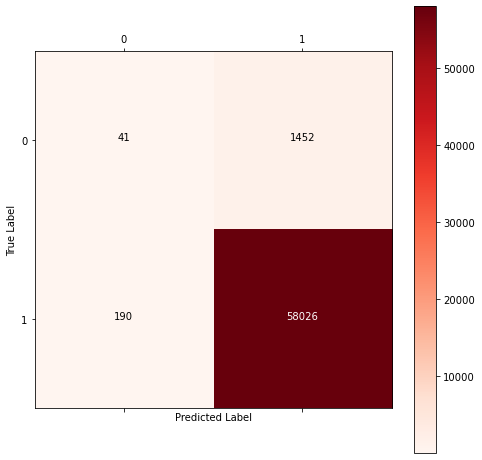

In [52]:
plot_confusion_matrix(rf_test_result)

### Balanced samples

In [48]:
rf_model_list1 = train_rf_model(balanced=True)

Random Forest Accuracy: 0.6099
Random Forest Precision: 0.9814
Random Forest Recall: 0.6114
Random Forest F1 Score: 0.7534
Random Forest Avg Precision: 0.9788
Random Forest AUC: 0.5823


### Prediction

In [49]:
rf_test_result1 = test_rf_model(rf_model_list1)

Random Forest Accuracy: 0.6091
Random Forest Precision: 0.6102
Random Forest Recall: 0.9820
Random Forest F1 Score: 0.7527
Random Forest avg Precision: 0.6101
Random Forest AUC: 0.5089
Recall rate for Negative sample:0.5646


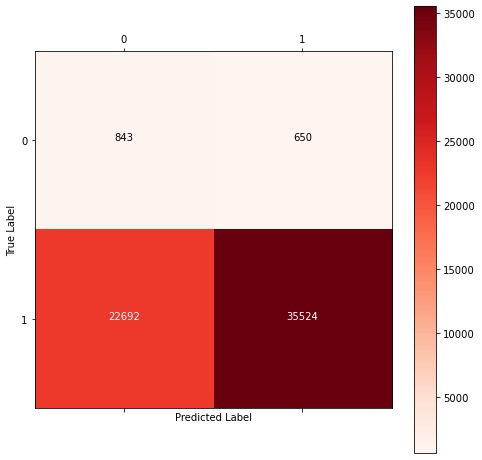

In [53]:
plot_confusion_matrix(rf_test_result1)

## Version1

Simply using Xgboost train model in 5-folds

### Training 5-folds

In [41]:
# XGBoost参数
params1 = {
#     'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.3,
    'max_depth': 6,
    'subsample': 0.8,
#     'verbose': 10,
    'random_state': 42,
#     'scale_pos_weight':3/97
}

In [42]:
def train_xgb_model1(params1):
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    acc_lgb, precision_lgb, recall_lgb, f1_lgb, ap_lgb, auc_lgb = [], [], [], [], [], []
    acc_xgb, precision_xgb, recall_xgb, f1_xgb, ap_xgb, auc_xgb = [], [], [], [], [], []
    lgbm_test_result = pd.DataFrame({'true':test_y})
    xgb_test_result = pd.DataFrame({'true':test_y})
    threshold = 0.5
    kf_iter = 0
    model_list = []
    for train_idx, valid_idx in kf.split(train_val_x):
        kf_iter += 1
        X_train, X_valid = train_val_x[train_idx], train_val_x[valid_idx]
        y_train, y_valid = train_val_y[train_idx], train_val_y[valid_idx]

        dtrain = xgb.DMatrix(data=X_train,label=y_train)
        dval = xgb.DMatrix(data=X_valid,label=y_valid)

        watch_list = [(dtrain, 'train'), (dval, 'valid')]

        xgb_model = xgb.train(params=params1, 
                              dtrain=dtrain, 
                              num_boost_round=100, 
                              early_stopping_rounds=20,
                              verbose_eval=20,
                              evals=watch_list
                             )
        
        model_list.append(xgb_model)

        prob_pred_xgb = xgb_model.predict(dval) # pred probability
        y_pred_xgb = np.array([1 if x > 0.5 else 0 for x in prob_pred_xgb]) # pred value 0,1

        acc_xgb.append(accuracy_score(y_valid, y_pred_xgb))
        precision_xgb.append(precision_score(y_valid, y_pred_xgb))
        recall_xgb.append(recall_score(y_valid, y_pred_xgb))
        f1_xgb.append(f1_score(y_valid, y_pred_xgb))
        ap_xgb.append(average_precision_score(y_valid, y_pred_xgb))
        auc_xgb.append(roc_auc_score(y_valid, y_pred_xgb))


    #     xgb_test_result[kf_iter] = xgb_model.predict(d_test)


    print("XGBoost Accuracy: {:.4f}".format(np.mean(acc_xgb)))
    print("XGBoost Precision: {:.4f}".format(np.mean(precision_xgb)))
    print("XGBoost Recall: {:.4f}".format(np.mean(recall_xgb)))
    print("XGBoost F1 Score: {:.4f}".format(np.mean(f1_xgb)))
    print("XGBoost Avg Precision: {:.4f}".format(np.mean(ap_xgb)))
    print("XGBoost AUC: {:.4f}".format(np.mean(auc_xgb)))
    return model_list

In [43]:
model_list1 = train_xgb_model1(params1)

[0]	train-auc:0.72087	valid-auc:0.70706
[20]	train-auc:0.76820	valid-auc:0.73626
[40]	train-auc:0.78069	valid-auc:0.73371
[46]	train-auc:0.78269	valid-auc:0.73270
[0]	train-auc:0.72019	valid-auc:0.70966
[20]	train-auc:0.76564	valid-auc:0.73954
[40]	train-auc:0.77884	valid-auc:0.74054
[52]	train-auc:0.78667	valid-auc:0.73781
[0]	train-auc:0.70868	valid-auc:0.70486
[20]	train-auc:0.76658	valid-auc:0.74236
[36]	train-auc:0.78099	valid-auc:0.74247
[0]	train-auc:0.71547	valid-auc:0.72388
[20]	train-auc:0.76433	valid-auc:0.74630
[40]	train-auc:0.77750	valid-auc:0.74744
[55]	train-auc:0.78518	valid-auc:0.74473
[0]	train-auc:0.71907	valid-auc:0.71499
[20]	train-auc:0.76580	valid-auc:0.74148
[40]	train-auc:0.78073	valid-auc:0.73688
XGBoost Accuracy: 0.9747
XGBoost Precision: 0.9753
XGBoost Recall: 0.9993
XGBoost F1 Score: 0.9872
XGBoost Avg Precision: 0.9753
XGBoost AUC: 0.5121


###  Prediction

In [44]:
xgb_test_result1 = test_xgb_model(model_list1)

XGBoost Accuracy: 0.9748
XGBoost Precision: 0.9994
XGBoost Recall: 0.9754
XGBoost F1 Score: 0.9872
XGBoost avg Precision: 0.9994
XGBoost AUC: 0.6946
Recall rate for Negative sample:0.0161


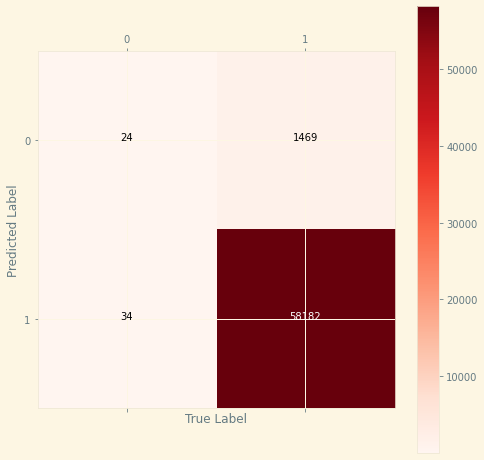

In [45]:
plot_confusion_matrix(xgb_test_result1)

This model has bad recall rate for 0 label (default). However, for bank the first class error is more serious (the true label is 0, but we predict 1, which means we lend money to client, but he default). Therefore, we should focus more on recall rate for 0 label besides AUC.

## Version2

### Self define Loss Function: Focal Loss

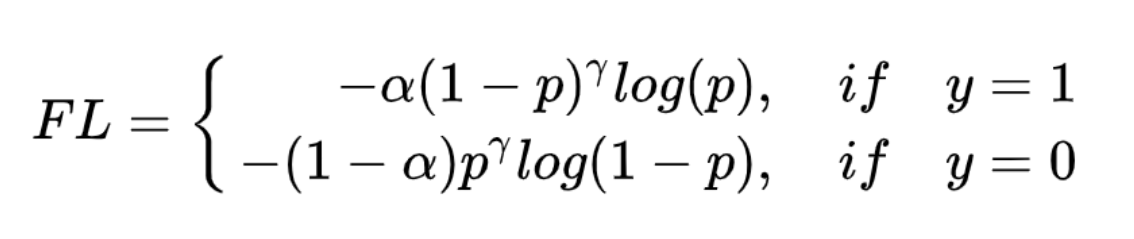

Focal loss can adjust the weight for imbalance sample, and increase the weight for difficult sample. And we can replace the loss function for xgboost

In [47]:
def focal_loss(p, dtrain, alpha=0.03, gamma=0.1):
    y = dtrain.get_label()
    p = 1.0 / (1.0 + np.exp(-p))
    grad = p * (1 - p) * (alpha * gamma * y * (1 - p) ** gamma * np.log(p) / (1 - p) - alpha * y * (
                1 - p) ** gamma / p - gamma * p ** gamma * (1 - alpha) * (1 - y) * np.log(1 - p) / p + p ** gamma * (
                                      1 - alpha) * (1 - y) / (1 - p))
    hess = p * (1 - p) * (p * (1 - p) * (
                -alpha * gamma ** 2 * y * (1 - p) ** gamma * np.log(p) / (1 - p) ** 2 + alpha * gamma * y * (
                    1 - p) ** gamma * np.log(p) / (1 - p) ** 2 + 2 * alpha * gamma * y * (1 - p) ** gamma / (
                            p * (1 - p)) + alpha * y * (1 - p) ** gamma / p ** 2 - gamma ** 2 * p ** gamma * (
                            1 - alpha) * (1 - y) * np.log(1 - p) / p ** 2 + 2 * gamma * p ** gamma * (1 - alpha) * (
                            1 - y) / (p * (1 - p)) + gamma * p ** gamma * (1 - alpha) * (1 - y) * np.log(
            1 - p) / p ** 2 + p ** gamma * (1 - alpha) * (1 - y) / (1 - p) ** 2) - p * (
                                      alpha * gamma * y * (1 - p) ** gamma * np.log(p) / (1 - p) - alpha * y * (
                                          1 - p) ** gamma / p - gamma * p ** gamma * (1 - alpha) * (1 - y) * np.log(
                                  1 - p) / p + p ** gamma * (1 - alpha) * (1 - y) / (1 - p)) + (1 - p) * (
                                      alpha * gamma * y * (1 - p) ** gamma * np.log(p) / (1 - p) - alpha * y * (
                                          1 - p) ** gamma / p - gamma * p ** gamma * (1 - alpha) * (1 - y) * np.log(
                                  1 - p) / p + p ** gamma * (1 - alpha) * (1 - y) / (1 - p)))
    return grad, hess



### Self define Metric Function

In [43]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()] # sort by y_pred ascending
    weights    = np.where(labels[:,0]==0, 32, 1) # weight 20 for label 0 (upsample 20 times)
    cut_vals   = labels[np.cumsum(weights) <= int(0.05 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 32, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)


def amex_metric(preds,dtrain):
    y_true = dtrain.get_label()
    y_pred = preds 
    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()] # sort by y_pred ascending
    weights    = np.where(labels[:,0]==0, 32, 1) # weight 32 for label 0 (upsample 20 times)
    cut_vals   = labels[np.cumsum(weights) <= int(0.05 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 32, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 'amex_metric',0.5 * (gini[1]/gini[0] + top_four)


### Search Parameters in valid set: Optuna

In [59]:
import optuna


# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to optimize
    params = {
#         'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'random_state': 42,
#         'eval_metric':['auc', amex_metric]
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    kf_iter = 0 
    auc_score = 0
    for train_idx, valid_idx in tqdm(kf.split(train_val_x)):
        kf_iter += 1
        X_train, X_valid = train_val_x[train_idx], train_val_x[valid_idx]
        y_train, y_valid = train_val_y[train_idx], train_val_y[valid_idx]
        dtrain = xgb.DMatrix(data=X_train,label=y_train)
        dval = xgb.DMatrix(data=X_valid,label=y_valid)

        watch_list = [(dtrain, 'train'), (dval, 'valid')]

        xgb_model = xgb.train(params=params, 
                              dtrain=dtrain, 
                              num_boost_round=100, 
                              early_stopping_rounds=20,
                              verbose_eval=20,
                              evals=watch_list,
                              obj = focal_loss,
                              feval = amex_metric
                             )
#         if kf_iter>=1:
#             break
            
        prob_pred_xgb = xgb_model.predict(dval) # pred probability
        y_pred_xgb = np.array([1 if x > 0.5 else 0 for x in prob_pred_xgb]) # pred value 0,1
    
        # Compute the AUC score
        auc_score += roc_auc_score(y_valid, y_pred_xgb) / 5
    
        amex_score = amex_metric_mod(y_valid,prob_pred_xgb)
    
#         loss = focal_loss(prob_pred_xgb,dval)/5
    
    # Return the AUC score as the objective value for Optuna
    return auc_score

# Define the study for Optuna
study = optuna.create_study(direction='maximize')

# Optimize the hyperparameters with Optuna
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and the corresponding AUC score
print('Best hyperparameters: ', study.best_params)
print('Best auc score: ', study.best_value)

[I 2023-04-29 11:43:14,675] A new study created in memory with name: no-name-cee43876-514d-4008-a760-aef310cd4284
0it [00:00, ?it/s]

[0]	train-auc:0.55628	train-amex_metric:0.07198	valid-auc:0.56039	valid-amex_metric:0.07636
[19]	train-auc:0.70809	train-amex_metric:0.21410	valid-auc:0.68420	valid-amex_metric:0.19167


1it [00:03,  3.35s/it]

[0]	train-auc:0.55424	train-amex_metric:0.06689	valid-auc:0.56921	valid-amex_metric:0.08097
[20]	train-auc:0.73512	train-amex_metric:0.23868	valid-auc:0.73199	valid-amex_metric:0.23865


2it [00:06,  3.43s/it]

[0]	train-auc:0.55869	train-amex_metric:0.07340	valid-auc:0.55318	valid-amex_metric:0.06464
[20]	train-auc:0.72767	train-amex_metric:0.23313	valid-auc:0.71392	valid-amex_metric:0.21993


3it [00:10,  3.44s/it]

[0]	train-auc:0.55696	train-amex_metric:0.07025	valid-auc:0.54936	valid-amex_metric:0.06786
[19]	train-auc:0.73119	train-amex_metric:0.23611	valid-auc:0.73275	valid-amex_metric:0.23612


4it [00:13,  3.45s/it]

[0]	train-auc:0.56244	train-amex_metric:0.07681	valid-auc:0.54431	valid-amex_metric:0.06516
[20]	train-auc:0.73745	train-amex_metric:0.24264	valid-auc:0.72896	valid-amex_metric:0.23362


5it [00:17,  3.45s/it]
[I 2023-04-29 11:43:31,917] Trial 0 finished with value: 0.645203460138196 and parameters: {'max_depth': 4, 'eta': 0.9226983333025904, 'min_child_weight': 10, 'subsample': 0.22601168378182696, 'colsample_bytree': 0.16154411178475536, 'lambda': 2.4274935343391e-08, 'alpha': 4.550417712568296e-08}. Best is trial 0 with value: 0.645203460138196.
0it [00:00, ?it/s]

[0]	train-auc:0.69448	train-amex_metric:0.19947	valid-auc:0.67376	valid-amex_metric:0.17788
[20]	train-auc:0.73891	train-amex_metric:0.24210	valid-auc:0.72259	valid-amex_metric:0.22810


1it [00:03,  3.76s/it]

[0]	train-auc:0.68579	train-amex_metric:0.19237	valid-auc:0.68910	valid-amex_metric:0.20086
[19]	train-auc:0.73607	train-amex_metric:0.23957	valid-auc:0.73387	valid-amex_metric:0.24000


2it [00:07,  3.78s/it]

[0]	train-auc:0.68823	train-amex_metric:0.19679	valid-auc:0.68493	valid-amex_metric:0.18759
[20]	train-auc:0.73562	train-amex_metric:0.24030	valid-auc:0.73304	valid-amex_metric:0.23581


3it [00:11,  3.79s/it]

[0]	train-auc:0.69229	train-amex_metric:0.19787	valid-auc:0.70562	valid-amex_metric:0.21056
[19]	train-auc:0.73653	train-amex_metric:0.24130	valid-auc:0.73507	valid-amex_metric:0.23890


4it [00:15,  3.82s/it]

[0]	train-auc:0.69168	train-amex_metric:0.19821	valid-auc:0.67703	valid-amex_metric:0.18507
[20]	train-auc:0.73731	train-amex_metric:0.24228	valid-auc:0.73468	valid-amex_metric:0.23935


5it [00:19,  3.82s/it]
[I 2023-04-29 11:43:51,000] Trial 1 finished with value: 0.6544345071847126 and parameters: {'max_depth': 8, 'eta': 3.6445361782409736e-07, 'min_child_weight': 10, 'subsample': 0.1756949524245861, 'colsample_bytree': 0.8191614632136499, 'lambda': 0.02653660676433811, 'alpha': 4.355940763764285e-06}. Best is trial 1 with value: 0.6544345071847126.
0it [00:00, ?it/s]

[0]	train-auc:0.55817	train-amex_metric:0.07235	valid-auc:0.56338	valid-amex_metric:0.07732
[19]	train-auc:0.71067	train-amex_metric:0.21685	valid-auc:0.68568	valid-amex_metric:0.19561


1it [00:03,  3.66s/it]

[0]	train-auc:0.55480	train-amex_metric:0.06602	valid-auc:0.57218	valid-amex_metric:0.08431
[20]	train-auc:0.74174	train-amex_metric:0.24494	valid-auc:0.73638	valid-amex_metric:0.24138


2it [00:07,  3.72s/it]

[0]	train-auc:0.56016	train-amex_metric:0.07446	valid-auc:0.55545	valid-amex_metric:0.06340
[20]	train-auc:0.74183	train-amex_metric:0.24727	valid-auc:0.72816	valid-amex_metric:0.23309


3it [00:11,  3.73s/it]

[0]	train-auc:0.55993	train-amex_metric:0.07219	valid-auc:0.55649	valid-amex_metric:0.07432
[20]	train-auc:0.74206	train-amex_metric:0.24689	valid-auc:0.73548	valid-amex_metric:0.23774


4it [00:14,  3.74s/it]

[0]	train-auc:0.56280	train-amex_metric:0.07591	valid-auc:0.54494	valid-amex_metric:0.06138
[19]	train-auc:0.74199	train-amex_metric:0.24638	valid-auc:0.72822	valid-amex_metric:0.23393


5it [00:18,  3.75s/it]
[I 2023-04-29 11:44:09,748] Trial 2 finished with value: 0.647818669453643 and parameters: {'max_depth': 4, 'eta': 0.4798885152143162, 'min_child_weight': 5, 'subsample': 0.9547620056421517, 'colsample_bytree': 0.24607700124222529, 'lambda': 0.7603112051855696, 'alpha': 0.051158646481322755}. Best is trial 1 with value: 0.6544345071847126.
0it [00:00, ?it/s]

[0]	train-auc:0.64129	train-amex_metric:0.14690	valid-auc:0.62700	valid-amex_metric:0.13565
[19]	train-auc:0.70442	train-amex_metric:0.20860	valid-auc:0.69210	valid-amex_metric:0.20022


1it [00:03,  3.56s/it]

[0]	train-auc:0.63453	train-amex_metric:0.14085	valid-auc:0.63000	valid-amex_metric:0.14170
[19]	train-auc:0.68701	train-amex_metric:0.19008	valid-auc:0.68381	valid-amex_metric:0.19017


2it [00:07,  3.55s/it]

[0]	train-auc:0.63881	train-amex_metric:0.14429	valid-auc:0.63715	valid-amex_metric:0.14337
[20]	train-auc:0.69203	train-amex_metric:0.19893	valid-auc:0.68758	valid-amex_metric:0.19351


3it [00:10,  3.55s/it]

[0]	train-auc:0.63218	train-amex_metric:0.14136	valid-auc:0.63851	valid-amex_metric:0.13957
[20]	train-auc:0.69861	train-amex_metric:0.20475	valid-auc:0.69443	valid-amex_metric:0.19678


4it [00:14,  3.54s/it]

[0]	train-auc:0.65088	train-amex_metric:0.15828	valid-auc:0.65168	valid-amex_metric:0.16085
[20]	train-auc:0.69407	train-amex_metric:0.19885	valid-auc:0.69980	valid-amex_metric:0.20663


5it [00:17,  3.54s/it]
[I 2023-04-29 11:44:27,468] Trial 3 finished with value: 0.5957576468787497 and parameters: {'max_depth': 2, 'eta': 0.0020769892962428102, 'min_child_weight': 9, 'subsample': 0.5571283625917204, 'colsample_bytree': 0.7731603800855729, 'lambda': 5.8651190304965016e-08, 'alpha': 4.163336684196224e-06}. Best is trial 1 with value: 0.6544345071847126.
0it [00:00, ?it/s]

[0]	train-auc:0.55675	train-amex_metric:0.07129	valid-auc:0.56076	valid-amex_metric:0.07514
[19]	train-auc:0.69753	train-amex_metric:0.20416	valid-auc:0.67340	valid-amex_metric:0.18299


1it [00:03,  3.65s/it]

[0]	train-auc:0.55435	train-amex_metric:0.06614	valid-auc:0.56923	valid-amex_metric:0.08103
[20]	train-auc:0.71371	train-amex_metric:0.21803	valid-auc:0.71406	valid-amex_metric:0.22111


2it [00:07,  3.73s/it]

[0]	train-auc:0.56017	train-amex_metric:0.07462	valid-auc:0.55561	valid-amex_metric:0.06264
[19]	train-auc:0.71498	train-amex_metric:0.22093	valid-auc:0.70652	valid-amex_metric:0.21007


3it [00:11,  3.76s/it]

[0]	train-auc:0.55866	train-amex_metric:0.07192	valid-auc:0.55440	valid-amex_metric:0.07277
[20]	train-auc:0.71374	train-amex_metric:0.21943	valid-auc:0.70667	valid-amex_metric:0.21027


4it [00:15,  3.79s/it]

[0]	train-auc:0.56261	train-amex_metric:0.07637	valid-auc:0.54472	valid-amex_metric:0.06144
[20]	train-auc:0.71742	train-amex_metric:0.22274	valid-auc:0.70808	valid-amex_metric:0.21293


5it [00:18,  3.77s/it]
[I 2023-04-29 11:44:46,345] Trial 4 finished with value: 0.6123051875583838 and parameters: {'max_depth': 5, 'eta': 0.15628585633621236, 'min_child_weight': 4, 'subsample': 0.3140104069762485, 'colsample_bytree': 0.1564390468978002, 'lambda': 3.912463686338668e-06, 'alpha': 5.8991349152708464e-08}. Best is trial 1 with value: 0.6544345071847126.
0it [00:00, ?it/s]

[0]	train-auc:0.68646	train-amex_metric:0.19075	valid-auc:0.67078	valid-amex_metric:0.18174
[20]	train-auc:0.73777	train-amex_metric:0.24114	valid-auc:0.71988	valid-amex_metric:0.22553


1it [00:03,  3.99s/it]

[0]	train-auc:0.68637	train-amex_metric:0.19077	valid-auc:0.69118	valid-amex_metric:0.19385
[19]	train-auc:0.74742	train-amex_metric:0.25048	valid-auc:0.73796	valid-amex_metric:0.24378


2it [00:08,  4.02s/it]

[0]	train-auc:0.68601	train-amex_metric:0.19402	valid-auc:0.68851	valid-amex_metric:0.19402
[20]	train-auc:0.74737	train-amex_metric:0.25170	valid-auc:0.73724	valid-amex_metric:0.23852


3it [00:12,  4.01s/it]

[0]	train-auc:0.68793	train-amex_metric:0.19548	valid-auc:0.68951	valid-amex_metric:0.19367
[20]	train-auc:0.74662	train-amex_metric:0.25048	valid-auc:0.74217	valid-amex_metric:0.24557


4it [00:16,  4.01s/it]

[0]	train-auc:0.69233	train-amex_metric:0.19758	valid-auc:0.67596	valid-amex_metric:0.18280
[20]	train-auc:0.74607	train-amex_metric:0.25016	valid-auc:0.74279	valid-amex_metric:0.24682


5it [00:20,  4.02s/it]
[I 2023-04-29 11:45:06,449] Trial 5 finished with value: 0.6548578046909934 and parameters: {'max_depth': 7, 'eta': 4.99433280339042e-08, 'min_child_weight': 2, 'subsample': 0.2773581038660461, 'colsample_bytree': 0.5651392780069935, 'lambda': 1.6010562905837303e-06, 'alpha': 0.007614426311212657}. Best is trial 5 with value: 0.6548578046909934.
0it [00:00, ?it/s]

[0]	train-auc:0.70086	train-amex_metric:0.20503	valid-auc:0.68378	valid-amex_metric:0.19176
[19]	train-auc:0.74832	train-amex_metric:0.25116	valid-auc:0.73253	valid-amex_metric:0.23756


1it [00:04,  4.45s/it]

[0]	train-auc:0.69928	train-amex_metric:0.20311	valid-auc:0.70215	valid-amex_metric:0.21171
[19]	train-auc:0.74847	train-amex_metric:0.25084	valid-auc:0.74294	valid-amex_metric:0.24785


2it [00:08,  4.49s/it]

[0]	train-auc:0.69861	train-amex_metric:0.20390	valid-auc:0.69954	valid-amex_metric:0.20170
[20]	train-auc:0.74894	train-amex_metric:0.25249	valid-auc:0.73937	valid-amex_metric:0.24103


3it [00:13,  4.49s/it]

[0]	train-auc:0.69522	train-amex_metric:0.20107	valid-auc:0.70091	valid-amex_metric:0.20597
[19]	train-auc:0.74788	train-amex_metric:0.25147	valid-auc:0.74337	valid-amex_metric:0.24569


4it [00:17,  4.49s/it]

[0]	train-auc:0.70784	train-amex_metric:0.21176	valid-auc:0.69303	valid-amex_metric:0.19644
[19]	train-auc:0.74696	train-amex_metric:0.25020	valid-auc:0.74340	valid-amex_metric:0.24755


5it [00:22,  4.49s/it]
[I 2023-04-29 11:45:28,925] Trial 6 finished with value: 0.6551237389415538 and parameters: {'max_depth': 6, 'eta': 0.0044352028349878385, 'min_child_weight': 6, 'subsample': 0.6526582368313193, 'colsample_bytree': 0.7454270086959678, 'lambda': 4.700728106677417e-05, 'alpha': 3.7311560871595216e-07}. Best is trial 6 with value: 0.6551237389415538.
0it [00:00, ?it/s]

[0]	train-auc:0.55578	train-amex_metric:0.07054	valid-auc:0.55877	valid-amex_metric:0.07278
[20]	train-auc:0.68440	train-amex_metric:0.19339	valid-auc:0.67060	valid-amex_metric:0.18167


1it [00:03,  3.55s/it]

[0]	train-auc:0.55413	train-amex_metric:0.06750	valid-auc:0.57072	valid-amex_metric:0.08336
[19]	train-auc:0.69896	train-amex_metric:0.20475	valid-auc:0.70182	valid-amex_metric:0.20844


2it [00:07,  3.61s/it]

[0]	train-auc:0.55875	train-amex_metric:0.07428	valid-auc:0.55136	valid-amex_metric:0.05814
[20]	train-auc:0.70066	train-amex_metric:0.20752	valid-auc:0.69704	valid-amex_metric:0.20220


3it [00:10,  3.61s/it]

[0]	train-auc:0.55833	train-amex_metric:0.07225	valid-auc:0.55293	valid-amex_metric:0.07128
[20]	train-auc:0.69868	train-amex_metric:0.20490	valid-auc:0.69881	valid-amex_metric:0.20378


4it [00:14,  3.64s/it]

[0]	train-auc:0.56081	train-amex_metric:0.07526	valid-auc:0.54421	valid-amex_metric:0.06377
[20]	train-auc:0.69966	train-amex_metric:0.20656	valid-auc:0.69748	valid-amex_metric:0.20226


5it [00:18,  3.63s/it]
[I 2023-04-29 11:45:47,096] Trial 7 finished with value: 0.5461471530545154 and parameters: {'max_depth': 2, 'eta': 0.00010914270964840522, 'min_child_weight': 3, 'subsample': 0.6890976382890948, 'colsample_bytree': 0.15845432942939933, 'lambda': 0.29637496918268186, 'alpha': 0.014734463282027195}. Best is trial 6 with value: 0.6551237389415538.
0it [00:00, ?it/s]

[0]	train-auc:0.55578	train-amex_metric:0.07054	valid-auc:0.55877	valid-amex_metric:0.07278
[20]	train-auc:0.69241	train-amex_metric:0.20019	valid-auc:0.67755	valid-amex_metric:0.18705


1it [00:03,  3.60s/it]

[0]	train-auc:0.55409	train-amex_metric:0.06753	valid-auc:0.57055	valid-amex_metric:0.08403
[20]	train-auc:0.71007	train-amex_metric:0.21627	valid-auc:0.71232	valid-amex_metric:0.21900


2it [00:07,  3.65s/it]

[0]	train-auc:0.55875	train-amex_metric:0.07428	valid-auc:0.55136	valid-amex_metric:0.05814
[19]	train-auc:0.71026	train-amex_metric:0.21598	valid-auc:0.70703	valid-amex_metric:0.21283


3it [00:10,  3.67s/it]

[0]	train-auc:0.55796	train-amex_metric:0.07244	valid-auc:0.55571	valid-amex_metric:0.07532
[19]	train-auc:0.70933	train-amex_metric:0.21521	valid-auc:0.70914	valid-amex_metric:0.21332


4it [00:14,  3.69s/it]

[0]	train-auc:0.56083	train-amex_metric:0.07563	valid-auc:0.54423	valid-amex_metric:0.06413
[20]	train-auc:0.71162	train-amex_metric:0.21737	valid-auc:0.70854	valid-amex_metric:0.21324


5it [00:18,  3.67s/it]
[I 2023-04-29 11:46:05,430] Trial 8 finished with value: 0.5994239164417546 and parameters: {'max_depth': 2, 'eta': 0.13109269991686773, 'min_child_weight': 3, 'subsample': 0.9458468788026908, 'colsample_bytree': 0.24947380881207393, 'lambda': 8.258869902532276e-05, 'alpha': 0.02022522829736625}. Best is trial 6 with value: 0.6551237389415538.
0it [00:00, ?it/s]

[0]	train-auc:0.70888	train-amex_metric:0.21366	valid-auc:0.69053	valid-amex_metric:0.19905
[20]	train-auc:0.75177	train-amex_metric:0.25551	valid-auc:0.72986	valid-amex_metric:0.23507


1it [00:04,  4.69s/it]

[0]	train-auc:0.70236	train-amex_metric:0.20600	valid-auc:0.70256	valid-amex_metric:0.21071
[20]	train-auc:0.75000	train-amex_metric:0.25344	valid-auc:0.73805	valid-amex_metric:0.24283


2it [00:09,  4.74s/it]

[0]	train-auc:0.70578	train-amex_metric:0.21177	valid-auc:0.70783	valid-amex_metric:0.21404
[20]	train-auc:0.75047	train-amex_metric:0.25509	valid-auc:0.74334	valid-amex_metric:0.24460


3it [00:14,  4.76s/it]

[0]	train-auc:0.70633	train-amex_metric:0.21288	valid-auc:0.70966	valid-amex_metric:0.21294
[19]	train-auc:0.74918	train-amex_metric:0.25323	valid-auc:0.74373	valid-amex_metric:0.24737


4it [00:18,  4.75s/it]

[0]	train-auc:0.70895	train-amex_metric:0.21430	valid-auc:0.69211	valid-amex_metric:0.19876
[19]	train-auc:0.74948	train-amex_metric:0.25362	valid-auc:0.74257	valid-amex_metric:0.24676


5it [00:23,  4.75s/it]
[I 2023-04-29 11:46:29,174] Trial 9 finished with value: 0.6525193486551368 and parameters: {'max_depth': 9, 'eta': 3.1906606592662114e-06, 'min_child_weight': 7, 'subsample': 0.7254811457751146, 'colsample_bytree': 0.6142829584158123, 'lambda': 2.233826781603668, 'alpha': 0.17233165844952164}. Best is trial 6 with value: 0.6551237389415538.
0it [00:00, ?it/s]

[0]	train-auc:0.72191	train-amex_metric:0.22602	valid-auc:0.69664	valid-amex_metric:0.20140
[20]	train-auc:0.75340	train-amex_metric:0.25653	valid-auc:0.72986	valid-amex_metric:0.23412


1it [00:04,  4.91s/it]

[0]	train-auc:0.71898	train-amex_metric:0.22223	valid-auc:0.71877	valid-amex_metric:0.22381
[19]	train-auc:0.75096	train-amex_metric:0.25375	valid-auc:0.74250	valid-amex_metric:0.24721


2it [00:09,  4.96s/it]

[0]	train-auc:0.71476	train-amex_metric:0.21872	valid-auc:0.71358	valid-amex_metric:0.21486
[19]	train-auc:0.74962	train-amex_metric:0.25336	valid-auc:0.74145	valid-amex_metric:0.24284


3it [00:14,  4.96s/it]

[0]	train-auc:0.71172	train-amex_metric:0.21561	valid-auc:0.71527	valid-amex_metric:0.21729
[19]	train-auc:0.74789	train-amex_metric:0.25159	valid-auc:0.74083	valid-amex_metric:0.24282


4it [00:19,  4.95s/it]

[0]	train-auc:0.71712	train-amex_metric:0.22064	valid-auc:0.70793	valid-amex_metric:0.21162
[20]	train-auc:0.74971	train-amex_metric:0.25249	valid-auc:0.74128	valid-amex_metric:0.24509


5it [00:24,  4.97s/it]
[I 2023-04-29 11:46:54,067] Trial 10 finished with value: 0.6592846844565735 and parameters: {'max_depth': 10, 'eta': 0.004929474251328601, 'min_child_weight': 7, 'subsample': 0.46727031502599903, 'colsample_bytree': 0.9529393489822421, 'lambda': 0.004472745207082146, 'alpha': 4.3526951392159435e-06}. Best is trial 10 with value: 0.6592846844565735.
0it [00:00, ?it/s]

[0]	train-auc:0.71851	train-amex_metric:0.22199	valid-auc:0.69954	valid-amex_metric:0.20434
[19]	train-auc:0.75160	train-amex_metric:0.25439	valid-auc:0.72788	valid-amex_metric:0.23312


1it [00:04,  4.90s/it]

[0]	train-auc:0.71540	train-amex_metric:0.21825	valid-auc:0.71496	valid-amex_metric:0.22079
[19]	train-auc:0.75052	train-amex_metric:0.25349	valid-auc:0.74144	valid-amex_metric:0.24654


2it [00:09,  4.97s/it]

[0]	train-auc:0.71710	train-amex_metric:0.22151	valid-auc:0.71798	valid-amex_metric:0.21968
[20]	train-auc:0.74872	train-amex_metric:0.25230	valid-auc:0.74202	valid-amex_metric:0.24332


3it [00:14,  4.97s/it]

[0]	train-auc:0.71034	train-amex_metric:0.21430	valid-auc:0.71515	valid-amex_metric:0.21733
[20]	train-auc:0.74704	train-amex_metric:0.25057	valid-auc:0.74013	valid-amex_metric:0.24275


4it [00:19,  4.94s/it]

[0]	train-auc:0.71793	train-amex_metric:0.22147	valid-auc:0.70760	valid-amex_metric:0.21152
[19]	train-auc:0.74963	train-amex_metric:0.25312	valid-auc:0.73888	valid-amex_metric:0.24280


5it [00:24,  4.94s/it]
[I 2023-04-29 11:47:18,769] Trial 11 finished with value: 0.6592046672319767 and parameters: {'max_depth': 10, 'eta': 0.0027440982076583848, 'min_child_weight': 7, 'subsample': 0.45218633078517534, 'colsample_bytree': 0.9769748130352538, 'lambda': 0.004230711643907081, 'alpha': 7.973330527557482e-06}. Best is trial 10 with value: 0.6592846844565735.
0it [00:00, ?it/s]

[0]	train-auc:0.71875	train-amex_metric:0.22194	valid-auc:0.69759	valid-amex_metric:0.20105
[19]	train-auc:0.74860	train-amex_metric:0.25139	valid-auc:0.72589	valid-amex_metric:0.23160


1it [00:04,  4.79s/it]

[0]	train-auc:0.71362	train-amex_metric:0.21666	valid-auc:0.71481	valid-amex_metric:0.22157
[19]	train-auc:0.74826	train-amex_metric:0.25136	valid-auc:0.73910	valid-amex_metric:0.24566


2it [00:09,  4.90s/it]

[0]	train-auc:0.71321	train-amex_metric:0.21715	valid-auc:0.71526	valid-amex_metric:0.21766
[19]	train-auc:0.74737	train-amex_metric:0.25185	valid-auc:0.74129	valid-amex_metric:0.24351


3it [00:14,  4.98s/it]

[0]	train-auc:0.70868	train-amex_metric:0.21266	valid-auc:0.71594	valid-amex_metric:0.21950
[20]	train-auc:0.74577	train-amex_metric:0.24970	valid-auc:0.74249	valid-amex_metric:0.24589


4it [00:19,  4.97s/it]

[0]	train-auc:0.71416	train-amex_metric:0.21785	valid-auc:0.70435	valid-amex_metric:0.20782
[20]	train-auc:0.74705	train-amex_metric:0.25061	valid-auc:0.73876	valid-amex_metric:0.24275


5it [00:24,  4.94s/it]
[I 2023-04-29 11:47:43,510] Trial 12 finished with value: 0.6584714475979285 and parameters: {'max_depth': 10, 'eta': 0.0028635957249419698, 'min_child_weight': 8, 'subsample': 0.4196119171927628, 'colsample_bytree': 0.9965051967069166, 'lambda': 0.0035990607519780092, 'alpha': 0.00013454794395626892}. Best is trial 10 with value: 0.6592846844565735.
0it [00:00, ?it/s]

[0]	train-auc:0.71856	train-amex_metric:0.22190	valid-auc:0.69745	valid-amex_metric:0.20256
[20]	train-auc:0.75081	train-amex_metric:0.25404	valid-auc:0.72790	valid-amex_metric:0.23266


1it [00:04,  4.81s/it]

[0]	train-auc:0.71593	train-amex_metric:0.21844	valid-auc:0.71248	valid-amex_metric:0.21846
[19]	train-auc:0.74954	train-amex_metric:0.25275	valid-auc:0.74049	valid-amex_metric:0.24628


2it [00:09,  4.84s/it]

[0]	train-auc:0.71355	train-amex_metric:0.21813	valid-auc:0.71366	valid-amex_metric:0.21535
[19]	train-auc:0.74806	train-amex_metric:0.25215	valid-auc:0.73936	valid-amex_metric:0.24058


3it [00:14,  4.86s/it]

[0]	train-auc:0.70878	train-amex_metric:0.21304	valid-auc:0.71689	valid-amex_metric:0.21896
[20]	train-auc:0.74677	train-amex_metric:0.25092	valid-auc:0.74271	valid-amex_metric:0.24472


4it [00:19,  4.88s/it]

[0]	train-auc:0.71591	train-amex_metric:0.21934	valid-auc:0.70695	valid-amex_metric:0.21124
[20]	train-auc:0.74770	train-amex_metric:0.25108	valid-auc:0.74235	valid-amex_metric:0.24644


5it [00:24,  4.88s/it]
[I 2023-04-29 11:48:07,910] Trial 13 finished with value: 0.6579754051001054 and parameters: {'max_depth': 10, 'eta': 0.00011053344273497743, 'min_child_weight': 7, 'subsample': 0.4105875094813632, 'colsample_bytree': 0.985012633484448, 'lambda': 0.004015052058280137, 'alpha': 5.5923814529618334e-05}. Best is trial 10 with value: 0.6592846844565735.
0it [00:00, ?it/s]

[0]	train-auc:0.72369	train-amex_metric:0.22713	valid-auc:0.70045	valid-amex_metric:0.20612
[19]	train-auc:0.75526	train-amex_metric:0.25759	valid-auc:0.73096	valid-amex_metric:0.23453


1it [00:04,  4.92s/it]

[0]	train-auc:0.71804	train-amex_metric:0.22097	valid-auc:0.71537	valid-amex_metric:0.22062
[20]	train-auc:0.75207	train-amex_metric:0.25473	valid-auc:0.74098	valid-amex_metric:0.24501


2it [00:09,  4.99s/it]

[0]	train-auc:0.71869	train-amex_metric:0.22287	valid-auc:0.71716	valid-amex_metric:0.21842
[20]	train-auc:0.75307	train-amex_metric:0.25656	valid-auc:0.74364	valid-amex_metric:0.24471


3it [00:14,  5.00s/it]

[0]	train-auc:0.71429	train-amex_metric:0.21847	valid-auc:0.71233	valid-amex_metric:0.21362
[20]	train-auc:0.75093	train-amex_metric:0.25446	valid-auc:0.74330	valid-amex_metric:0.24530


4it [00:19,  4.99s/it]

[0]	train-auc:0.71893	train-amex_metric:0.22193	valid-auc:0.70877	valid-amex_metric:0.21203
[20]	train-auc:0.75212	train-amex_metric:0.25494	valid-auc:0.73985	valid-amex_metric:0.24391


5it [00:24,  4.99s/it]
[I 2023-04-29 11:48:32,863] Trial 14 finished with value: 0.6613365872182196 and parameters: {'max_depth': 9, 'eta': 0.015581412178996992, 'min_child_weight': 6, 'subsample': 0.4724467428365769, 'colsample_bytree': 0.8985824888689591, 'lambda': 0.0014927614699023557, 'alpha': 1.1408369974175484e-05}. Best is trial 14 with value: 0.6613365872182196.
0it [00:00, ?it/s]

[0]	train-auc:0.71710	train-amex_metric:0.22057	valid-auc:0.69383	valid-amex_metric:0.20123
[20]	train-auc:0.75558	train-amex_metric:0.25825	valid-auc:0.73116	valid-amex_metric:0.23514


1it [00:04,  4.95s/it]

[0]	train-auc:0.71549	train-amex_metric:0.21721	valid-auc:0.71400	valid-amex_metric:0.22171
[20]	train-auc:0.75457	train-amex_metric:0.25728	valid-auc:0.74101	valid-amex_metric:0.24571


2it [00:10,  5.02s/it]

[0]	train-auc:0.71669	train-amex_metric:0.22132	valid-auc:0.71452	valid-amex_metric:0.21617
[19]	train-auc:0.75453	train-amex_metric:0.25811	valid-auc:0.74336	valid-amex_metric:0.24365


3it [00:15,  5.02s/it]

[0]	train-auc:0.71766	train-amex_metric:0.22174	valid-auc:0.71582	valid-amex_metric:0.21729
[20]	train-auc:0.75304	train-amex_metric:0.25624	valid-auc:0.74562	valid-amex_metric:0.24947


4it [00:20,  5.05s/it]

[0]	train-auc:0.72129	train-amex_metric:0.22449	valid-auc:0.71202	valid-amex_metric:0.21540
[19]	train-auc:0.75600	train-amex_metric:0.25867	valid-auc:0.74287	valid-amex_metric:0.24645


5it [00:25,  5.03s/it]
[I 2023-04-29 11:48:58,052] Trial 15 finished with value: 0.6618973105795622 and parameters: {'max_depth': 8, 'eta': 0.027737221586456123, 'min_child_weight': 5, 'subsample': 0.5678217414750731, 'colsample_bytree': 0.8848260082601773, 'lambda': 0.042022153417893775, 'alpha': 0.0011759924254419842}. Best is trial 15 with value: 0.6618973105795622.
0it [00:00, ?it/s]

[0]	train-auc:0.70771	train-amex_metric:0.21361	valid-auc:0.68797	valid-amex_metric:0.19476
[20]	train-auc:0.75191	train-amex_metric:0.25616	valid-auc:0.73116	valid-amex_metric:0.23645
[21]	train-auc:0.75151	train-amex_metric:0.25521	valid-auc:0.73011	valid-amex_metric:0.23621


1it [00:04,  4.89s/it]

[0]	train-auc:0.70308	train-amex_metric:0.20813	valid-auc:0.70721	valid-amex_metric:0.21468
[19]	train-auc:0.74968	train-amex_metric:0.25318	valid-auc:0.73891	valid-amex_metric:0.24401


2it [00:09,  4.71s/it]

[0]	train-auc:0.70328	train-amex_metric:0.20948	valid-auc:0.70618	valid-amex_metric:0.20910
[19]	train-auc:0.75015	train-amex_metric:0.25522	valid-auc:0.73955	valid-amex_metric:0.24104


3it [00:14,  4.65s/it]

[0]	train-auc:0.70251	train-amex_metric:0.20837	valid-auc:0.70534	valid-amex_metric:0.20695
[20]	train-auc:0.74798	train-amex_metric:0.25226	valid-auc:0.74371	valid-amex_metric:0.24785


4it [00:18,  4.64s/it]

[0]	train-auc:0.70625	train-amex_metric:0.21188	valid-auc:0.68847	valid-amex_metric:0.19431
[20]	train-auc:0.75035	train-amex_metric:0.25454	valid-auc:0.74102	valid-amex_metric:0.24513


5it [00:23,  4.65s/it]
[I 2023-04-29 11:49:21,338] Trial 16 finished with value: 0.6490451794050085 and parameters: {'max_depth': 8, 'eta': 0.03468210180250839, 'min_child_weight': 5, 'subsample': 0.8138876562534588, 'colsample_bytree': 0.4311372648922581, 'lambda': 0.0798091874337761, 'alpha': 2.192532395972672}. Best is trial 15 with value: 0.6618973105795622.
0it [00:00, ?it/s]

[0]	train-auc:0.71283	train-amex_metric:0.21643	valid-auc:0.68350	valid-amex_metric:0.18843
[20]	train-auc:0.76771	train-amex_metric:0.27021	valid-auc:0.73313	valid-amex_metric:0.23763


1it [00:04,  4.96s/it]

[0]	train-auc:0.70923	train-amex_metric:0.21240	valid-auc:0.70034	valid-amex_metric:0.20775
[20]	train-auc:0.76637	train-amex_metric:0.26773	valid-auc:0.74194	valid-amex_metric:0.24643


2it [00:10,  5.03s/it]

[0]	train-auc:0.71170	train-amex_metric:0.21678	valid-auc:0.70279	valid-amex_metric:0.20620
[20]	train-auc:0.76660	train-amex_metric:0.26972	valid-auc:0.74233	valid-amex_metric:0.24220


3it [00:15,  5.07s/it]

[0]	train-auc:0.70224	train-amex_metric:0.20655	valid-auc:0.70391	valid-amex_metric:0.20749
[20]	train-auc:0.76513	train-amex_metric:0.26806	valid-auc:0.74589	valid-amex_metric:0.24889


4it [00:20,  5.10s/it]

[0]	train-auc:0.71082	train-amex_metric:0.21538	valid-auc:0.69164	valid-amex_metric:0.19702
[20]	train-auc:0.76738	train-amex_metric:0.26967	valid-auc:0.74490	valid-amex_metric:0.24840


5it [00:25,  5.08s/it]
[I 2023-04-29 11:49:46,764] Trial 17 finished with value: 0.6649650691649309 and parameters: {'max_depth': 8, 'eta': 0.03687609525116223, 'min_child_weight': 1, 'subsample': 0.5727643592483724, 'colsample_bytree': 0.8667358466178913, 'lambda': 0.0007582680912829581, 'alpha': 0.0009604718905803758}. Best is trial 17 with value: 0.6649650691649309.
0it [00:00, ?it/s]

[0]	train-auc:0.70309	train-amex_metric:0.20736	valid-auc:0.68063	valid-amex_metric:0.18926
[20]	train-auc:0.75900	train-amex_metric:0.26139	valid-auc:0.73249	valid-amex_metric:0.23743


1it [00:04,  4.79s/it]

[0]	train-auc:0.70248	train-amex_metric:0.20501	valid-auc:0.70173	valid-amex_metric:0.21084
[20]	train-auc:0.75698	train-amex_metric:0.25954	valid-auc:0.74224	valid-amex_metric:0.24631


2it [00:09,  4.83s/it]

[0]	train-auc:0.70556	train-amex_metric:0.21096	valid-auc:0.70504	valid-amex_metric:0.20904
[20]	train-auc:0.75790	train-amex_metric:0.26163	valid-auc:0.74120	valid-amex_metric:0.24287


3it [00:14,  4.85s/it]

[0]	train-auc:0.70205	train-amex_metric:0.20675	valid-auc:0.70626	valid-amex_metric:0.20956
[19]	train-auc:0.75630	train-amex_metric:0.25939	valid-auc:0.74502	valid-amex_metric:0.24923


4it [00:19,  4.84s/it]

[0]	train-auc:0.70895	train-amex_metric:0.21378	valid-auc:0.68863	valid-amex_metric:0.19475
[20]	train-auc:0.75736	train-amex_metric:0.26024	valid-auc:0.74491	valid-amex_metric:0.24882


5it [00:24,  4.83s/it]
[I 2023-04-29 11:50:10,942] Trial 18 finished with value: 0.6576987947713218 and parameters: {'max_depth': 7, 'eta': 9.098496941981046e-06, 'min_child_weight': 1, 'subsample': 0.618947686544541, 'colsample_bytree': 0.6569125814051481, 'lambda': 0.00014679911593371535, 'alpha': 0.0013825732892931114}. Best is trial 17 with value: 0.6649650691649309.
0it [00:00, ?it/s]

[0]	train-auc:0.71431	train-amex_metric:0.21818	valid-auc:0.68331	valid-amex_metric:0.18968
[19]	train-auc:0.76517	train-amex_metric:0.26765	valid-auc:0.72706	valid-amex_metric:0.23222


1it [00:04,  4.83s/it]

[0]	train-auc:0.71099	train-amex_metric:0.21258	valid-auc:0.70385	valid-amex_metric:0.21114
[20]	train-auc:0.76598	train-amex_metric:0.26811	valid-auc:0.74164	valid-amex_metric:0.24787


2it [00:09,  4.86s/it]

[0]	train-auc:0.70797	train-amex_metric:0.21286	valid-auc:0.70326	valid-amex_metric:0.20638
[19]	train-auc:0.76507	train-amex_metric:0.26850	valid-auc:0.73731	valid-amex_metric:0.23939


3it [00:14,  4.85s/it]

[0]	train-auc:0.71047	train-amex_metric:0.21447	valid-auc:0.70565	valid-amex_metric:0.20943
[20]	train-auc:0.76369	train-amex_metric:0.26705	valid-auc:0.74409	valid-amex_metric:0.24817


4it [00:19,  4.84s/it]

[0]	train-auc:0.71191	train-amex_metric:0.21635	valid-auc:0.68937	valid-amex_metric:0.19379
[20]	train-auc:0.76631	train-amex_metric:0.26994	valid-auc:0.74221	valid-amex_metric:0.24627


5it [00:24,  4.83s/it]
[I 2023-04-29 11:50:35,128] Trial 19 finished with value: 0.6463600771345146 and parameters: {'max_depth': 8, 'eta': 0.0006065859438256244, 'min_child_weight': 1, 'subsample': 0.8266657063706597, 'colsample_bytree': 0.44614517547552357, 'lambda': 7.395144787198836e-06, 'alpha': 0.0013264173610856539}. Best is trial 17 with value: 0.6649650691649309.
0it [00:00, ?it/s]

[0]	train-auc:0.70109	train-amex_metric:0.20729	valid-auc:0.68577	valid-amex_metric:0.19439
[20]	train-auc:0.74782	train-amex_metric:0.25185	valid-auc:0.73070	valid-amex_metric:0.23662


1it [00:04,  4.50s/it]

[0]	train-auc:0.69404	train-amex_metric:0.19878	valid-auc:0.69939	valid-amex_metric:0.20832
[20]	train-auc:0.74745	train-amex_metric:0.25099	valid-auc:0.74223	valid-amex_metric:0.24676


2it [00:09,  4.58s/it]

[0]	train-auc:0.69619	train-amex_metric:0.20235	valid-auc:0.69782	valid-amex_metric:0.20154
[20]	train-auc:0.74743	train-amex_metric:0.25222	valid-auc:0.74223	valid-amex_metric:0.24486


3it [00:13,  4.64s/it]

[0]	train-auc:0.69622	train-amex_metric:0.20227	valid-auc:0.70212	valid-amex_metric:0.20550
[19]	train-auc:0.74564	train-amex_metric:0.24990	valid-auc:0.74342	valid-amex_metric:0.24727


4it [00:18,  4.65s/it]

[0]	train-auc:0.70418	train-amex_metric:0.21016	valid-auc:0.68600	valid-amex_metric:0.19209
[19]	train-auc:0.74808	train-amex_metric:0.25201	valid-auc:0.74021	valid-amex_metric:0.24497


5it [00:23,  4.65s/it]
[I 2023-04-29 11:50:58,379] Trial 20 finished with value: 0.6626097858789202 and parameters: {'max_depth': 6, 'eta': 0.08037667550316252, 'min_child_weight': 2, 'subsample': 0.57193582290877, 'colsample_bytree': 0.8536631074717531, 'lambda': 5.753909939115671, 'alpha': 2.647709153308205}. Best is trial 17 with value: 0.6649650691649309.
0it [00:00, ?it/s]

[0]	train-auc:0.70080	train-amex_metric:0.20561	valid-auc:0.68127	valid-amex_metric:0.18843
[19]	train-auc:0.74711	train-amex_metric:0.25104	valid-auc:0.72730	valid-amex_metric:0.23324


1it [00:04,  4.59s/it]

[0]	train-auc:0.69468	train-amex_metric:0.19994	valid-auc:0.70030	valid-amex_metric:0.20894
[19]	train-auc:0.74516	train-amex_metric:0.24863	valid-auc:0.73985	valid-amex_metric:0.24488


2it [00:09,  4.59s/it]

[0]	train-auc:0.69654	train-amex_metric:0.20254	valid-auc:0.69727	valid-amex_metric:0.20086
[20]	train-auc:0.74592	train-amex_metric:0.25062	valid-auc:0.73901	valid-amex_metric:0.24052


3it [00:14,  5.05s/it]

[0]	train-auc:0.69720	train-amex_metric:0.20306	valid-auc:0.70194	valid-amex_metric:0.20500
[20]	train-auc:0.74461	train-amex_metric:0.24897	valid-auc:0.74341	valid-amex_metric:0.24643


4it [00:21,  5.79s/it]

[0]	train-auc:0.70428	train-amex_metric:0.20997	valid-auc:0.68744	valid-amex_metric:0.19388
[20]	train-auc:0.74589	train-amex_metric:0.25056	valid-auc:0.73880	valid-amex_metric:0.24440


5it [00:27,  5.52s/it]
[I 2023-04-29 11:51:25,991] Trial 21 finished with value: 0.6602894214165194 and parameters: {'max_depth': 6, 'eta': 0.04126111814908397, 'min_child_weight': 2, 'subsample': 0.5584240912676612, 'colsample_bytree': 0.8459753160801844, 'lambda': 5.758982368491155, 'alpha': 2.001703628884106}. Best is trial 17 with value: 0.6649650691649309.
0it [00:00, ?it/s]

[0]	train-auc:0.70127	train-amex_metric:0.20639	valid-auc:0.68050	valid-amex_metric:0.18719
[19]	train-auc:0.75705	train-amex_metric:0.26036	valid-auc:0.73479	valid-amex_metric:0.24014


1it [00:04,  4.70s/it]

[0]	train-auc:0.69304	train-amex_metric:0.19751	valid-auc:0.69913	valid-amex_metric:0.20803
[20]	train-auc:0.75596	train-amex_metric:0.25806	valid-auc:0.74279	valid-amex_metric:0.24707


2it [00:09,  4.81s/it]

[0]	train-auc:0.70012	train-amex_metric:0.20781	valid-auc:0.70644	valid-amex_metric:0.21169
[20]	train-auc:0.75635	train-amex_metric:0.26009	valid-auc:0.74734	valid-amex_metric:0.24905


3it [00:14,  4.87s/it]

[0]	train-auc:0.68775	train-amex_metric:0.19641	valid-auc:0.69426	valid-amex_metric:0.20176
[19]	train-auc:0.75425	train-amex_metric:0.25836	valid-auc:0.74827	valid-amex_metric:0.24966


4it [00:19,  4.89s/it]

[0]	train-auc:0.70465	train-amex_metric:0.21026	valid-auc:0.68742	valid-amex_metric:0.19337
[19]	train-auc:0.75609	train-amex_metric:0.25984	valid-auc:0.73976	valid-amex_metric:0.24360


5it [00:24,  4.89s/it]
[I 2023-04-29 11:51:50,448] Trial 22 finished with value: 0.6664083171283387 and parameters: {'max_depth': 7, 'eta': 0.6554959753895284, 'min_child_weight': 2, 'subsample': 0.7734629910323065, 'colsample_bytree': 0.7006164873366786, 'lambda': 0.036253263078701976, 'alpha': 8.151131145201992}. Best is trial 22 with value: 0.6664083171283387.
0it [00:00, ?it/s]

[0]	train-auc:0.70198	train-amex_metric:0.20652	valid-auc:0.68389	valid-amex_metric:0.19117
[20]	train-auc:0.76350	train-amex_metric:0.26605	valid-auc:0.73110	valid-amex_metric:0.23638


1it [00:04,  4.94s/it]

[0]	train-auc:0.69585	train-amex_metric:0.20081	valid-auc:0.70226	valid-amex_metric:0.20971
[20]	train-auc:0.76323	train-amex_metric:0.26594	valid-auc:0.73919	valid-amex_metric:0.24355


2it [00:10,  5.02s/it]

[0]	train-auc:0.70007	train-amex_metric:0.20752	valid-auc:0.70559	valid-amex_metric:0.21039
[20]	train-auc:0.76370	train-amex_metric:0.26720	valid-auc:0.74096	valid-amex_metric:0.24217


3it [00:15,  5.13s/it]

[0]	train-auc:0.69396	train-amex_metric:0.20320	valid-auc:0.69945	valid-amex_metric:0.20791
[20]	train-auc:0.76062	train-amex_metric:0.26495	valid-auc:0.74618	valid-amex_metric:0.24859


4it [00:20,  5.16s/it]

[0]	train-auc:0.70280	train-amex_metric:0.20785	valid-auc:0.68929	valid-amex_metric:0.19582
[20]	train-auc:0.76371	train-amex_metric:0.26689	valid-auc:0.73906	valid-amex_metric:0.24267


5it [00:25,  5.13s/it]
[I 2023-04-29 11:52:16,114] Trial 23 finished with value: 0.6643743174827934 and parameters: {'max_depth': 7, 'eta': 0.8744245993978202, 'min_child_weight': 2, 'subsample': 0.787295230759915, 'colsample_bytree': 0.6910203176343462, 'lambda': 9.20257257690468, 'alpha': 5.2115702620263145}. Best is trial 22 with value: 0.6664083171283387.
0it [00:00, ?it/s]

[0]	train-auc:0.71091	train-amex_metric:0.21527	valid-auc:0.68848	valid-amex_metric:0.19405
[20]	train-auc:0.79226	train-amex_metric:0.29481	valid-auc:0.72708	valid-amex_metric:0.23223


1it [00:05,  5.09s/it]

[0]	train-auc:0.70483	train-amex_metric:0.20879	valid-auc:0.69978	valid-amex_metric:0.20696
[19]	train-auc:0.79014	train-amex_metric:0.29325	valid-auc:0.73113	valid-amex_metric:0.23564


2it [00:10,  5.18s/it]

[0]	train-auc:0.70698	train-amex_metric:0.21266	valid-auc:0.70876	valid-amex_metric:0.21262
[19]	train-auc:0.78804	train-amex_metric:0.29175	valid-auc:0.73297	valid-amex_metric:0.23524


3it [00:15,  5.22s/it]

[0]	train-auc:0.70389	train-amex_metric:0.21027	valid-auc:0.70182	valid-amex_metric:0.20874
[20]	train-auc:0.78476	train-amex_metric:0.28756	valid-auc:0.73583	valid-amex_metric:0.23756


4it [00:20,  5.21s/it]

[0]	train-auc:0.71211	train-amex_metric:0.21707	valid-auc:0.69115	valid-amex_metric:0.19693
[19]	train-auc:0.78919	train-amex_metric:0.29130	valid-auc:0.72652	valid-amex_metric:0.22903


5it [00:26,  5.22s/it]
[I 2023-04-29 11:52:42,256] Trial 24 finished with value: 0.6621825369127053 and parameters: {'max_depth': 7, 'eta': 0.6456723240358477, 'min_child_weight': 1, 'subsample': 0.7870113654654934, 'colsample_bytree': 0.7042224559643535, 'lambda': 0.0005956141614250623, 'alpha': 0.3574153409576912}. Best is trial 22 with value: 0.6664083171283387.
0it [00:00, ?it/s]

[0]	train-auc:0.69588	train-amex_metric:0.20097	valid-auc:0.67969	valid-amex_metric:0.19190
[19]	train-auc:0.76900	train-amex_metric:0.27181	valid-auc:0.73183	valid-amex_metric:0.23719


1it [00:04,  4.83s/it]

[0]	train-auc:0.69403	train-amex_metric:0.19817	valid-auc:0.69992	valid-amex_metric:0.20983
[19]	train-auc:0.76741	train-amex_metric:0.27153	valid-auc:0.73755	valid-amex_metric:0.24194


2it [00:09,  4.84s/it]

[0]	train-auc:0.69626	train-amex_metric:0.20206	valid-auc:0.70030	valid-amex_metric:0.20228
[20]	train-auc:0.76807	train-amex_metric:0.27134	valid-auc:0.73227	valid-amex_metric:0.23376


3it [00:14,  4.89s/it]

[0]	train-auc:0.69708	train-amex_metric:0.20359	valid-auc:0.70133	valid-amex_metric:0.20361
[20]	train-auc:0.77037	train-amex_metric:0.27362	valid-auc:0.73845	valid-amex_metric:0.24068


4it [00:19,  4.91s/it]

[0]	train-auc:0.70509	train-amex_metric:0.21110	valid-auc:0.69118	valid-amex_metric:0.19769
[19]	train-auc:0.77016	train-amex_metric:0.27337	valid-auc:0.73121	valid-amex_metric:0.23538


5it [00:24,  4.89s/it]
[I 2023-04-29 11:53:06,745] Trial 25 finished with value: 0.6617275397004305 and parameters: {'max_depth': 5, 'eta': 0.8082590150574857, 'min_child_weight': 3, 'subsample': 0.8828513835648132, 'colsample_bytree': 0.5338380309221183, 'lambda': 0.2837972500558967, 'alpha': 0.46143216456185115}. Best is trial 22 with value: 0.6664083171283387.
0it [00:00, ?it/s]

[0]	train-auc:0.69230	train-amex_metric:0.19796	valid-auc:0.67594	valid-amex_metric:0.18802
[20]	train-auc:0.75297	train-amex_metric:0.25616	valid-auc:0.73252	valid-amex_metric:0.23820


1it [00:05,  5.22s/it]

[0]	train-auc:0.69196	train-amex_metric:0.19675	valid-auc:0.69805	valid-amex_metric:0.20652
[19]	train-auc:0.75226	train-amex_metric:0.25406	valid-auc:0.74604	valid-amex_metric:0.25081


2it [00:10,  5.29s/it]

[0]	train-auc:0.69978	train-amex_metric:0.20649	valid-auc:0.70683	valid-amex_metric:0.21096
[20]	train-auc:0.75347	train-amex_metric:0.25702	valid-auc:0.74611	valid-amex_metric:0.24751


3it [00:15,  5.36s/it]

[0]	train-auc:0.68835	train-amex_metric:0.19750	valid-auc:0.69309	valid-amex_metric:0.19948
[19]	train-auc:0.75156	train-amex_metric:0.25558	valid-auc:0.74936	valid-amex_metric:0.25137


4it [00:21,  5.35s/it]

[0]	train-auc:0.70489	train-amex_metric:0.21076	valid-auc:0.68964	valid-amex_metric:0.19505
[20]	train-auc:0.75186	train-amex_metric:0.25589	valid-auc:0.74281	valid-amex_metric:0.24702


5it [00:26,  5.36s/it]
[I 2023-04-29 11:53:33,544] Trial 26 finished with value: 0.6667024303203568 and parameters: {'max_depth': 9, 'eta': 0.2746299189067409, 'min_child_weight': 2, 'subsample': 0.7495918138977006, 'colsample_bytree': 0.6943117110606427, 'lambda': 0.024305267166553745, 'alpha': 9.475740643650774}. Best is trial 26 with value: 0.6667024303203568.
0it [00:00, ?it/s]

[0]	train-auc:0.70610	train-amex_metric:0.21189	valid-auc:0.68900	valid-amex_metric:0.19562
[20]	train-auc:0.75749	train-amex_metric:0.26015	valid-auc:0.73382	valid-amex_metric:0.23852


1it [00:05,  5.49s/it]

[0]	train-auc:0.69341	train-amex_metric:0.19770	valid-auc:0.69986	valid-amex_metric:0.20871
[19]	train-auc:0.75526	train-amex_metric:0.25689	valid-auc:0.74184	valid-amex_metric:0.24555


2it [00:11,  5.57s/it]

[0]	train-auc:0.70158	train-amex_metric:0.20885	valid-auc:0.70610	valid-amex_metric:0.21325
[20]	train-auc:0.75712	train-amex_metric:0.26116	valid-auc:0.74586	valid-amex_metric:0.24622


3it [00:16,  5.60s/it]

[0]	train-auc:0.69447	train-amex_metric:0.20239	valid-auc:0.70047	valid-amex_metric:0.20700
[20]	train-auc:0.75377	train-amex_metric:0.25736	valid-auc:0.74880	valid-amex_metric:0.25032


4it [00:22,  5.65s/it]

[0]	train-auc:0.70555	train-amex_metric:0.21175	valid-auc:0.69063	valid-amex_metric:0.19689
[20]	train-auc:0.75603	train-amex_metric:0.25890	valid-auc:0.74498	valid-amex_metric:0.24945


5it [00:28,  5.62s/it]
[I 2023-04-29 11:54:01,652] Trial 27 finished with value: 0.6663554430063945 and parameters: {'max_depth': 9, 'eta': 0.2646891604619632, 'min_child_weight': 4, 'subsample': 0.7448313491694107, 'colsample_bytree': 0.7802184590509447, 'lambda': 0.020640413512716515, 'alpha': 5.950502466534354}. Best is trial 26 with value: 0.6667024303203568.
0it [00:00, ?it/s]

[0]	train-auc:0.70010	train-amex_metric:0.20515	valid-auc:0.68212	valid-amex_metric:0.18903
[19]	train-auc:0.75442	train-amex_metric:0.25756	valid-auc:0.73433	valid-amex_metric:0.23871


1it [00:05,  5.33s/it]

[0]	train-auc:0.69580	train-amex_metric:0.19972	valid-auc:0.70191	valid-amex_metric:0.20863
[20]	train-auc:0.75103	train-amex_metric:0.25353	valid-auc:0.74287	valid-amex_metric:0.24736


2it [00:10,  5.40s/it]

[0]	train-auc:0.70014	train-amex_metric:0.20765	valid-auc:0.70629	valid-amex_metric:0.21168
[20]	train-auc:0.75266	train-amex_metric:0.25665	valid-auc:0.74620	valid-amex_metric:0.24793


3it [00:16,  5.49s/it]

[0]	train-auc:0.68686	train-amex_metric:0.19549	valid-auc:0.69271	valid-amex_metric:0.20043
[19]	train-auc:0.75062	train-amex_metric:0.25435	valid-auc:0.74865	valid-amex_metric:0.25105


4it [00:21,  5.53s/it]

[0]	train-auc:0.70385	train-amex_metric:0.20953	valid-auc:0.68986	valid-amex_metric:0.19598
[19]	train-auc:0.75212	train-amex_metric:0.25529	valid-auc:0.74297	valid-amex_metric:0.24716


5it [00:27,  5.49s/it]
[I 2023-04-29 11:54:29,134] Trial 28 finished with value: 0.6670239569119928 and parameters: {'max_depth': 9, 'eta': 0.2552284326090564, 'min_child_weight': 4, 'subsample': 0.7146897488422564, 'colsample_bytree': 0.7720392090003216, 'lambda': 0.017900841643273057, 'alpha': 8.80414681083677}. Best is trial 28 with value: 0.6670239569119928.
0it [00:00, ?it/s]

[0]	train-auc:0.70093	train-amex_metric:0.20633	valid-auc:0.68504	valid-amex_metric:0.19297
[20]	train-auc:0.75757	train-amex_metric:0.26036	valid-auc:0.73294	valid-amex_metric:0.23773


1it [00:05,  5.45s/it]

[0]	train-auc:0.69243	train-amex_metric:0.19761	valid-auc:0.69796	valid-amex_metric:0.20560
[19]	train-auc:0.75760	train-amex_metric:0.26021	valid-auc:0.74007	valid-amex_metric:0.24396


2it [00:10,  5.50s/it]

[0]	train-auc:0.69997	train-amex_metric:0.20723	valid-auc:0.70395	valid-amex_metric:0.20923
[19]	train-auc:0.75758	train-amex_metric:0.26183	valid-auc:0.74155	valid-amex_metric:0.24363


3it [00:16,  5.39s/it]

[0]	train-auc:0.69028	train-amex_metric:0.19831	valid-auc:0.69297	valid-amex_metric:0.19882
[20]	train-auc:0.75736	train-amex_metric:0.26098	valid-auc:0.74747	valid-amex_metric:0.24969


4it [00:21,  5.39s/it]

[0]	train-auc:0.70329	train-amex_metric:0.20944	valid-auc:0.68959	valid-amex_metric:0.19561
[19]	train-auc:0.75738	train-amex_metric:0.26053	valid-auc:0.73942	valid-amex_metric:0.24352


5it [00:27,  5.40s/it]
[I 2023-04-29 11:54:56,181] Trial 29 finished with value: 0.665373368391022 and parameters: {'max_depth': 9, 'eta': 0.8244460322848641, 'min_child_weight': 4, 'subsample': 0.8669896500101406, 'colsample_bytree': 0.5165290673766336, 'lambda': 0.1368365930096537, 'alpha': 7.9592405323265085}. Best is trial 28 with value: 0.6670239569119928.
0it [00:00, ?it/s]

[0]	train-auc:0.71528	train-amex_metric:0.22019	valid-auc:0.69171	valid-amex_metric:0.19948
[20]	train-auc:0.76258	train-amex_metric:0.26603	valid-auc:0.73321	valid-amex_metric:0.24013


1it [00:05,  5.64s/it]

[0]	train-auc:0.71139	train-amex_metric:0.21577	valid-auc:0.70748	valid-amex_metric:0.21517
[20]	train-auc:0.76210	train-amex_metric:0.26554	valid-auc:0.74121	valid-amex_metric:0.24596


2it [00:11,  5.82s/it]

[0]	train-auc:0.71008	train-amex_metric:0.21648	valid-auc:0.70998	valid-amex_metric:0.21400
[20]	train-auc:0.76153	train-amex_metric:0.26609	valid-auc:0.74363	valid-amex_metric:0.24547


3it [00:17,  5.90s/it]

[0]	train-auc:0.71087	train-amex_metric:0.21690	valid-auc:0.70840	valid-amex_metric:0.21113
[20]	train-auc:0.76098	train-amex_metric:0.26456	valid-auc:0.74672	valid-amex_metric:0.25163


4it [00:23,  5.94s/it]

[0]	train-auc:0.71492	train-amex_metric:0.22052	valid-auc:0.69246	valid-amex_metric:0.19890
[20]	train-auc:0.76308	train-amex_metric:0.26648	valid-auc:0.74563	valid-amex_metric:0.25049


5it [00:29,  5.90s/it]
[I 2023-04-29 11:55:25,720] Trial 30 finished with value: 0.6607363043209526 and parameters: {'max_depth': 9, 'eta': 0.011596425957331787, 'min_child_weight': 3, 'subsample': 0.9053553637956289, 'colsample_bytree': 0.6431668185465004, 'lambda': 0.01727175875069156, 'alpha': 0.7162334961099066}. Best is trial 28 with value: 0.6670239569119928.
0it [00:00, ?it/s]

[0]	train-auc:0.70607	train-amex_metric:0.21190	valid-auc:0.68697	valid-amex_metric:0.19381
[20]	train-auc:0.75589	train-amex_metric:0.25840	valid-auc:0.73489	valid-amex_metric:0.24034


1it [00:05,  5.51s/it]

[0]	train-auc:0.69340	train-amex_metric:0.19797	valid-auc:0.69994	valid-amex_metric:0.20867
[20]	train-auc:0.75439	train-amex_metric:0.25674	valid-auc:0.74321	valid-amex_metric:0.24762


2it [00:11,  5.63s/it]

[0]	train-auc:0.70168	train-amex_metric:0.20853	valid-auc:0.70517	valid-amex_metric:0.20882
[20]	train-auc:0.75568	train-amex_metric:0.25943	valid-auc:0.74400	valid-amex_metric:0.24461


3it [00:16,  5.65s/it]

[0]	train-auc:0.69523	train-amex_metric:0.20231	valid-auc:0.70091	valid-amex_metric:0.20866
[20]	train-auc:0.75336	train-amex_metric:0.25697	valid-auc:0.74800	valid-amex_metric:0.25220


4it [00:22,  5.66s/it]

[0]	train-auc:0.70398	train-amex_metric:0.20960	valid-auc:0.69101	valid-amex_metric:0.19674
[20]	train-auc:0.75475	train-amex_metric:0.25810	valid-auc:0.74416	valid-amex_metric:0.24838


5it [00:28,  5.66s/it]
[I 2023-04-29 11:55:54,054] Trial 31 finished with value: 0.6657815289188551 and parameters: {'max_depth': 9, 'eta': 0.22242478410194175, 'min_child_weight': 4, 'subsample': 0.728385834641002, 'colsample_bytree': 0.7631184368867092, 'lambda': 0.010618349784970895, 'alpha': 6.011361273673748}. Best is trial 28 with value: 0.6670239569119928.
0it [00:00, ?it/s]

[0]	train-auc:0.71471	train-amex_metric:0.21881	valid-auc:0.68816	valid-amex_metric:0.19329
[19]	train-auc:0.77147	train-amex_metric:0.27390	valid-auc:0.73477	valid-amex_metric:0.23950


1it [00:05,  5.84s/it]

[0]	train-auc:0.70949	train-amex_metric:0.21262	valid-auc:0.70202	valid-amex_metric:0.20822
[19]	train-auc:0.77057	train-amex_metric:0.27227	valid-auc:0.74060	valid-amex_metric:0.24429


2it [00:11,  5.92s/it]

[0]	train-auc:0.71098	train-amex_metric:0.21537	valid-auc:0.70758	valid-amex_metric:0.21027
[20]	train-auc:0.77075	train-amex_metric:0.27410	valid-auc:0.74385	valid-amex_metric:0.24412


3it [00:17,  5.97s/it]

[0]	train-auc:0.70916	train-amex_metric:0.21409	valid-auc:0.70782	valid-amex_metric:0.20729
[19]	train-auc:0.76944	train-amex_metric:0.27291	valid-auc:0.74866	valid-amex_metric:0.25115


4it [00:23,  6.03s/it]

[0]	train-auc:0.71338	train-amex_metric:0.21749	valid-auc:0.69492	valid-amex_metric:0.19891
[20]	train-auc:0.77001	train-amex_metric:0.27251	valid-auc:0.74305	valid-amex_metric:0.24703


5it [00:29,  6.00s/it]
[I 2023-04-29 11:56:24,059] Trial 32 finished with value: 0.66539993883288 and parameters: {'max_depth': 9, 'eta': 0.13403289672378174, 'min_child_weight': 4, 'subsample': 0.7463030042506005, 'colsample_bytree': 0.7765700701436846, 'lambda': 0.021758780196845007, 'alpha': 0.09148497264586736}. Best is trial 28 with value: 0.6670239569119928.
0it [00:00, ?it/s]

[0]	train-auc:0.71063	train-amex_metric:0.21686	valid-auc:0.68934	valid-amex_metric:0.19590
[20]	train-auc:0.77027	train-amex_metric:0.27308	valid-auc:0.73197	valid-amex_metric:0.23757


1it [00:05,  5.53s/it]

[0]	train-auc:0.70513	train-amex_metric:0.21054	valid-auc:0.70619	valid-amex_metric:0.21264
[19]	train-auc:0.76710	train-amex_metric:0.26898	valid-auc:0.74112	valid-amex_metric:0.24658


2it [00:11,  5.54s/it]

[0]	train-auc:0.70677	train-amex_metric:0.21250	valid-auc:0.70907	valid-amex_metric:0.21467
[20]	train-auc:0.76799	train-amex_metric:0.27165	valid-auc:0.74147	valid-amex_metric:0.24140


3it [00:16,  5.60s/it]

[0]	train-auc:0.70718	train-amex_metric:0.21332	valid-auc:0.70768	valid-amex_metric:0.21074
[20]	train-auc:0.76645	train-amex_metric:0.26973	valid-auc:0.74807	valid-amex_metric:0.25201


4it [00:22,  5.64s/it]

[0]	train-auc:0.71136	train-amex_metric:0.21710	valid-auc:0.69337	valid-amex_metric:0.19906
[19]	train-auc:0.76831	train-amex_metric:0.27079	valid-auc:0.73672	valid-amex_metric:0.24105


5it [00:28,  5.66s/it]
[I 2023-04-29 11:56:52,371] Trial 33 finished with value: 0.6651430450272409 and parameters: {'max_depth': 8, 'eta': 0.25578734567556427, 'min_child_weight': 3, 'subsample': 0.6531729485182194, 'colsample_bytree': 0.7009266566945807, 'lambda': 0.35048328854754995, 'alpha': 0.6777309249882909}. Best is trial 28 with value: 0.6670239569119928.
0it [00:00, ?it/s]

[0]	train-auc:0.71525	train-amex_metric:0.22051	valid-auc:0.69213	valid-amex_metric:0.19978
[19]	train-auc:0.79824	train-amex_metric:0.30046	valid-auc:0.72678	valid-amex_metric:0.23211


1it [00:06,  6.02s/it]

[0]	train-auc:0.71119	train-amex_metric:0.21498	valid-auc:0.70702	valid-amex_metric:0.21509
[20]	train-auc:0.79597	train-amex_metric:0.29836	valid-auc:0.72915	valid-amex_metric:0.23349


2it [00:12,  6.31s/it]

[0]	train-auc:0.70864	train-amex_metric:0.21490	valid-auc:0.70880	valid-amex_metric:0.21279
[20]	train-auc:0.79413	train-amex_metric:0.29747	valid-auc:0.73262	valid-amex_metric:0.23289


3it [00:19,  6.45s/it]

[0]	train-auc:0.71150	train-amex_metric:0.21749	valid-auc:0.71039	valid-amex_metric:0.21302
[20]	train-auc:0.79280	train-amex_metric:0.29545	valid-auc:0.73759	valid-amex_metric:0.23888


4it [00:25,  6.48s/it]

[0]	train-auc:0.71397	train-amex_metric:0.22000	valid-auc:0.69406	valid-amex_metric:0.19965
[20]	train-auc:0.79724	train-amex_metric:0.29998	valid-auc:0.73163	valid-amex_metric:0.23548


5it [00:32,  6.49s/it]
[I 2023-04-29 11:57:24,825] Trial 34 finished with value: 0.6608820446311733 and parameters: {'max_depth': 10, 'eta': 0.8054866037498417, 'min_child_weight': 4, 'subsample': 0.9844565438129272, 'colsample_bytree': 0.7957947487006174, 'lambda': 0.9478410130006383, 'alpha': 1.4543770649594807}. Best is trial 28 with value: 0.6670239569119928.
0it [00:00, ?it/s]

[0]	train-auc:0.70048	train-amex_metric:0.20587	valid-auc:0.68051	valid-amex_metric:0.18751
[19]	train-auc:0.74261	train-amex_metric:0.24620	valid-auc:0.72869	valid-amex_metric:0.23410


1it [00:05,  5.47s/it]

[0]	train-auc:0.69573	train-amex_metric:0.20068	valid-auc:0.70183	valid-amex_metric:0.20877
[19]	train-auc:0.74074	train-amex_metric:0.24377	valid-auc:0.72900	valid-amex_metric:0.23522


2it [00:10,  5.41s/it]

[0]	train-auc:0.69569	train-amex_metric:0.20208	valid-auc:0.70227	valid-amex_metric:0.20480
[19]	train-auc:0.74079	train-amex_metric:0.24576	valid-auc:0.73451	valid-amex_metric:0.23672


3it [00:16,  5.40s/it]

[0]	train-auc:0.68651	train-amex_metric:0.19489	valid-auc:0.69304	valid-amex_metric:0.20179
[19]	train-auc:0.73965	train-amex_metric:0.24442	valid-auc:0.73825	valid-amex_metric:0.24029


4it [00:21,  5.45s/it]

[0]	train-auc:0.70390	train-amex_metric:0.20922	valid-auc:0.68907	valid-amex_metric:0.19428
[20]	train-auc:0.74152	train-amex_metric:0.24581	valid-auc:0.73681	valid-amex_metric:0.24144


5it [00:27,  5.47s/it]
[I 2023-04-29 11:57:52,192] Trial 35 finished with value: 0.6473456212408193 and parameters: {'max_depth': 8, 'eta': 0.0005720588334185894, 'min_child_weight': 5, 'subsample': 0.6943453993823907, 'colsample_bytree': 0.5807990475829146, 'lambda': 0.014678689430121739, 'alpha': 7.626201597149749}. Best is trial 28 with value: 0.6670239569119928.
0it [00:00, ?it/s]

[0]	train-auc:0.70249	train-amex_metric:0.20731	valid-auc:0.68466	valid-amex_metric:0.19187
[20]	train-auc:0.75888	train-amex_metric:0.26183	valid-auc:0.73415	valid-amex_metric:0.23901


1it [00:05,  5.77s/it]

[0]	train-auc:0.69329	train-amex_metric:0.19773	valid-auc:0.69974	valid-amex_metric:0.20675
[20]	train-auc:0.75701	train-amex_metric:0.25956	valid-auc:0.74338	valid-amex_metric:0.24748


2it [00:11,  5.81s/it]

[0]	train-auc:0.70032	train-amex_metric:0.20783	valid-auc:0.70578	valid-amex_metric:0.20967
[20]	train-auc:0.75796	train-amex_metric:0.26175	valid-auc:0.74430	valid-amex_metric:0.24604


3it [00:17,  5.80s/it]

[0]	train-auc:0.69500	train-amex_metric:0.20303	valid-auc:0.70044	valid-amex_metric:0.20659
[20]	train-auc:0.75429	train-amex_metric:0.25829	valid-auc:0.75022	valid-amex_metric:0.25242


4it [00:23,  5.87s/it]

[0]	train-auc:0.70497	train-amex_metric:0.21086	valid-auc:0.68971	valid-amex_metric:0.19505
[20]	train-auc:0.75524	train-amex_metric:0.25849	valid-auc:0.74202	valid-amex_metric:0.24595


5it [00:36,  7.24s/it]
[I 2023-04-29 11:58:28,428] Trial 36 finished with value: 0.6673020995224913 and parameters: {'max_depth': 9, 'eta': 0.34410331879986, 'min_child_weight': 2, 'subsample': 0.7493466047133246, 'colsample_bytree': 0.728060090999214, 'lambda': 0.08829101005558923, 'alpha': 6.844802011333656}. Best is trial 36 with value: 0.6673020995224913.
0it [00:00, ?it/s]

[0]	train-auc:0.69593	train-amex_metric:0.20116	valid-auc:0.67389	valid-amex_metric:0.18056
[20]	train-auc:0.74660	train-amex_metric:0.24973	valid-auc:0.73150	valid-amex_metric:0.23646


1it [00:05,  5.29s/it]

[0]	train-auc:0.69103	train-amex_metric:0.19602	valid-auc:0.69580	valid-amex_metric:0.20374
[19]	train-auc:0.74408	train-amex_metric:0.24744	valid-auc:0.74235	valid-amex_metric:0.24727


2it [00:09,  4.65s/it]

[0]	train-auc:0.68435	train-amex_metric:0.19279	valid-auc:0.68081	valid-amex_metric:0.18599
[19]	train-auc:0.74252	train-amex_metric:0.24663	valid-auc:0.73941	valid-amex_metric:0.24011


3it [00:13,  4.56s/it]

[0]	train-auc:0.68882	train-amex_metric:0.19455	valid-auc:0.70003	valid-amex_metric:0.20355
[20]	train-auc:0.74206	train-amex_metric:0.24622	valid-auc:0.73994	valid-amex_metric:0.24287


4it [00:28,  8.47s/it]

[0]	train-auc:0.69730	train-amex_metric:0.20330	valid-auc:0.68198	valid-amex_metric:0.18779
[20]	train-auc:0.74467	train-amex_metric:0.24873	valid-auc:0.74308	valid-amex_metric:0.24715


5it [00:40,  8.05s/it]
[I 2023-04-29 11:59:08,701] Trial 37 finished with value: 0.6627131458755098 and parameters: {'max_depth': 5, 'eta': 0.09158031752449006, 'min_child_weight': 2, 'subsample': 0.11765245328370139, 'colsample_bytree': 0.7266252920883585, 'lambda': 0.06589020600509465, 'alpha': 0.13369510477592783}. Best is trial 36 with value: 0.6673020995224913.
0it [00:00, ?it/s]

[0]	train-auc:0.68747	train-amex_metric:0.19186	valid-auc:0.67455	valid-amex_metric:0.18682
[20]	train-auc:0.74213	train-amex_metric:0.24608	valid-auc:0.72527	valid-amex_metric:0.23054


1it [00:11, 11.90s/it]

[0]	train-auc:0.68595	train-amex_metric:0.19201	valid-auc:0.69148	valid-amex_metric:0.19661
[20]	train-auc:0.73860	train-amex_metric:0.24164	valid-auc:0.73671	valid-amex_metric:0.24197


2it [00:23, 11.87s/it]

[0]	train-auc:0.68527	train-amex_metric:0.19146	valid-auc:0.69066	valid-amex_metric:0.19606
[19]	train-auc:0.73986	train-amex_metric:0.24404	valid-auc:0.73297	valid-amex_metric:0.23451


3it [00:35, 11.99s/it]

[0]	train-auc:0.68296	train-amex_metric:0.19135	valid-auc:0.68756	valid-amex_metric:0.19241
[19]	train-auc:0.74022	train-amex_metric:0.24426	valid-auc:0.73728	valid-amex_metric:0.24125


4it [00:47, 12.01s/it]

[0]	train-auc:0.69069	train-amex_metric:0.19674	valid-auc:0.67808	valid-amex_metric:0.18394
[19]	train-auc:0.73921	train-amex_metric:0.24315	valid-auc:0.73764	valid-amex_metric:0.24217


5it [01:00, 12.02s/it]
[I 2023-04-29 12:00:08,877] Trial 38 finished with value: 0.6445670624971017 and parameters: {'max_depth': 4, 'eta': 0.01029958264756315, 'min_child_weight': 2, 'subsample': 0.6326850989795122, 'colsample_bytree': 0.6485826636528821, 'lambda': 0.1277517246425363, 'alpha': 0.03841008400904983}. Best is trial 36 with value: 0.6673020995224913.
0it [00:00, ?it/s]

[0]	train-auc:0.68265	train-amex_metric:0.18810	valid-auc:0.66644	valid-amex_metric:0.18077
[20]	train-auc:0.70531	train-amex_metric:0.21010	valid-auc:0.69145	valid-amex_metric:0.19922


1it [00:11, 11.23s/it]

[0]	train-auc:0.66592	train-amex_metric:0.16971	valid-auc:0.66401	valid-amex_metric:0.17096
[19]	train-auc:0.71152	train-amex_metric:0.21631	valid-auc:0.71066	valid-amex_metric:0.21434


2it [00:22, 11.19s/it]

[0]	train-auc:0.68010	train-amex_metric:0.18762	valid-auc:0.68370	valid-amex_metric:0.18939
[19]	train-auc:0.71258	train-amex_metric:0.21779	valid-auc:0.70983	valid-amex_metric:0.21143


3it [00:33, 11.23s/it]

[0]	train-auc:0.67958	train-amex_metric:0.18731	valid-auc:0.68677	valid-amex_metric:0.19055
[20]	train-auc:0.71132	train-amex_metric:0.21632	valid-auc:0.70979	valid-amex_metric:0.21497


4it [00:45, 11.30s/it]

[0]	train-auc:0.68330	train-amex_metric:0.18818	valid-auc:0.67482	valid-amex_metric:0.18268
[20]	train-auc:0.70745	train-amex_metric:0.21247	valid-auc:0.70054	valid-amex_metric:0.20503


5it [00:56, 11.32s/it]
[I 2023-04-29 12:01:05,542] Trial 39 finished with value: 0.6183385523370211 and parameters: {'max_depth': 3, 'eta': 6.153849540980313e-08, 'min_child_weight': 1, 'subsample': 0.8500706946495117, 'colsample_bytree': 0.9340081012578139, 'lambda': 0.5397043655378005, 'alpha': 1.0566560592580239}. Best is trial 36 with value: 0.6673020995224913.
0it [00:00, ?it/s]

[0]	train-auc:0.71057	train-amex_metric:0.21566	valid-auc:0.68957	valid-amex_metric:0.19757
[20]	train-auc:0.77085	train-amex_metric:0.27370	valid-auc:0.73006	valid-amex_metric:0.23490


1it [00:15, 15.37s/it]

[0]	train-auc:0.70651	train-amex_metric:0.21166	valid-auc:0.70750	valid-amex_metric:0.21453
[20]	train-auc:0.76923	train-amex_metric:0.27131	valid-auc:0.74206	valid-amex_metric:0.24776


2it [00:29, 14.46s/it]

[0]	train-auc:0.70437	train-amex_metric:0.21043	valid-auc:0.70340	valid-amex_metric:0.20659
[19]	train-auc:0.76893	train-amex_metric:0.27205	valid-auc:0.74280	valid-amex_metric:0.24393


3it [00:43, 14.35s/it]

[0]	train-auc:0.70542	train-amex_metric:0.21166	valid-auc:0.70662	valid-amex_metric:0.20908
[19]	train-auc:0.76945	train-amex_metric:0.27235	valid-auc:0.74887	valid-amex_metric:0.25269


4it [00:57, 14.07s/it]

[0]	train-auc:0.70881	train-amex_metric:0.21502	valid-auc:0.69003	valid-amex_metric:0.19539
[19]	train-auc:0.77437	train-amex_metric:0.27703	valid-auc:0.73755	valid-amex_metric:0.24107


5it [01:11, 14.28s/it]
[I 2023-04-29 12:02:17,004] Trial 40 finished with value: 0.6661380401597282 and parameters: {'max_depth': 7, 'eta': 0.36786532079847695, 'min_child_weight': 3, 'subsample': 0.9191306012597183, 'colsample_bytree': 0.4877933528712875, 'lambda': 1.4777024704513158, 'alpha': 1.704450309556254e-07}. Best is trial 36 with value: 0.6673020995224913.
0it [00:00, ?it/s]

[0]	train-auc:0.69295	train-amex_metric:0.19881	valid-auc:0.67687	valid-amex_metric:0.18964
[20]	train-auc:0.75615	train-amex_metric:0.25912	valid-auc:0.73484	valid-amex_metric:0.23943


1it [00:16, 16.49s/it]

[0]	train-auc:0.69056	train-amex_metric:0.19514	valid-auc:0.69603	valid-amex_metric:0.20383
[19]	train-auc:0.75418	train-amex_metric:0.25648	valid-auc:0.74219	valid-amex_metric:0.24760


2it [00:33, 16.81s/it]

[0]	train-auc:0.69617	train-amex_metric:0.20234	valid-auc:0.70103	valid-amex_metric:0.20244
[20]	train-auc:0.75565	train-amex_metric:0.25914	valid-auc:0.74515	valid-amex_metric:0.24669


3it [00:50, 16.74s/it]

[0]	train-auc:0.68757	train-amex_metric:0.19622	valid-auc:0.69307	valid-amex_metric:0.19817
[19]	train-auc:0.75283	train-amex_metric:0.25666	valid-auc:0.74776	valid-amex_metric:0.25096


4it [01:06, 16.43s/it]

[0]	train-auc:0.70494	train-amex_metric:0.21024	valid-auc:0.68991	valid-amex_metric:0.19610
[19]	train-auc:0.75472	train-amex_metric:0.25805	valid-auc:0.74342	valid-amex_metric:0.24761


5it [01:21, 16.32s/it]
[I 2023-04-29 12:03:38,641] Trial 41 finished with value: 0.6668773999657325 and parameters: {'max_depth': 9, 'eta': 0.4399480638193831, 'min_child_weight': 2, 'subsample': 0.7672191685032497, 'colsample_bytree': 0.8248746331948394, 'lambda': 0.036792565959492686, 'alpha': 9.930246385142485}. Best is trial 36 with value: 0.6673020995224913.
0it [00:00, ?it/s]

[0]	train-auc:0.70264	train-amex_metric:0.20816	valid-auc:0.68402	valid-amex_metric:0.19037
[20]	train-auc:0.74902	train-amex_metric:0.25246	valid-auc:0.73030	valid-amex_metric:0.23620


1it [00:15, 15.09s/it]

[0]	train-auc:0.69303	train-amex_metric:0.19726	valid-auc:0.69929	valid-amex_metric:0.20672
[19]	train-auc:0.74719	train-amex_metric:0.25041	valid-auc:0.74029	valid-amex_metric:0.24552


2it [00:31, 15.89s/it]

[0]	train-auc:0.70083	train-amex_metric:0.20868	valid-auc:0.70661	valid-amex_metric:0.21181
[20]	train-auc:0.74740	train-amex_metric:0.25248	valid-auc:0.74125	valid-amex_metric:0.24615


3it [00:47, 15.94s/it]

[0]	train-auc:0.68897	train-amex_metric:0.19726	valid-auc:0.69407	valid-amex_metric:0.20136
[20]	train-auc:0.74705	train-amex_metric:0.25116	valid-auc:0.74471	valid-amex_metric:0.24891


4it [01:03, 15.85s/it]

[0]	train-auc:0.70385	train-amex_metric:0.20952	valid-auc:0.68631	valid-amex_metric:0.19201
[20]	train-auc:0.74819	train-amex_metric:0.25289	valid-auc:0.73849	valid-amex_metric:0.24382


5it [01:19, 15.82s/it]
[I 2023-04-29 12:04:57,802] Trial 42 finished with value: 0.6636428710776667 and parameters: {'max_depth': 9, 'eta': 0.06806120509282551, 'min_child_weight': 2, 'subsample': 0.7822016901628235, 'colsample_bytree': 0.8148442137962706, 'lambda': 0.169787984389737, 'alpha': 8.347131781576493}. Best is trial 36 with value: 0.6673020995224913.
0it [00:00, ?it/s]

[0]	train-auc:0.69111	train-amex_metric:0.19661	valid-auc:0.67599	valid-amex_metric:0.18881
[20]	train-auc:0.75239	train-amex_metric:0.25599	valid-auc:0.73277	valid-amex_metric:0.23855


1it [00:13, 13.75s/it]

[0]	train-auc:0.68649	train-amex_metric:0.19231	valid-auc:0.69021	valid-amex_metric:0.19428
[20]	train-auc:0.75244	train-amex_metric:0.25509	valid-auc:0.74655	valid-amex_metric:0.25118


2it [00:28, 14.06s/it]

[0]	train-auc:0.69925	train-amex_metric:0.20579	valid-auc:0.70604	valid-amex_metric:0.20899
[19]	train-auc:0.75225	train-amex_metric:0.25601	valid-auc:0.74285	valid-amex_metric:0.24445


3it [00:41, 13.99s/it]

[0]	train-auc:0.68705	train-amex_metric:0.19598	valid-auc:0.69310	valid-amex_metric:0.19894
[19]	train-auc:0.75190	train-amex_metric:0.25605	valid-auc:0.74879	valid-amex_metric:0.25088


4it [00:55, 13.99s/it]

[0]	train-auc:0.69757	train-amex_metric:0.20380	valid-auc:0.68427	valid-amex_metric:0.19286
[19]	train-auc:0.75121	train-amex_metric:0.25471	valid-auc:0.74145	valid-amex_metric:0.24607


5it [01:09, 13.99s/it]
[I 2023-04-29 12:06:07,785] Trial 43 finished with value: 0.6675469025712538 and parameters: {'max_depth': 10, 'eta': 0.4130182229492159, 'min_child_weight': 3, 'subsample': 0.7065292591880338, 'colsample_bytree': 0.5905462563694863, 'lambda': 0.04852534666620594, 'alpha': 9.64408987408589}. Best is trial 43 with value: 0.6675469025712538.
0it [00:00, ?it/s]

[0]	train-auc:0.71471	train-amex_metric:0.21974	valid-auc:0.68625	valid-amex_metric:0.19357
[20]	train-auc:0.78514	train-amex_metric:0.28749	valid-auc:0.72766	valid-amex_metric:0.23280


1it [00:16, 16.13s/it]

[0]	train-auc:0.70900	train-amex_metric:0.21346	valid-auc:0.70561	valid-amex_metric:0.21312
[20]	train-auc:0.78709	train-amex_metric:0.28860	valid-auc:0.73184	valid-amex_metric:0.23617


2it [00:31, 15.71s/it]

[0]	train-auc:0.70958	train-amex_metric:0.21495	valid-auc:0.71032	valid-amex_metric:0.21328
[20]	train-auc:0.78432	train-amex_metric:0.28783	valid-auc:0.73672	valid-amex_metric:0.23715


3it [00:47, 15.73s/it]

[0]	train-auc:0.70957	train-amex_metric:0.21437	valid-auc:0.70426	valid-amex_metric:0.20559
[19]	train-auc:0.78366	train-amex_metric:0.28647	valid-auc:0.74583	valid-amex_metric:0.25033


4it [01:04, 16.12s/it]

[0]	train-auc:0.71264	train-amex_metric:0.21805	valid-auc:0.69300	valid-amex_metric:0.19918
[20]	train-auc:0.78585	train-amex_metric:0.28856	valid-auc:0.73680	valid-amex_metric:0.24065


5it [01:20, 16.13s/it]
[I 2023-04-29 12:07:28,499] Trial 44 finished with value: 0.6635343507470906 and parameters: {'max_depth': 10, 'eta': 0.3611386784172896, 'min_child_weight': 3, 'subsample': 0.6875229642166623, 'colsample_bytree': 0.6036250743815212, 'lambda': 0.0076576205450100765, 'alpha': 0.3312370628352343}. Best is trial 43 with value: 0.6675469025712538.
0it [00:00, ?it/s]

[0]	train-auc:0.71039	train-amex_metric:0.21552	valid-auc:0.68906	valid-amex_metric:0.19605
[19]	train-auc:0.76195	train-amex_metric:0.26507	valid-auc:0.73194	valid-amex_metric:0.23735


1it [00:15, 15.46s/it]

[0]	train-auc:0.70516	train-amex_metric:0.20967	valid-auc:0.70808	valid-amex_metric:0.21532
[20]	train-auc:0.76243	train-amex_metric:0.26471	valid-auc:0.74261	valid-amex_metric:0.24690


2it [00:31, 15.93s/it]

[0]	train-auc:0.70397	train-amex_metric:0.21048	valid-auc:0.70241	valid-amex_metric:0.20648
[20]	train-auc:0.76165	train-amex_metric:0.26539	valid-auc:0.74386	valid-amex_metric:0.24649


3it [00:48, 16.25s/it]

[0]	train-auc:0.70681	train-amex_metric:0.21359	valid-auc:0.71108	valid-amex_metric:0.21280
[20]	train-auc:0.76030	train-amex_metric:0.26382	valid-auc:0.74758	valid-amex_metric:0.25020


4it [01:04, 16.32s/it]

[0]	train-auc:0.70979	train-amex_metric:0.21587	valid-auc:0.69183	valid-amex_metric:0.19787
[20]	train-auc:0.76372	train-amex_metric:0.26677	valid-auc:0.74258	valid-amex_metric:0.24655


5it [01:20, 16.19s/it]
[I 2023-04-29 12:08:49,476] Trial 45 finished with value: 0.6657034207750736 and parameters: {'max_depth': 10, 'eta': 0.14353864503116423, 'min_child_weight': 3, 'subsample': 0.6896784190282704, 'colsample_bytree': 0.8161557213972493, 'lambda': 0.0020232261075103265, 'alpha': 2.3306514541058334}. Best is trial 43 with value: 0.6675469025712538.
0it [00:00, ?it/s]

[0]	train-auc:0.70858	train-amex_metric:0.21467	valid-auc:0.68721	valid-amex_metric:0.19358
[19]	train-auc:0.78123	train-amex_metric:0.28399	valid-auc:0.72632	valid-amex_metric:0.23221


1it [00:15, 15.34s/it]

[0]	train-auc:0.70338	train-amex_metric:0.20713	valid-auc:0.70601	valid-amex_metric:0.21244
[20]	train-auc:0.78193	train-amex_metric:0.28498	valid-auc:0.72830	valid-amex_metric:0.23286


2it [00:31, 16.01s/it]

[0]	train-auc:0.70417	train-amex_metric:0.21088	valid-auc:0.70968	valid-amex_metric:0.21455
[19]	train-auc:0.77841	train-amex_metric:0.28193	valid-auc:0.73370	valid-amex_metric:0.23437


3it [00:48, 16.34s/it]

[0]	train-auc:0.70074	train-amex_metric:0.20639	valid-auc:0.70535	valid-amex_metric:0.20904
[20]	train-auc:0.77988	train-amex_metric:0.28336	valid-auc:0.74373	valid-amex_metric:0.24708


4it [01:05, 16.61s/it]

[0]	train-auc:0.70769	train-amex_metric:0.21361	valid-auc:0.69157	valid-amex_metric:0.19898
[20]	train-auc:0.78084	train-amex_metric:0.28402	valid-auc:0.73485	valid-amex_metric:0.23827


5it [01:22, 16.40s/it]
[I 2023-04-29 12:10:11,539] Trial 46 finished with value: 0.6616889757445676 and parameters: {'max_depth': 10, 'eta': 0.9975374391097567, 'min_child_weight': 2, 'subsample': 0.8308265155841033, 'colsample_bytree': 0.7383915359085694, 'lambda': 0.05650266577514239, 'alpha': 3.9081584366716124}. Best is trial 43 with value: 0.6675469025712538.
0it [00:00, ?it/s]

[0]	train-auc:0.72612	train-amex_metric:0.23076	valid-auc:0.70093	valid-amex_metric:0.20862
[19]	train-auc:0.75709	train-amex_metric:0.26073	valid-auc:0.73103	valid-amex_metric:0.23777


1it [00:15, 15.75s/it]

[0]	train-auc:0.72225	train-amex_metric:0.22631	valid-auc:0.72124	valid-amex_metric:0.22850
[20]	train-auc:0.75536	train-amex_metric:0.25882	valid-auc:0.73923	valid-amex_metric:0.24340


2it [00:31, 15.61s/it]

[0]	train-auc:0.72495	train-amex_metric:0.23141	valid-auc:0.72318	valid-amex_metric:0.22697
[20]	train-auc:0.75502	train-amex_metric:0.25922	valid-auc:0.74199	valid-amex_metric:0.24387


3it [00:46, 15.65s/it]

[0]	train-auc:0.71950	train-amex_metric:0.22494	valid-auc:0.72101	valid-amex_metric:0.22315
[20]	train-auc:0.75452	train-amex_metric:0.25885	valid-auc:0.74536	valid-amex_metric:0.24886


4it [01:02, 15.72s/it]

[0]	train-auc:0.72373	train-amex_metric:0.22941	valid-auc:0.71032	valid-amex_metric:0.21553
[19]	train-auc:0.75614	train-amex_metric:0.25991	valid-auc:0.73919	valid-amex_metric:0.24380


5it [01:22, 16.51s/it]
[I 2023-04-29 12:11:34,129] Trial 47 finished with value: 0.6643603926489159 and parameters: {'max_depth': 9, 'eta': 0.01606135320959699, 'min_child_weight': 3, 'subsample': 0.6567182003541374, 'colsample_bytree': 0.9163570036386509, 'lambda': 2.781383664979813, 'alpha': 1.385245378290048e-08}. Best is trial 43 with value: 0.6675469025712538.
0it [00:00, ?it/s]

[0]	train-auc:0.63181	train-amex_metric:0.14642	valid-auc:0.59995	valid-amex_metric:0.11657
[20]	train-auc:0.76384	train-amex_metric:0.26735	valid-auc:0.71415	valid-amex_metric:0.21980


1it [00:16, 16.50s/it]

[0]	train-auc:0.62878	train-amex_metric:0.14269	valid-auc:0.62144	valid-amex_metric:0.14301
[19]	train-auc:0.76646	train-amex_metric:0.26911	valid-auc:0.73168	valid-amex_metric:0.23770


2it [00:47, 24.90s/it]

[0]	train-auc:0.63116	train-amex_metric:0.14520	valid-auc:0.61398	valid-amex_metric:0.12773
[19]	train-auc:0.76627	train-amex_metric:0.27026	valid-auc:0.72859	valid-amex_metric:0.22975


3it [01:01, 19.90s/it]

[0]	train-auc:0.62879	train-amex_metric:0.14208	valid-auc:0.60786	valid-amex_metric:0.12561
[20]	train-auc:0.76617	train-amex_metric:0.26965	valid-auc:0.73738	valid-amex_metric:0.23950


4it [01:14, 17.35s/it]

[0]	train-auc:0.63270	train-amex_metric:0.14629	valid-auc:0.61433	valid-amex_metric:0.12955
[19]	train-auc:0.76706	train-amex_metric:0.27092	valid-auc:0.73629	valid-amex_metric:0.24040


5it [01:28, 17.64s/it]
[I 2023-04-29 12:13:02,377] Trial 48 finished with value: 0.639757394802166 and parameters: {'max_depth': 9, 'eta': 0.0625332993399298, 'min_child_weight': 1, 'subsample': 0.5183951007409212, 'colsample_bytree': 0.3190393071374103, 'lambda': 0.0002623391478143318, 'alpha': 0.007002609493176221}. Best is trial 43 with value: 0.6675469025712538.
0it [00:00, ?it/s]

[0]	train-auc:0.71103	train-amex_metric:0.21534	valid-auc:0.68204	valid-amex_metric:0.18776
[19]	train-auc:0.75836	train-amex_metric:0.26152	valid-auc:0.73072	valid-amex_metric:0.23755


1it [00:15, 15.18s/it]

[0]	train-auc:0.70718	train-amex_metric:0.21275	valid-auc:0.70368	valid-amex_metric:0.21007
[20]	train-auc:0.75888	train-amex_metric:0.26157	valid-auc:0.73763	valid-amex_metric:0.24318


2it [00:31, 15.68s/it]

[0]	train-auc:0.70754	train-amex_metric:0.21280	valid-auc:0.70526	valid-amex_metric:0.20773
[20]	train-auc:0.75790	train-amex_metric:0.26222	valid-auc:0.74214	valid-amex_metric:0.24308


3it [00:46, 15.66s/it]

[0]	train-auc:0.70556	train-amex_metric:0.21122	valid-auc:0.70523	valid-amex_metric:0.21106
[20]	train-auc:0.75654	train-amex_metric:0.26061	valid-auc:0.74465	valid-amex_metric:0.24761


4it [01:02, 15.61s/it]

[0]	train-auc:0.71050	train-amex_metric:0.21568	valid-auc:0.69305	valid-amex_metric:0.19737
[19]	train-auc:0.75810	train-amex_metric:0.26176	valid-auc:0.74364	valid-amex_metric:0.24880


5it [01:18, 15.65s/it]
[I 2023-04-29 12:14:20,677] Trial 49 finished with value: 0.6560616361824428 and parameters: {'max_depth': 10, 'eta': 0.0011029071901728304, 'min_child_weight': 4, 'subsample': 0.6085540550732697, 'colsample_bytree': 0.6153740115617252, 'lambda': 2.4427402009711817e-05, 'alpha': 0.22512459531020973}. Best is trial 43 with value: 0.6675469025712538.
0it [00:00, ?it/s]

[0]	train-auc:0.70870	train-amex_metric:0.21282	valid-auc:0.68950	valid-amex_metric:0.19578
[20]	train-auc:0.75306	train-amex_metric:0.25628	valid-auc:0.73188	valid-amex_metric:0.23756


1it [00:14, 14.28s/it]

[0]	train-auc:0.70584	train-amex_metric:0.20837	valid-auc:0.71095	valid-amex_metric:0.21749
[19]	train-auc:0.74987	train-amex_metric:0.25261	valid-auc:0.74026	valid-amex_metric:0.24503


2it [00:28, 14.30s/it]

[0]	train-auc:0.70279	train-amex_metric:0.20797	valid-auc:0.70169	valid-amex_metric:0.20627
[19]	train-auc:0.75152	train-amex_metric:0.25557	valid-auc:0.74008	valid-amex_metric:0.24163


3it [00:43, 14.38s/it]

[0]	train-auc:0.70377	train-amex_metric:0.20917	valid-auc:0.70730	valid-amex_metric:0.21084
[20]	train-auc:0.74977	train-amex_metric:0.25375	valid-auc:0.74590	valid-amex_metric:0.24893


4it [00:57, 14.40s/it]

[0]	train-auc:0.70693	train-amex_metric:0.21146	valid-auc:0.69080	valid-amex_metric:0.19478
[20]	train-auc:0.75048	train-amex_metric:0.25354	valid-auc:0.74468	valid-amex_metric:0.24986


5it [01:12, 14.43s/it]
[I 2023-04-29 12:15:32,884] Trial 50 finished with value: 0.6564972098731123 and parameters: {'max_depth': 8, 'eta': 0.007938792428100387, 'min_child_weight': 10, 'subsample': 0.715256265767271, 'colsample_bytree': 0.6645683080774039, 'lambda': 0.0010772118746751312, 'alpha': 0.04778718268567199}. Best is trial 43 with value: 0.6675469025712538.
0it [00:00, ?it/s]

[0]	train-auc:0.69233	train-amex_metric:0.19806	valid-auc:0.67591	valid-amex_metric:0.18799
[20]	train-auc:0.75524	train-amex_metric:0.25848	valid-auc:0.73368	valid-amex_metric:0.23770


1it [00:13, 13.99s/it]

[0]	train-auc:0.69040	train-amex_metric:0.19526	valid-auc:0.69598	valid-amex_metric:0.20384
[20]	train-auc:0.75316	train-amex_metric:0.25585	valid-auc:0.74396	valid-amex_metric:0.24860


2it [00:28, 14.45s/it]

[0]	train-auc:0.69547	train-amex_metric:0.20201	valid-auc:0.70123	valid-amex_metric:0.20237
[19]	train-auc:0.75466	train-amex_metric:0.25916	valid-auc:0.74354	valid-amex_metric:0.24529


3it [00:43, 14.79s/it]

[0]	train-auc:0.68631	train-amex_metric:0.19434	valid-auc:0.69348	valid-amex_metric:0.19781
[19]	train-auc:0.75127	train-amex_metric:0.25568	valid-auc:0.74638	valid-amex_metric:0.25015


4it [00:58, 14.76s/it]

[0]	train-auc:0.70433	train-amex_metric:0.20964	valid-auc:0.69039	valid-amex_metric:0.19531
[19]	train-auc:0.75304	train-amex_metric:0.25707	valid-auc:0.74279	valid-amex_metric:0.24718


5it [01:13, 14.66s/it]
[I 2023-04-29 12:16:46,227] Trial 51 finished with value: 0.6680073980131823 and parameters: {'max_depth': 9, 'eta': 0.43358693178027274, 'min_child_weight': 2, 'subsample': 0.7679413015348517, 'colsample_bytree': 0.7271540965536064, 'lambda': 1.3454237446466708e-08, 'alpha': 9.940534534280959}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71484	train-amex_metric:0.22018	valid-auc:0.68963	valid-amex_metric:0.19780
[20]	train-auc:0.78368	train-amex_metric:0.28579	valid-auc:0.72905	valid-amex_metric:0.23379


1it [00:15, 15.36s/it]

[0]	train-auc:0.71095	train-amex_metric:0.21715	valid-auc:0.70702	valid-amex_metric:0.21525
[20]	train-auc:0.78454	train-amex_metric:0.28657	valid-auc:0.73726	valid-amex_metric:0.24148


2it [00:32, 16.24s/it]

[0]	train-auc:0.70952	train-amex_metric:0.21542	valid-auc:0.70937	valid-amex_metric:0.21415
[20]	train-auc:0.78442	train-amex_metric:0.28799	valid-auc:0.73987	valid-amex_metric:0.24022


3it [00:50, 17.13s/it]

[0]	train-auc:0.71029	train-amex_metric:0.21638	valid-auc:0.70702	valid-amex_metric:0.20933
[19]	train-auc:0.78173	train-amex_metric:0.28474	valid-auc:0.74400	valid-amex_metric:0.24698


4it [01:07, 17.10s/it]

[0]	train-auc:0.71184	train-amex_metric:0.21686	valid-auc:0.69257	valid-amex_metric:0.19768
[20]	train-auc:0.78654	train-amex_metric:0.28907	valid-auc:0.73670	valid-amex_metric:0.24080


5it [01:23, 16.68s/it]
[I 2023-04-29 12:18:09,667] Trial 52 finished with value: 0.6656415415456014 and parameters: {'max_depth': 9, 'eta': 0.3625898399819873, 'min_child_weight': 2, 'subsample': 0.806689396989639, 'colsample_bytree': 0.7412672050433022, 'lambda': 2.871545062246723e-08, 'alpha': 1.0751427827914843}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.70804	train-amex_metric:0.21311	valid-auc:0.68736	valid-amex_metric:0.19445
[20]	train-auc:0.75910	train-amex_metric:0.26209	valid-auc:0.73238	valid-amex_metric:0.23792


1it [00:14, 14.61s/it]

[0]	train-auc:0.70394	train-amex_metric:0.20759	valid-auc:0.70722	valid-amex_metric:0.21464
[19]	train-auc:0.75772	train-amex_metric:0.26021	valid-auc:0.74226	valid-amex_metric:0.24676


2it [00:28, 14.46s/it]

[0]	train-auc:0.70236	train-amex_metric:0.20872	valid-auc:0.70645	valid-amex_metric:0.21229
[19]	train-auc:0.75837	train-amex_metric:0.26187	valid-auc:0.74519	valid-amex_metric:0.24816


3it [00:43, 14.29s/it]

[0]	train-auc:0.70279	train-amex_metric:0.20900	valid-auc:0.70985	valid-amex_metric:0.21365
[19]	train-auc:0.75572	train-amex_metric:0.25945	valid-auc:0.74926	valid-amex_metric:0.25050


4it [00:57, 14.23s/it]

[0]	train-auc:0.70740	train-amex_metric:0.21260	valid-auc:0.69002	valid-amex_metric:0.19549
[20]	train-auc:0.75863	train-amex_metric:0.26183	valid-auc:0.74344	valid-amex_metric:0.24741


5it [01:11, 14.25s/it]
[I 2023-04-29 12:19:20,966] Trial 53 finished with value: 0.666548720271664 and parameters: {'max_depth': 8, 'eta': 0.20826335073080846, 'min_child_weight': 3, 'subsample': 0.7526697960330542, 'colsample_bytree': 0.5624713373508804, 'lambda': 0.004578717071939023, 'alpha': 2.880988544786027}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.69189	train-amex_metric:0.19758	valid-auc:0.67609	valid-amex_metric:0.18825
[20]	train-auc:0.74434	train-amex_metric:0.24804	valid-auc:0.72850	valid-amex_metric:0.23442


1it [00:14, 14.40s/it]

[0]	train-auc:0.68642	train-amex_metric:0.19208	valid-auc:0.69013	valid-amex_metric:0.19484
[19]	train-auc:0.74335	train-amex_metric:0.24587	valid-auc:0.73579	valid-amex_metric:0.23964


2it [00:29, 14.81s/it]

[0]	train-auc:0.70085	train-amex_metric:0.20782	valid-auc:0.70791	valid-amex_metric:0.21342
[20]	train-auc:0.74351	train-amex_metric:0.24830	valid-auc:0.73865	valid-amex_metric:0.24019


3it [00:44, 14.96s/it]

[0]	train-auc:0.68685	train-amex_metric:0.19550	valid-auc:0.69248	valid-amex_metric:0.20074
[20]	train-auc:0.74206	train-amex_metric:0.24622	valid-auc:0.74083	valid-amex_metric:0.24435


4it [01:00, 15.16s/it]

[0]	train-auc:0.69891	train-amex_metric:0.20524	valid-auc:0.68275	valid-amex_metric:0.19084
[20]	train-auc:0.74373	train-amex_metric:0.24775	valid-auc:0.73422	valid-amex_metric:0.23836


5it [01:15, 15.09s/it]
[I 2023-04-29 12:20:36,465] Trial 54 finished with value: 0.6609048846374286 and parameters: {'max_depth': 10, 'eta': 0.024572812384236642, 'min_child_weight': 1, 'subsample': 0.7098406314434272, 'colsample_bytree': 0.835800945578847, 'lambda': 3.3219945192980346e-07, 'alpha': 9.759432037807859}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.70675	train-amex_metric:0.21210	valid-auc:0.68632	valid-amex_metric:0.19474
[20]	train-auc:0.75667	train-amex_metric:0.25977	valid-auc:0.73265	valid-amex_metric:0.23817


1it [00:14, 14.57s/it]

[0]	train-auc:0.70155	train-amex_metric:0.20560	valid-auc:0.70490	valid-amex_metric:0.21497
[19]	train-auc:0.75606	train-amex_metric:0.25925	valid-auc:0.74258	valid-amex_metric:0.24738


2it [00:30, 15.14s/it]

[0]	train-auc:0.70203	train-amex_metric:0.20870	valid-auc:0.70635	valid-amex_metric:0.21073
[20]	train-auc:0.75666	train-amex_metric:0.26000	valid-auc:0.74352	valid-amex_metric:0.24426


3it [00:45, 15.28s/it]

[0]	train-auc:0.70268	train-amex_metric:0.20900	valid-auc:0.70788	valid-amex_metric:0.21081
[20]	train-auc:0.75482	train-amex_metric:0.25883	valid-auc:0.74980	valid-amex_metric:0.25396


4it [01:00, 15.27s/it]

[0]	train-auc:0.70754	train-amex_metric:0.21328	valid-auc:0.69167	valid-amex_metric:0.19817
[20]	train-auc:0.75701	train-amex_metric:0.26013	valid-auc:0.74270	valid-amex_metric:0.24672


5it [01:15, 15.17s/it]
[I 2023-04-29 12:21:52,378] Trial 55 finished with value: 0.6663333900883839 and parameters: {'max_depth': 9, 'eta': 0.13765069203687486, 'min_child_weight': 2, 'subsample': 0.6721807578240772, 'colsample_bytree': 0.6692539068891317, 'lambda': 0.008544394489449634, 'alpha': 3.4035573016322362}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.70086	train-amex_metric:0.20581	valid-auc:0.68273	valid-amex_metric:0.18871
[20]	train-auc:0.74398	train-amex_metric:0.24806	valid-auc:0.72956	valid-amex_metric:0.23539


1it [00:13, 13.74s/it]

[0]	train-auc:0.69266	train-amex_metric:0.19728	valid-auc:0.69522	valid-amex_metric:0.20203
[19]	train-auc:0.74220	train-amex_metric:0.24719	valid-auc:0.73035	valid-amex_metric:0.23486


2it [00:28, 14.47s/it]

[0]	train-auc:0.70014	train-amex_metric:0.20706	valid-auc:0.70489	valid-amex_metric:0.20853
[20]	train-auc:0.74083	train-amex_metric:0.24560	valid-auc:0.73584	valid-amex_metric:0.23725


3it [00:42, 14.31s/it]

[0]	train-auc:0.69293	train-amex_metric:0.20013	valid-auc:0.69879	valid-amex_metric:0.20494
[19]	train-auc:0.74073	train-amex_metric:0.24520	valid-auc:0.73889	valid-amex_metric:0.24137


4it [00:56, 14.13s/it]

[0]	train-auc:0.70339	train-amex_metric:0.20863	valid-auc:0.68644	valid-amex_metric:0.19250
[19]	train-auc:0.74238	train-amex_metric:0.24642	valid-auc:0.73654	valid-amex_metric:0.24150


5it [01:10, 14.16s/it]
[I 2023-04-29 12:23:03,239] Trial 56 finished with value: 0.6479328376293949 and parameters: {'max_depth': 10, 'eta': 5.438908876620673e-06, 'min_child_weight': 3, 'subsample': 0.8478424449582677, 'colsample_bytree': 0.6178803482080973, 'lambda': 0.03916431412488603, 'alpha': 9.417671373865328}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71370	train-amex_metric:0.21915	valid-auc:0.68859	valid-amex_metric:0.19556
[19]	train-auc:0.78823	train-amex_metric:0.29061	valid-auc:0.73072	valid-amex_metric:0.23582


1it [00:15, 15.16s/it]

[0]	train-auc:0.70973	train-amex_metric:0.21475	valid-auc:0.70353	valid-amex_metric:0.21132
[20]	train-auc:0.79025	train-amex_metric:0.29190	valid-auc:0.73835	valid-amex_metric:0.24328


2it [00:30, 15.42s/it]

[0]	train-auc:0.70893	train-amex_metric:0.21527	valid-auc:0.70853	valid-amex_metric:0.21222
[19]	train-auc:0.78649	train-amex_metric:0.28971	valid-auc:0.73519	valid-amex_metric:0.23551


3it [00:46, 15.51s/it]

[0]	train-auc:0.70815	train-amex_metric:0.21434	valid-auc:0.70632	valid-amex_metric:0.20842
[20]	train-auc:0.79003	train-amex_metric:0.29281	valid-auc:0.74357	valid-amex_metric:0.24547


4it [01:02, 15.64s/it]

[0]	train-auc:0.71397	train-amex_metric:0.21975	valid-auc:0.68867	valid-amex_metric:0.19581
[20]	train-auc:0.79050	train-amex_metric:0.29297	valid-auc:0.73968	valid-amex_metric:0.24260


5it [01:18, 15.65s/it]
[I 2023-04-29 12:24:21,532] Trial 57 finished with value: 0.6634921356346138 and parameters: {'max_depth': 9, 'eta': 0.39275592550821437, 'min_child_weight': 1, 'subsample': 0.7716637208295527, 'colsample_bytree': 0.7376309747458764, 'lambda': 0.002268514095704876, 'alpha': 1.1824568878041704}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71531	train-amex_metric:0.21825	valid-auc:0.69300	valid-amex_metric:0.20115
[20]	train-auc:0.75870	train-amex_metric:0.26112	valid-auc:0.73218	valid-amex_metric:0.23724


1it [00:14, 14.64s/it]

[0]	train-auc:0.71232	train-amex_metric:0.21354	valid-auc:0.71129	valid-amex_metric:0.21959
[19]	train-auc:0.75705	train-amex_metric:0.25947	valid-auc:0.74225	valid-amex_metric:0.24599


2it [00:30, 15.59s/it]

[0]	train-auc:0.71832	train-amex_metric:0.22261	valid-auc:0.71751	valid-amex_metric:0.22093
[19]	train-auc:0.75656	train-amex_metric:0.25992	valid-auc:0.74462	valid-amex_metric:0.24522


3it [00:45, 15.36s/it]

[0]	train-auc:0.71791	train-amex_metric:0.22216	valid-auc:0.72025	valid-amex_metric:0.22246
[20]	train-auc:0.75503	train-amex_metric:0.25810	valid-auc:0.74652	valid-amex_metric:0.24638


4it [01:01, 15.28s/it]

[0]	train-auc:0.72226	train-amex_metric:0.22575	valid-auc:0.70990	valid-amex_metric:0.21324
[20]	train-auc:0.75665	train-amex_metric:0.25972	valid-auc:0.74017	valid-amex_metric:0.24338


5it [01:16, 15.26s/it]
[I 2023-04-29 12:25:37,896] Trial 58 finished with value: 0.6647031312300659 and parameters: {'max_depth': 8, 'eta': 0.06271848830636728, 'min_child_weight': 6, 'subsample': 0.5973884032146226, 'colsample_bytree': 0.8890758787845235, 'lambda': 2.0011470493708745e-07, 'alpha': 1.3280883323566734e-06}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.70181	train-amex_metric:0.20701	valid-auc:0.68497	valid-amex_metric:0.19163
[20]	train-auc:0.74565	train-amex_metric:0.24995	valid-auc:0.72804	valid-amex_metric:0.23430


1it [00:15, 15.37s/it]

[0]	train-auc:0.69597	train-amex_metric:0.20045	valid-auc:0.69992	valid-amex_metric:0.20702
[19]	train-auc:0.74415	train-amex_metric:0.24762	valid-auc:0.73799	valid-amex_metric:0.24365


2it [00:31, 15.70s/it]

[0]	train-auc:0.69123	train-amex_metric:0.19939	valid-auc:0.69402	valid-amex_metric:0.20193
[19]	train-auc:0.74424	train-amex_metric:0.24963	valid-auc:0.73800	valid-amex_metric:0.23953


3it [00:47, 16.04s/it]

[0]	train-auc:0.70160	train-amex_metric:0.20818	valid-auc:0.70659	valid-amex_metric:0.20998
[19]	train-auc:0.74214	train-amex_metric:0.24671	valid-auc:0.73922	valid-amex_metric:0.24297


4it [01:03, 15.97s/it]

[0]	train-auc:0.70513	train-amex_metric:0.21052	valid-auc:0.68907	valid-amex_metric:0.19600
[20]	train-auc:0.74483	train-amex_metric:0.24887	valid-auc:0.73662	valid-amex_metric:0.24109


5it [01:19, 15.96s/it]
[I 2023-04-29 12:26:57,741] Trial 59 finished with value: 0.6586690880318188 and parameters: {'max_depth': 10, 'eta': 3.672157226520468e-05, 'min_child_weight': 2, 'subsample': 0.947050595700127, 'colsample_bytree': 0.8064832890679582, 'lambda': 0.2447141966145731, 'alpha': 9.687027050867158}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71059	train-amex_metric:0.21635	valid-auc:0.69397	valid-amex_metric:0.20120
[20]	train-auc:0.76986	train-amex_metric:0.27192	valid-auc:0.73404	valid-amex_metric:0.23889


1it [00:15, 15.09s/it]

[0]	train-auc:0.70362	train-amex_metric:0.20782	valid-auc:0.70580	valid-amex_metric:0.21254
[20]	train-auc:0.76931	train-amex_metric:0.27167	valid-auc:0.73940	valid-amex_metric:0.24372


2it [00:31, 15.60s/it]

[0]	train-auc:0.70428	train-amex_metric:0.21071	valid-auc:0.70357	valid-amex_metric:0.20781
[19]	train-auc:0.76947	train-amex_metric:0.27303	valid-auc:0.74560	valid-amex_metric:0.24632


3it [00:46, 15.63s/it]

[0]	train-auc:0.70668	train-amex_metric:0.21253	valid-auc:0.70713	valid-amex_metric:0.21184
[19]	train-auc:0.76722	train-amex_metric:0.27047	valid-auc:0.74774	valid-amex_metric:0.24957


4it [01:02, 15.77s/it]

[0]	train-auc:0.70697	train-amex_metric:0.21259	valid-auc:0.69222	valid-amex_metric:0.19922
[20]	train-auc:0.76944	train-amex_metric:0.27231	valid-auc:0.73968	valid-amex_metric:0.24403


5it [01:19, 15.83s/it]
[I 2023-04-29 12:28:16,924] Trial 60 finished with value: 0.6658177650498431 and parameters: {'max_depth': 9, 'eta': 0.4951045826901747, 'min_child_weight': 5, 'subsample': 0.8878188589111574, 'colsample_bytree': 0.7645209017780008, 'lambda': 0.6022098854826632, 'alpha': 3.446698571576}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71015	train-amex_metric:0.21551	valid-auc:0.68873	valid-amex_metric:0.19543
[19]	train-auc:0.76024	train-amex_metric:0.26378	valid-auc:0.73175	valid-amex_metric:0.23767


1it [00:13, 13.92s/it]

[0]	train-auc:0.70657	train-amex_metric:0.21061	valid-auc:0.70810	valid-amex_metric:0.21434
[20]	train-auc:0.75960	train-amex_metric:0.26276	valid-auc:0.74464	valid-amex_metric:0.24889


2it [00:28, 14.16s/it]

[0]	train-auc:0.70540	train-amex_metric:0.21191	valid-auc:0.70938	valid-amex_metric:0.21323
[19]	train-auc:0.75898	train-amex_metric:0.26262	valid-auc:0.74426	valid-amex_metric:0.24568


3it [00:42, 14.25s/it]

[0]	train-auc:0.70503	train-amex_metric:0.21170	valid-auc:0.71079	valid-amex_metric:0.21363
[19]	train-auc:0.75858	train-amex_metric:0.26209	valid-auc:0.74982	valid-amex_metric:0.25194


4it [00:57, 14.43s/it]

[0]	train-auc:0.70835	train-amex_metric:0.21398	valid-auc:0.68674	valid-amex_metric:0.19090
[20]	train-auc:0.76094	train-amex_metric:0.26443	valid-auc:0.74388	valid-amex_metric:0.24761


5it [01:11, 14.38s/it]
[I 2023-04-29 12:29:28,853] Trial 61 finished with value: 0.6652606651906824 and parameters: {'max_depth': 8, 'eta': 0.16624403110554203, 'min_child_weight': 3, 'subsample': 0.7465459381393829, 'colsample_bytree': 0.5595571182104045, 'lambda': 0.004143874574887884, 'alpha': 1.996471260038185}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.70486	train-amex_metric:0.21040	valid-auc:0.68537	valid-amex_metric:0.19125
[20]	train-auc:0.74881	train-amex_metric:0.25275	valid-auc:0.72927	valid-amex_metric:0.23572


1it [00:12, 12.44s/it]

[0]	train-auc:0.69962	train-amex_metric:0.20394	valid-auc:0.70391	valid-amex_metric:0.21172
[20]	train-auc:0.74616	train-amex_metric:0.24970	valid-auc:0.74050	valid-amex_metric:0.24583


2it [00:25, 12.82s/it]

[0]	train-auc:0.69931	train-amex_metric:0.20563	valid-auc:0.70443	valid-amex_metric:0.20819
[20]	train-auc:0.74679	train-amex_metric:0.25161	valid-auc:0.73975	valid-amex_metric:0.24399


3it [00:39, 13.44s/it]

[0]	train-auc:0.69390	train-amex_metric:0.20144	valid-auc:0.69918	valid-amex_metric:0.20495
[20]	train-auc:0.74562	train-amex_metric:0.24990	valid-auc:0.74434	valid-amex_metric:0.24794


4it [00:52, 13.37s/it]

[0]	train-auc:0.70317	train-amex_metric:0.20858	valid-auc:0.68570	valid-amex_metric:0.19163
[20]	train-auc:0.74636	train-amex_metric:0.25069	valid-auc:0.74083	valid-amex_metric:0.24452


5it [01:05, 13.16s/it]
[I 2023-04-29 12:30:34,707] Trial 62 finished with value: 0.6485791490376172 and parameters: {'max_depth': 8, 'eta': 0.04415596506711953, 'min_child_weight': 3, 'subsample': 0.7577489096001304, 'colsample_bytree': 0.42666711924898254, 'lambda': 0.07821434649802503, 'alpha': 4.280959477764284}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71322	train-amex_metric:0.21826	valid-auc:0.68124	valid-amex_metric:0.18856
[20]	train-auc:0.77817	train-amex_metric:0.28080	valid-auc:0.72631	valid-amex_metric:0.23162


1it [00:14, 14.39s/it]

[0]	train-auc:0.70987	train-amex_metric:0.21462	valid-auc:0.70210	valid-amex_metric:0.20995
[20]	train-auc:0.78014	train-amex_metric:0.28232	valid-auc:0.74012	valid-amex_metric:0.24474


2it [00:28, 14.35s/it]

[0]	train-auc:0.70788	train-amex_metric:0.21445	valid-auc:0.70439	valid-amex_metric:0.20877
[19]	train-auc:0.77748	train-amex_metric:0.28113	valid-auc:0.74224	valid-amex_metric:0.24433


3it [00:43, 14.39s/it]

[0]	train-auc:0.70899	train-amex_metric:0.21487	valid-auc:0.70438	valid-amex_metric:0.20873
[19]	train-auc:0.77754	train-amex_metric:0.28063	valid-auc:0.74501	valid-amex_metric:0.24875


4it [00:57, 14.30s/it]

[0]	train-auc:0.71088	train-amex_metric:0.21645	valid-auc:0.69044	valid-amex_metric:0.19610
[19]	train-auc:0.78021	train-amex_metric:0.28304	valid-auc:0.74004	valid-amex_metric:0.24485


5it [01:11, 14.29s/it]
[I 2023-04-29 12:31:46,228] Trial 63 finished with value: 0.6654720262852003 and parameters: {'max_depth': 9, 'eta': 0.2493977443814026, 'min_child_weight': 2, 'subsample': 0.8006959868022855, 'colsample_bytree': 0.4657150936216206, 'lambda': 0.006843438367209979, 'alpha': 0.6473184550136678}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.69323	train-amex_metric:0.19904	valid-auc:0.67958	valid-amex_metric:0.19046
[20]	train-auc:0.74651	train-amex_metric:0.25057	valid-auc:0.72859	valid-amex_metric:0.23457


1it [00:13, 13.19s/it]

[0]	train-auc:0.68618	train-amex_metric:0.19171	valid-auc:0.69033	valid-amex_metric:0.19505
[19]	train-auc:0.74553	train-amex_metric:0.25011	valid-auc:0.74197	valid-amex_metric:0.24817


2it [00:26, 13.37s/it]

[0]	train-auc:0.68657	train-amex_metric:0.19489	valid-auc:0.69262	valid-amex_metric:0.19898
[19]	train-auc:0.74516	train-amex_metric:0.24986	valid-auc:0.74192	valid-amex_metric:0.24393


3it [00:40, 13.67s/it]

[0]	train-auc:0.68632	train-amex_metric:0.19519	valid-auc:0.69365	valid-amex_metric:0.19848
[19]	train-auc:0.74473	train-amex_metric:0.24932	valid-auc:0.74242	valid-amex_metric:0.24632


4it [00:55, 13.94s/it]

[0]	train-auc:0.70341	train-amex_metric:0.20890	valid-auc:0.69095	valid-amex_metric:0.19649
[19]	train-auc:0.74538	train-amex_metric:0.24943	valid-auc:0.74169	valid-amex_metric:0.24713


5it [01:11, 14.31s/it]
[I 2023-04-29 12:32:57,824] Trial 64 finished with value: 0.6602402373295735 and parameters: {'max_depth': 9, 'eta': 0.0971956781742549, 'min_child_weight': 4, 'subsample': 0.7235506112544353, 'colsample_bytree': 0.5923771659375883, 'lambda': 0.028265134986998588, 'alpha': 9.897127086030538}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71089	train-amex_metric:0.21584	valid-auc:0.69197	valid-amex_metric:0.19965
[19]	train-auc:0.78466	train-amex_metric:0.28704	valid-auc:0.72677	valid-amex_metric:0.23191


1it [00:15, 15.04s/it]

[0]	train-auc:0.70522	train-amex_metric:0.20905	valid-auc:0.70598	valid-amex_metric:0.21268
[20]	train-auc:0.78883	train-amex_metric:0.29165	valid-auc:0.72872	valid-amex_metric:0.23316


2it [00:30, 15.16s/it]

[0]	train-auc:0.70563	train-amex_metric:0.21232	valid-auc:0.70722	valid-amex_metric:0.21122
[20]	train-auc:0.78694	train-amex_metric:0.29038	valid-auc:0.73401	valid-amex_metric:0.23462


3it [00:45, 15.11s/it]

[0]	train-auc:0.70730	train-amex_metric:0.21345	valid-auc:0.70855	valid-amex_metric:0.21075
[19]	train-auc:0.78162	train-amex_metric:0.28475	valid-auc:0.73958	valid-amex_metric:0.24296


4it [01:00, 15.20s/it]

[0]	train-auc:0.70915	train-amex_metric:0.21404	valid-auc:0.69033	valid-amex_metric:0.19635
[20]	train-auc:0.78720	train-amex_metric:0.29002	valid-auc:0.72991	valid-amex_metric:0.23446


5it [01:16, 15.24s/it]
[I 2023-04-29 12:34:14,093] Trial 65 finished with value: 0.6606925988575153 and parameters: {'max_depth': 8, 'eta': 0.9036107440209113, 'min_child_weight': 3, 'subsample': 0.820639312744574, 'colsample_bytree': 0.683967584673561, 'lambda': 0.13513081469888813, 'alpha': 2.122783275068644}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.55561	train-amex_metric:0.07040	valid-auc:0.55866	valid-amex_metric:0.07303
[20]	train-auc:0.68863	train-amex_metric:0.19673	valid-auc:0.67034	valid-amex_metric:0.18029


1it [00:10, 10.38s/it]

[0]	train-auc:0.55394	train-amex_metric:0.06770	valid-auc:0.57034	valid-amex_metric:0.08427
[19]	train-auc:0.70465	train-amex_metric:0.21157	valid-auc:0.70709	valid-amex_metric:0.21366


2it [00:21, 10.57s/it]

[0]	train-auc:0.55853	train-amex_metric:0.07456	valid-auc:0.55114	valid-amex_metric:0.05851
[20]	train-auc:0.70482	train-amex_metric:0.21148	valid-auc:0.69753	valid-amex_metric:0.20157


3it [00:31, 10.44s/it]

[0]	train-auc:0.55817	train-amex_metric:0.07242	valid-auc:0.55280	valid-amex_metric:0.07141
[19]	train-auc:0.70439	train-amex_metric:0.20964	valid-auc:0.69994	valid-amex_metric:0.20661


4it [00:41, 10.36s/it]

[0]	train-auc:0.56057	train-amex_metric:0.07624	valid-auc:0.54413	valid-amex_metric:0.06393
[19]	train-auc:0.70430	train-amex_metric:0.21112	valid-auc:0.70064	valid-amex_metric:0.20514


5it [00:52, 10.43s/it]
[I 2023-04-29 12:35:06,317] Trial 66 finished with value: 0.563791069168559 and parameters: {'max_depth': 10, 'eta': 0.022219408479682314, 'min_child_weight': 2, 'subsample': 0.6360501255887099, 'colsample_bytree': 0.10427943894153324, 'lambda': 0.03257388614557106, 'alpha': 3.9914665484992216}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71242	train-amex_metric:0.21803	valid-auc:0.68593	valid-amex_metric:0.19219
[19]	train-auc:0.78989	train-amex_metric:0.29232	valid-auc:0.72747	valid-amex_metric:0.23243


1it [00:14, 14.78s/it]

[0]	train-auc:0.70627	train-amex_metric:0.21079	valid-auc:0.70118	valid-amex_metric:0.20936
[19]	train-auc:0.79033	train-amex_metric:0.29192	valid-auc:0.73100	valid-amex_metric:0.23587


2it [00:30, 15.08s/it]

[0]	train-auc:0.70860	train-amex_metric:0.21510	valid-auc:0.70830	valid-amex_metric:0.21290
[20]	train-auc:0.79454	train-amex_metric:0.29778	valid-auc:0.73131	valid-amex_metric:0.23252


3it [00:45, 15.12s/it]

[0]	train-auc:0.70749	train-amex_metric:0.21350	valid-auc:0.70620	valid-amex_metric:0.21117
[20]	train-auc:0.79140	train-amex_metric:0.29434	valid-auc:0.73835	valid-amex_metric:0.24083


4it [01:00, 15.17s/it]

[0]	train-auc:0.71230	train-amex_metric:0.21865	valid-auc:0.68818	valid-amex_metric:0.19428
[20]	train-auc:0.79605	train-amex_metric:0.29888	valid-auc:0.73858	valid-amex_metric:0.24205


5it [01:16, 15.24s/it]
[I 2023-04-29 12:36:22,581] Trial 67 finished with value: 0.6626186873783247 and parameters: {'max_depth': 9, 'eta': 0.47213788925951544, 'min_child_weight': 1, 'subsample': 0.7382815138886594, 'colsample_bytree': 0.5245154629075109, 'lambda': 0.0005376348556467958, 'alpha': 1.1407864343553296}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71766	train-amex_metric:0.22239	valid-auc:0.68559	valid-amex_metric:0.19241
[19]	train-auc:0.78815	train-amex_metric:0.29042	valid-auc:0.72874	valid-amex_metric:0.23355


1it [00:16, 16.14s/it]

[0]	train-auc:0.71375	train-amex_metric:0.21852	valid-auc:0.70375	valid-amex_metric:0.20975
[19]	train-auc:0.78737	train-amex_metric:0.29146	valid-auc:0.74007	valid-amex_metric:0.24503


2it [00:32, 16.41s/it]

[0]	train-auc:0.71041	train-amex_metric:0.21653	valid-auc:0.70893	valid-amex_metric:0.21249
[20]	train-auc:0.78786	train-amex_metric:0.29121	valid-auc:0.73983	valid-amex_metric:0.24018


3it [00:49, 16.76s/it]

[0]	train-auc:0.71093	train-amex_metric:0.21623	valid-auc:0.70474	valid-amex_metric:0.20702
[19]	train-auc:0.78532	train-amex_metric:0.28814	valid-auc:0.74728	valid-amex_metric:0.24918


4it [01:06, 16.77s/it]

[0]	train-auc:0.71611	train-amex_metric:0.22130	valid-auc:0.69135	valid-amex_metric:0.19664
[20]	train-auc:0.78873	train-amex_metric:0.29124	valid-auc:0.73959	valid-amex_metric:0.24363


5it [01:23, 16.64s/it]
[I 2023-04-29 12:37:45,822] Trial 68 finished with value: 0.6677212083428133 and parameters: {'max_depth': 10, 'eta': 0.20682395209110224, 'min_child_weight': 2, 'subsample': 0.7713403215697365, 'colsample_bytree': 0.6370284226632551, 'lambda': 0.002856161914598289, 'alpha': 0.34190188131685334}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71191	train-amex_metric:0.21531	valid-auc:0.68097	valid-amex_metric:0.18731
[20]	train-auc:0.76643	train-amex_metric:0.26865	valid-auc:0.73338	valid-amex_metric:0.23872


1it [00:15, 15.43s/it]

[0]	train-auc:0.70757	train-amex_metric:0.21172	valid-auc:0.70313	valid-amex_metric:0.20937
[19]	train-auc:0.76602	train-amex_metric:0.26802	valid-auc:0.73706	valid-amex_metric:0.24240


2it [00:31, 15.81s/it]

[0]	train-auc:0.70857	train-amex_metric:0.21304	valid-auc:0.70001	valid-amex_metric:0.20252
[19]	train-auc:0.76518	train-amex_metric:0.26903	valid-auc:0.74076	valid-amex_metric:0.24249


3it [00:47, 15.94s/it]

[0]	train-auc:0.70515	train-amex_metric:0.20983	valid-auc:0.70228	valid-amex_metric:0.20431
[20]	train-auc:0.76345	train-amex_metric:0.26643	valid-auc:0.74413	valid-amex_metric:0.24694


4it [01:03, 15.88s/it]

[0]	train-auc:0.70846	train-amex_metric:0.21302	valid-auc:0.69109	valid-amex_metric:0.19682
[20]	train-auc:0.76568	train-amex_metric:0.26863	valid-auc:0.74418	valid-amex_metric:0.24828


5it [01:19, 15.84s/it]
[I 2023-04-29 12:39:05,148] Trial 69 finished with value: 0.6628091352693068 and parameters: {'max_depth': 10, 'eta': 0.005012261386248596, 'min_child_weight': 2, 'subsample': 0.5266158346159836, 'colsample_bytree': 0.7137288233228148, 'lambda': 0.013713882114305511, 'alpha': 2.5625370235665943e-05}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.72064	train-amex_metric:0.22400	valid-auc:0.68576	valid-amex_metric:0.19205
[19]	train-auc:0.78057	train-amex_metric:0.28190	valid-auc:0.73096	valid-amex_metric:0.23385


1it [00:16, 16.05s/it]

[0]	train-auc:0.71763	train-amex_metric:0.22076	valid-auc:0.70214	valid-amex_metric:0.20895
[20]	train-auc:0.78073	train-amex_metric:0.28247	valid-auc:0.73847	valid-amex_metric:0.24296


2it [00:32, 16.24s/it]

[0]	train-auc:0.71605	train-amex_metric:0.22066	valid-auc:0.70582	valid-amex_metric:0.20750
[20]	train-auc:0.77947	train-amex_metric:0.28253	valid-auc:0.73984	valid-amex_metric:0.24103


3it [00:45, 14.67s/it]

[0]	train-auc:0.71750	train-amex_metric:0.22226	valid-auc:0.70188	valid-amex_metric:0.20385
[20]	train-auc:0.77900	train-amex_metric:0.28137	valid-auc:0.74623	valid-amex_metric:0.24948


4it [00:51, 11.48s/it]

[0]	train-auc:0.72048	train-amex_metric:0.22428	valid-auc:0.69008	valid-amex_metric:0.19593
[20]	train-auc:0.78139	train-amex_metric:0.28376	valid-auc:0.74180	valid-amex_metric:0.24563


5it [00:57, 11.58s/it]
[I 2023-04-29 12:40:03,083] Trial 70 finished with value: 0.6625293268500194 and parameters: {'max_depth': 10, 'eta': 8.310838313111044e-07, 'min_child_weight': 1, 'subsample': 0.8514073703490299, 'colsample_bytree': 0.6370530828212186, 'lambda': 0.00027669281027372955, 'alpha': 0.007365057484561666}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.70390	train-amex_metric:0.20937	valid-auc:0.68590	valid-amex_metric:0.19132
[19]	train-auc:0.76487	train-amex_metric:0.26739	valid-auc:0.73076	valid-amex_metric:0.23518


1it [00:05,  5.39s/it]

[0]	train-auc:0.69935	train-amex_metric:0.20354	valid-auc:0.70445	valid-amex_metric:0.21270
[20]	train-auc:0.76561	train-amex_metric:0.26795	valid-auc:0.74103	valid-amex_metric:0.24575


2it [00:10,  5.46s/it]

[0]	train-auc:0.70058	train-amex_metric:0.20689	valid-auc:0.70599	valid-amex_metric:0.21154
[20]	train-auc:0.76647	train-amex_metric:0.27034	valid-auc:0.74001	valid-amex_metric:0.24187


3it [00:16,  5.52s/it]

[0]	train-auc:0.69512	train-amex_metric:0.20351	valid-auc:0.70083	valid-amex_metric:0.20703
[19]	train-auc:0.76445	train-amex_metric:0.26824	valid-auc:0.74483	valid-amex_metric:0.24599


4it [00:22,  5.55s/it]

[0]	train-auc:0.70519	train-amex_metric:0.21074	valid-auc:0.68704	valid-amex_metric:0.19317
[20]	train-auc:0.76901	train-amex_metric:0.27228	valid-auc:0.73623	valid-amex_metric:0.23965


5it [00:28,  5.62s/it]
[I 2023-04-29 12:40:31,195] Trial 71 finished with value: 0.6650401459442963 and parameters: {'max_depth': 9, 'eta': 0.9742596278662528, 'min_child_weight': 2, 'subsample': 0.7709129591914804, 'colsample_bytree': 0.5633625468129024, 'lambda': 0.001792224577805343, 'alpha': 5.239564698120829}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.69111	train-amex_metric:0.19661	valid-auc:0.67599	valid-amex_metric:0.18881
[19]	train-auc:0.75121	train-amex_metric:0.25478	valid-auc:0.73204	valid-amex_metric:0.23823


1it [00:05,  5.45s/it]

[0]	train-auc:0.68637	train-amex_metric:0.19235	valid-auc:0.69021	valid-amex_metric:0.19413
[20]	train-auc:0.74996	train-amex_metric:0.25263	valid-auc:0.74268	valid-amex_metric:0.24756


2it [00:10,  5.46s/it]

[0]	train-auc:0.68670	train-amex_metric:0.19466	valid-auc:0.69307	valid-amex_metric:0.19942
[20]	train-auc:0.75089	train-amex_metric:0.25492	valid-auc:0.74626	valid-amex_metric:0.24792


3it [00:16,  5.67s/it]

[0]	train-auc:0.68705	train-amex_metric:0.19590	valid-auc:0.69310	valid-amex_metric:0.19894
[20]	train-auc:0.74806	train-amex_metric:0.25195	valid-auc:0.74850	valid-amex_metric:0.25271


4it [00:23,  6.21s/it]

[0]	train-auc:0.69757	train-amex_metric:0.20380	valid-auc:0.68427	valid-amex_metric:0.19286
[20]	train-auc:0.75015	train-amex_metric:0.25418	valid-auc:0.74330	valid-amex_metric:0.24720


5it [00:31,  6.31s/it]
[I 2023-04-29 12:41:02,797] Trial 72 finished with value: 0.6659788552978607 and parameters: {'max_depth': 8, 'eta': 0.22290668640906455, 'min_child_weight': 3, 'subsample': 0.7036464106572381, 'colsample_bytree': 0.6303565360204711, 'lambda': 0.003256043867400466, 'alpha': 9.970522824330736}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71362	train-amex_metric:0.21819	valid-auc:0.68885	valid-amex_metric:0.19353
[19]	train-auc:0.76865	train-amex_metric:0.27104	valid-auc:0.73108	valid-amex_metric:0.23594


1it [00:06,  6.86s/it]

[0]	train-auc:0.70708	train-amex_metric:0.21187	valid-auc:0.70713	valid-amex_metric:0.21362
[19]	train-auc:0.76818	train-amex_metric:0.26985	valid-auc:0.73889	valid-amex_metric:0.24267


2it [00:13,  6.55s/it]

[0]	train-auc:0.71093	train-amex_metric:0.21763	valid-auc:0.70628	valid-amex_metric:0.21257
[19]	train-auc:0.76666	train-amex_metric:0.27001	valid-auc:0.74324	valid-amex_metric:0.24382


3it [00:20,  6.97s/it]

[0]	train-auc:0.70757	train-amex_metric:0.21401	valid-auc:0.70756	valid-amex_metric:0.20949
[20]	train-auc:0.76676	train-amex_metric:0.26977	valid-auc:0.74908	valid-amex_metric:0.25088


4it [00:27,  6.95s/it]

[0]	train-auc:0.71303	train-amex_metric:0.21879	valid-auc:0.69389	valid-amex_metric:0.20026
[20]	train-auc:0.77037	train-amex_metric:0.27290	valid-auc:0.74404	valid-amex_metric:0.24795


5it [00:34,  6.87s/it]
[I 2023-04-29 12:41:37,177] Trial 73 finished with value: 0.6657002557169436 and parameters: {'max_depth': 9, 'eta': 0.10543174025928469, 'min_child_weight': 3, 'subsample': 0.6684894359257038, 'colsample_bytree': 0.8673069869342378, 'lambda': 0.00828109574058086, 'alpha': 0.44558448198541617}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71325	train-amex_metric:0.21850	valid-auc:0.68918	valid-amex_metric:0.19651
[20]	train-auc:0.77104	train-amex_metric:0.27375	valid-auc:0.73119	valid-amex_metric:0.23620


1it [00:07,  7.40s/it]

[0]	train-auc:0.70798	train-amex_metric:0.21194	valid-auc:0.70705	valid-amex_metric:0.21323
[20]	train-auc:0.77195	train-amex_metric:0.27396	valid-auc:0.74015	valid-amex_metric:0.24440


2it [00:15,  7.55s/it]

[0]	train-auc:0.70668	train-amex_metric:0.21289	valid-auc:0.70689	valid-amex_metric:0.21101
[19]	train-auc:0.77121	train-amex_metric:0.27487	valid-auc:0.74327	valid-amex_metric:0.24372


3it [00:22,  7.44s/it]

[0]	train-auc:0.70850	train-amex_metric:0.21468	valid-auc:0.70672	valid-amex_metric:0.20846
[20]	train-auc:0.77090	train-amex_metric:0.27401	valid-auc:0.74758	valid-amex_metric:0.25090


4it [00:29,  7.39s/it]

[0]	train-auc:0.70987	train-amex_metric:0.21545	valid-auc:0.69146	valid-amex_metric:0.19719
[19]	train-auc:0.77041	train-amex_metric:0.27286	valid-auc:0.74298	valid-amex_metric:0.24739


5it [00:37,  7.41s/it]
[I 2023-04-29 12:42:14,275] Trial 74 finished with value: 0.6671968526232478 and parameters: {'max_depth': 10, 'eta': 0.1981116434647382, 'min_child_weight': 2, 'subsample': 0.7993423016130156, 'colsample_bytree': 0.6762283737607709, 'lambda': 0.07006984322475623, 'alpha': 1.826179805096906}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71820	train-amex_metric:0.22276	valid-auc:0.68639	valid-amex_metric:0.19360
[19]	train-auc:0.80360	train-amex_metric:0.30576	valid-auc:0.71972	valid-amex_metric:0.22561


1it [00:07,  7.45s/it]

[0]	train-auc:0.71518	train-amex_metric:0.21919	valid-auc:0.69967	valid-amex_metric:0.20552
[20]	train-auc:0.80795	train-amex_metric:0.31051	valid-auc:0.71962	valid-amex_metric:0.22380


2it [00:14,  7.36s/it]

[0]	train-auc:0.71265	train-amex_metric:0.21792	valid-auc:0.70679	valid-amex_metric:0.21383
[19]	train-auc:0.80171	train-amex_metric:0.30504	valid-auc:0.72723	valid-amex_metric:0.22923


3it [00:22,  7.32s/it]

[0]	train-auc:0.71372	train-amex_metric:0.21986	valid-auc:0.70722	valid-amex_metric:0.21444
[20]	train-auc:0.80013	train-amex_metric:0.30298	valid-auc:0.73611	valid-amex_metric:0.23748


4it [00:28,  7.07s/it]

[0]	train-auc:0.71546	train-amex_metric:0.22014	valid-auc:0.69150	valid-amex_metric:0.19676
[19]	train-auc:0.80402	train-amex_metric:0.30653	valid-auc:0.73052	valid-amex_metric:0.23523


5it [00:35,  7.15s/it]
[I 2023-04-29 12:42:50,076] Trial 75 finished with value: 0.657619293020235 and parameters: {'max_depth': 10, 'eta': 0.5744786688928422, 'min_child_weight': 2, 'subsample': 0.8033548198316063, 'colsample_bytree': 0.6897660324481706, 'lambda': 0.09096007719226999, 'alpha': 0.19876839176322986}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.72509	train-amex_metric:0.22882	valid-auc:0.68224	valid-amex_metric:0.18794
[19]	train-auc:0.78696	train-amex_metric:0.28924	valid-auc:0.73133	valid-amex_metric:0.23600


1it [00:06,  6.98s/it]

[0]	train-auc:0.71988	train-amex_metric:0.22423	valid-auc:0.70286	valid-amex_metric:0.20947
[20]	train-auc:0.78880	train-amex_metric:0.29105	valid-auc:0.73793	valid-amex_metric:0.24275


2it [00:14,  7.21s/it]

[0]	train-auc:0.72037	train-amex_metric:0.22508	valid-auc:0.70432	valid-amex_metric:0.20627
[19]	train-auc:0.78709	train-amex_metric:0.28999	valid-auc:0.74221	valid-amex_metric:0.24339


3it [00:21,  7.06s/it]

[0]	train-auc:0.71980	train-amex_metric:0.22487	valid-auc:0.70069	valid-amex_metric:0.20443
[20]	train-auc:0.78627	train-amex_metric:0.28887	valid-auc:0.74880	valid-amex_metric:0.24936


4it [00:28,  7.11s/it]

[0]	train-auc:0.72400	train-amex_metric:0.22852	valid-auc:0.69141	valid-amex_metric:0.19552
[20]	train-auc:0.78945	train-amex_metric:0.29173	valid-auc:0.74121	valid-amex_metric:0.24496


5it [00:35,  7.07s/it]
[I 2023-04-29 12:43:25,440] Trial 76 finished with value: 0.665907390314437 and parameters: {'max_depth': 10, 'eta': 0.04537708384603075, 'min_child_weight': 1, 'subsample': 0.879591310060293, 'colsample_bytree': 0.7630243636448031, 'lambda': 0.018803390981448485, 'alpha': 0.0880103839587925}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71485	train-amex_metric:0.21958	valid-auc:0.69386	valid-amex_metric:0.20090
[19]	train-auc:0.79500	train-amex_metric:0.29787	valid-auc:0.72708	valid-amex_metric:0.23214


1it [00:06,  6.60s/it]

[0]	train-auc:0.71076	train-amex_metric:0.21428	valid-auc:0.70453	valid-amex_metric:0.21165
[20]	train-auc:0.79862	train-amex_metric:0.30065	valid-auc:0.73196	valid-amex_metric:0.23641


2it [00:13,  6.68s/it]

[0]	train-auc:0.70941	train-amex_metric:0.21527	valid-auc:0.70789	valid-amex_metric:0.21144
[19]	train-auc:0.79384	train-amex_metric:0.29734	valid-auc:0.73464	valid-amex_metric:0.23599


3it [00:20,  6.92s/it]

[0]	train-auc:0.70997	train-amex_metric:0.21614	valid-auc:0.70990	valid-amex_metric:0.21454
[19]	train-auc:0.79241	train-amex_metric:0.29538	valid-auc:0.74039	valid-amex_metric:0.24236


4it [00:28,  7.19s/it]

[0]	train-auc:0.71298	train-amex_metric:0.21900	valid-auc:0.69087	valid-amex_metric:0.19675
[20]	train-auc:0.79798	train-amex_metric:0.30058	valid-auc:0.73395	valid-amex_metric:0.23805


5it [00:35,  7.08s/it]
[I 2023-04-29 12:44:00,859] Trial 77 finished with value: 0.6639229518939405 and parameters: {'max_depth': 10, 'eta': 0.5586201065059249, 'min_child_weight': 2, 'subsample': 0.9166591312281631, 'colsample_bytree': 0.784808243155602, 'lambda': 0.048144278165378904, 'alpha': 1.6930857388183265}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71527	train-amex_metric:0.22060	valid-auc:0.68825	valid-amex_metric:0.19619
[20]	train-auc:0.78353	train-amex_metric:0.28625	valid-auc:0.73204	valid-amex_metric:0.23710


1it [00:06,  6.07s/it]

[0]	train-auc:0.71221	train-amex_metric:0.21602	valid-auc:0.70545	valid-amex_metric:0.21169
[19]	train-auc:0.78175	train-amex_metric:0.28335	valid-auc:0.73887	valid-amex_metric:0.24223


2it [00:11,  5.78s/it]

[0]	train-auc:0.70904	train-amex_metric:0.21533	valid-auc:0.70925	valid-amex_metric:0.21498
[19]	train-auc:0.78026	train-amex_metric:0.28348	valid-auc:0.74341	valid-amex_metric:0.24384


3it [00:17,  5.76s/it]

[0]	train-auc:0.71055	train-amex_metric:0.21697	valid-auc:0.70935	valid-amex_metric:0.21283
[19]	train-auc:0.78026	train-amex_metric:0.28329	valid-auc:0.74629	valid-amex_metric:0.24936


4it [00:23,  6.00s/it]

[0]	train-auc:0.71383	train-amex_metric:0.21953	valid-auc:0.69510	valid-amex_metric:0.20080
[20]	train-auc:0.78284	train-amex_metric:0.28521	valid-auc:0.73856	valid-amex_metric:0.24228


5it [00:30,  6.18s/it]
[I 2023-04-29 12:44:31,784] Trial 78 finished with value: 0.6662631192324844 and parameters: {'max_depth': 9, 'eta': 0.29957674161454756, 'min_child_weight': 2, 'subsample': 0.8338978444075424, 'colsample_bytree': 0.6755703185394873, 'lambda': 0.08682418008277287, 'alpha': 0.8469143957573507}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.70566	train-amex_metric:0.21079	valid-auc:0.68701	valid-amex_metric:0.19401
[19]	train-auc:0.75594	train-amex_metric:0.25944	valid-auc:0.72944	valid-amex_metric:0.23367


1it [00:06,  6.90s/it]

[0]	train-auc:0.69394	train-amex_metric:0.19847	valid-auc:0.69854	valid-amex_metric:0.20709
[20]	train-auc:0.75446	train-amex_metric:0.25688	valid-auc:0.74177	valid-amex_metric:0.24786


2it [00:14,  7.07s/it]

[0]	train-auc:0.70034	train-amex_metric:0.20680	valid-auc:0.70654	valid-amex_metric:0.21231
[20]	train-auc:0.75491	train-amex_metric:0.25940	valid-auc:0.74497	valid-amex_metric:0.24669


3it [00:21,  7.02s/it]

[0]	train-auc:0.70113	train-amex_metric:0.20795	valid-auc:0.70853	valid-amex_metric:0.21030
[19]	train-auc:0.75314	train-amex_metric:0.25712	valid-auc:0.74825	valid-amex_metric:0.25168


4it [00:28,  7.08s/it]

[0]	train-auc:0.70542	train-amex_metric:0.21103	valid-auc:0.68949	valid-amex_metric:0.19613
[19]	train-auc:0.75469	train-amex_metric:0.25804	valid-auc:0.74400	valid-amex_metric:0.24854


5it [00:35,  7.02s/it]
[I 2023-04-29 12:45:06,930] Trial 79 finished with value: 0.6667721360481409 and parameters: {'max_depth': 10, 'eta': 0.1477292033739169, 'min_child_weight': 1, 'subsample': 0.7258330488152787, 'colsample_bytree': 0.7139536985080401, 'lambda': 0.3436695832262609, 'alpha': 5.289340556328878}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71829	train-amex_metric:0.22371	valid-auc:0.68574	valid-amex_metric:0.19135
[19]	train-auc:0.78453	train-amex_metric:0.28682	valid-auc:0.73140	valid-amex_metric:0.23609


1it [00:06,  6.89s/it]

[0]	train-auc:0.71250	train-amex_metric:0.21762	valid-auc:0.70380	valid-amex_metric:0.21032
[19]	train-auc:0.78386	train-amex_metric:0.28634	valid-auc:0.74211	valid-amex_metric:0.24537


2it [00:13,  6.81s/it]

[0]	train-auc:0.71645	train-amex_metric:0.22230	valid-auc:0.70750	valid-amex_metric:0.21165
[19]	train-auc:0.78255	train-amex_metric:0.28591	valid-auc:0.74286	valid-amex_metric:0.24648


3it [00:20,  6.86s/it]

[0]	train-auc:0.71185	train-amex_metric:0.21850	valid-auc:0.70316	valid-amex_metric:0.20520
[20]	train-auc:0.78151	train-amex_metric:0.28445	valid-auc:0.74612	valid-amex_metric:0.25033


4it [00:27,  6.77s/it]

[0]	train-auc:0.71744	train-amex_metric:0.22360	valid-auc:0.69228	valid-amex_metric:0.19833
[20]	train-auc:0.78478	train-amex_metric:0.28730	valid-auc:0.73974	valid-amex_metric:0.24318


5it [00:34,  6.81s/it]
[I 2023-04-29 12:45:41,032] Trial 80 finished with value: 0.6668616762516957 and parameters: {'max_depth': 10, 'eta': 0.14599171398042526, 'min_child_weight': 1, 'subsample': 0.6780537559678088, 'colsample_bytree': 0.8347028009805594, 'lambda': 1.1380471103214016, 'alpha': 0.0004008594253717091}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.72051	train-amex_metric:0.22522	valid-auc:0.68763	valid-amex_metric:0.19459
[20]	train-auc:0.78497	train-amex_metric:0.28723	valid-auc:0.73425	valid-amex_metric:0.23901


1it [00:06,  6.77s/it]

[0]	train-auc:0.71520	train-amex_metric:0.22146	valid-auc:0.69910	valid-amex_metric:0.20592
[20]	train-auc:0.78760	train-amex_metric:0.28969	valid-auc:0.73922	valid-amex_metric:0.24381


2it [00:13,  6.71s/it]

[0]	train-auc:0.71513	train-amex_metric:0.22151	valid-auc:0.70612	valid-amex_metric:0.21000
[20]	train-auc:0.78422	train-amex_metric:0.28739	valid-auc:0.74299	valid-amex_metric:0.24381


3it [00:20,  6.84s/it]

[0]	train-auc:0.71572	train-amex_metric:0.22159	valid-auc:0.70529	valid-amex_metric:0.20702
[20]	train-auc:0.78300	train-amex_metric:0.28574	valid-auc:0.74987	valid-amex_metric:0.25278


4it [00:27,  6.84s/it]

[0]	train-auc:0.71884	train-amex_metric:0.22445	valid-auc:0.69421	valid-amex_metric:0.20032
[20]	train-auc:0.78695	train-amex_metric:0.28970	valid-auc:0.73895	valid-amex_metric:0.24244


5it [00:34,  6.87s/it]
[I 2023-04-29 12:46:15,419] Trial 81 finished with value: 0.6670898026358957 and parameters: {'max_depth': 10, 'eta': 0.15850647536099957, 'min_child_weight': 1, 'subsample': 0.7256646010174373, 'colsample_bytree': 0.8383636239313562, 'lambda': 1.1139413015059911, 'alpha': 0.0029838353616273555}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71829	train-amex_metric:0.22358	valid-auc:0.68567	valid-amex_metric:0.19116
[19]	train-auc:0.77867	train-amex_metric:0.28136	valid-auc:0.73169	valid-amex_metric:0.23670


1it [00:06,  6.51s/it]

[0]	train-auc:0.71309	train-amex_metric:0.21846	valid-auc:0.70226	valid-amex_metric:0.20947
[20]	train-auc:0.77827	train-amex_metric:0.28002	valid-auc:0.73935	valid-amex_metric:0.24318


2it [00:13,  6.62s/it]

[0]	train-auc:0.71665	train-amex_metric:0.22290	valid-auc:0.70640	valid-amex_metric:0.21008
[20]	train-auc:0.77623	train-amex_metric:0.27964	valid-auc:0.74294	valid-amex_metric:0.24504


3it [00:20,  6.74s/it]

[0]	train-auc:0.71203	train-amex_metric:0.21809	valid-auc:0.70421	valid-amex_metric:0.21142
[19]	train-auc:0.77683	train-amex_metric:0.27992	valid-auc:0.74983	valid-amex_metric:0.25044


4it [00:26,  6.78s/it]

[0]	train-auc:0.71795	train-amex_metric:0.22364	valid-auc:0.69077	valid-amex_metric:0.19698
[20]	train-auc:0.78035	train-amex_metric:0.28275	valid-auc:0.74316	valid-amex_metric:0.24759


5it [00:33,  6.74s/it]
[I 2023-04-29 12:46:49,146] Trial 82 finished with value: 0.6669603133512494 and parameters: {'max_depth': 10, 'eta': 0.08329361023316163, 'min_child_weight': 1, 'subsample': 0.6829613222836695, 'colsample_bytree': 0.8539747459380673, 'lambda': 1.0474554415653445, 'alpha': 0.0018097869404343169}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71681	train-amex_metric:0.22201	valid-auc:0.68793	valid-amex_metric:0.19485
[20]	train-auc:0.77307	train-amex_metric:0.27638	valid-auc:0.73100	valid-amex_metric:0.23687


1it [00:06,  6.56s/it]

[0]	train-auc:0.71289	train-amex_metric:0.21852	valid-auc:0.70742	valid-amex_metric:0.21477
[20]	train-auc:0.77346	train-amex_metric:0.27489	valid-auc:0.73986	valid-amex_metric:0.24527


2it [00:13,  6.75s/it]

[0]	train-auc:0.71364	train-amex_metric:0.21977	valid-auc:0.70929	valid-amex_metric:0.21416
[20]	train-auc:0.77186	train-amex_metric:0.27539	valid-auc:0.74179	valid-amex_metric:0.24394


3it [00:20,  6.80s/it]

[0]	train-auc:0.71264	train-amex_metric:0.21853	valid-auc:0.70581	valid-amex_metric:0.20836
[19]	train-auc:0.77129	train-amex_metric:0.27430	valid-auc:0.74793	valid-amex_metric:0.25011


4it [00:27,  6.80s/it]

[0]	train-auc:0.71524	train-amex_metric:0.22051	valid-auc:0.69202	valid-amex_metric:0.19798
[20]	train-auc:0.77326	train-amex_metric:0.27599	valid-auc:0.74395	valid-amex_metric:0.24813


5it [00:33,  6.76s/it]
[I 2023-04-29 12:47:22,954] Trial 83 finished with value: 0.6659444351238176 and parameters: {'max_depth': 10, 'eta': 0.07153096645896949, 'min_child_weight': 1, 'subsample': 0.7869480686443748, 'colsample_bytree': 0.8560899498809175, 'lambda': 2.5296668426078646, 'alpha': 0.004170625990977957}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.70939	train-amex_metric:0.21463	valid-auc:0.68802	valid-amex_metric:0.19526
[20]	train-auc:0.78572	train-amex_metric:0.28846	valid-auc:0.72737	valid-amex_metric:0.23240


1it [00:05,  5.50s/it]

[0]	train-auc:0.70503	train-amex_metric:0.20864	valid-auc:0.70694	valid-amex_metric:0.21466
[20]	train-auc:0.78814	train-amex_metric:0.29184	valid-auc:0.72866	valid-amex_metric:0.23208


2it [00:11,  5.69s/it]

[0]	train-auc:0.70401	train-amex_metric:0.21048	valid-auc:0.70223	valid-amex_metric:0.20672
[20]	train-auc:0.78359	train-amex_metric:0.28710	valid-auc:0.73322	valid-amex_metric:0.23366


3it [00:17,  5.86s/it]

[0]	train-auc:0.70144	train-amex_metric:0.20770	valid-auc:0.70349	valid-amex_metric:0.20700
[20]	train-auc:0.78380	train-amex_metric:0.28684	valid-auc:0.74016	valid-amex_metric:0.24389


4it [00:23,  6.10s/it]

[0]	train-auc:0.70806	train-amex_metric:0.21440	valid-auc:0.69032	valid-amex_metric:0.19711
[20]	train-auc:0.78798	train-amex_metric:0.29044	valid-auc:0.73571	valid-amex_metric:0.24017


5it [00:29,  5.99s/it]
[I 2023-04-29 12:47:52,914] Trial 84 finished with value: 0.6629958624084977 and parameters: {'max_depth': 10, 'eta': 0.5383717134676937, 'min_child_weight': 2, 'subsample': 0.5926641545265491, 'colsample_bytree': 0.8024640206330814, 'lambda': 4.812658488284785, 'alpha': 0.0005921685834869986}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.73444	train-amex_metric:0.23762	valid-auc:0.69839	valid-amex_metric:0.20226
[20]	train-auc:0.82329	train-amex_metric:0.32622	valid-auc:0.69738	valid-amex_metric:0.20511


1it [00:06,  6.72s/it]

[0]	train-auc:0.73038	train-amex_metric:0.23384	valid-auc:0.71547	valid-amex_metric:0.22194
[20]	train-auc:0.82841	train-amex_metric:0.32971	valid-auc:0.70477	valid-amex_metric:0.20976
[40]	train-auc:0.50206	train-amex_metric:0.02459	valid-auc:0.51558	valid-amex_metric:0.04231


2it [00:17,  8.94s/it]

[0]	train-auc:0.73352	train-amex_metric:0.23758	valid-auc:0.71602	valid-amex_metric:0.21767
[20]	train-auc:0.82437	train-amex_metric:0.32753	valid-auc:0.70520	valid-amex_metric:0.20819
[40]	train-auc:0.50661	train-amex_metric:0.02767	valid-auc:0.49745	valid-amex_metric:0.03008
[41]	train-auc:0.50661	train-amex_metric:0.02767	valid-auc:0.49745	valid-amex_metric:0.03008


3it [00:28,  9.79s/it]

[0]	train-auc:0.72928	train-amex_metric:0.23356	valid-auc:0.71636	valid-amex_metric:0.21824
[20]	train-auc:0.50506	train-amex_metric:0.03071	valid-auc:0.50390	valid-amex_metric:0.02016
[37]	train-auc:0.50506	train-amex_metric:0.03071	valid-auc:0.50390	valid-amex_metric:0.02016


4it [00:37,  9.54s/it]

[0]	train-auc:0.73172	train-amex_metric:0.23595	valid-auc:0.70649	valid-amex_metric:0.21069
[20]	train-auc:0.82386	train-amex_metric:0.32641	valid-auc:0.69914	valid-amex_metric:0.20516
[40]	train-auc:0.50599	train-amex_metric:0.02918	valid-auc:0.50006	valid-amex_metric:0.02380
[48]	train-auc:0.50599	train-amex_metric:0.02918	valid-auc:0.50006	valid-amex_metric:0.02380


5it [00:49,  9.92s/it]
[I 2023-04-29 12:48:42,530] Trial 85 finished with value: 0.5275707219904854 and parameters: {'max_depth': 10, 'eta': 0.9843331936130006, 'min_child_weight': 1, 'subsample': 0.7064726750753428, 'colsample_bytree': 0.9133570448089148, 'lambda': 0.22871932212473872, 'alpha': 0.002016215493502611}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.72836	train-amex_metric:0.23214	valid-auc:0.69793	valid-amex_metric:0.20228
[20]	train-auc:0.76697	train-amex_metric:0.26973	valid-auc:0.73093	valid-amex_metric:0.23604


1it [00:06,  6.52s/it]

[0]	train-auc:0.72406	train-amex_metric:0.22774	valid-auc:0.71293	valid-amex_metric:0.21959
[19]	train-auc:0.76727	train-amex_metric:0.26904	valid-auc:0.74147	valid-amex_metric:0.24619


2it [00:13,  6.56s/it]

[0]	train-auc:0.72538	train-amex_metric:0.23097	valid-auc:0.71534	valid-amex_metric:0.21820
[19]	train-auc:0.76481	train-amex_metric:0.26779	valid-auc:0.74238	valid-amex_metric:0.24409


3it [00:19,  6.58s/it]

[0]	train-auc:0.72263	train-amex_metric:0.22706	valid-auc:0.71974	valid-amex_metric:0.22199
[20]	train-auc:0.76439	train-amex_metric:0.26740	valid-auc:0.74696	valid-amex_metric:0.25019


4it [00:26,  6.51s/it]

[0]	train-auc:0.72474	train-amex_metric:0.22971	valid-auc:0.70987	valid-amex_metric:0.21407
[20]	train-auc:0.76657	train-amex_metric:0.26964	valid-auc:0.74350	valid-amex_metric:0.24793


5it [00:30,  6.15s/it]
[I 2023-04-29 12:49:13,315] Trial 86 finished with value: 0.6647325031544806 and parameters: {'max_depth': 9, 'eta': 0.040688835174534144, 'min_child_weight': 2, 'subsample': 0.6289900936970945, 'colsample_bytree': 0.9410263468298437, 'lambda': 0.5294919630721772, 'alpha': 0.00016866591336277693}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71860	train-amex_metric:0.22351	valid-auc:0.68569	valid-amex_metric:0.19252
[20]	train-auc:0.77806	train-amex_metric:0.28049	valid-auc:0.73106	valid-amex_metric:0.23620


1it [00:04,  4.79s/it]

[0]	train-auc:0.71461	train-amex_metric:0.22187	valid-auc:0.69780	valid-amex_metric:0.20410
[20]	train-auc:0.77901	train-amex_metric:0.28050	valid-auc:0.74023	valid-amex_metric:0.24417


2it [00:10,  5.04s/it]

[0]	train-auc:0.71390	train-amex_metric:0.21980	valid-auc:0.70558	valid-amex_metric:0.20922
[19]	train-auc:0.77700	train-amex_metric:0.28071	valid-auc:0.74283	valid-amex_metric:0.24353


3it [00:15,  5.11s/it]

[0]	train-auc:0.71424	train-amex_metric:0.22004	valid-auc:0.70729	valid-amex_metric:0.21111
[20]	train-auc:0.77701	train-amex_metric:0.27987	valid-auc:0.74842	valid-amex_metric:0.25095


4it [00:20,  5.14s/it]

[0]	train-auc:0.71826	train-amex_metric:0.22416	valid-auc:0.69413	valid-amex_metric:0.20058
[20]	train-auc:0.77960	train-amex_metric:0.28225	valid-auc:0.74328	valid-amex_metric:0.24694


5it [00:25,  5.13s/it]
[I 2023-04-29 12:49:38,979] Trial 87 finished with value: 0.6676544786189291 and parameters: {'max_depth': 10, 'eta': 0.10073308134314371, 'min_child_weight': 1, 'subsample': 0.7600543453185227, 'colsample_bytree': 0.8297824601770165, 'lambda': 1.73688731088718, 'alpha': 0.0020215535992867766}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.70078	train-amex_metric:0.20654	valid-auc:0.68278	valid-amex_metric:0.18931
[20]	train-auc:0.75119	train-amex_metric:0.25476	valid-auc:0.73019	valid-amex_metric:0.23617


1it [00:04,  4.50s/it]

[0]	train-auc:0.69549	train-amex_metric:0.20107	valid-auc:0.69829	valid-amex_metric:0.20709
[19]	train-auc:0.74979	train-amex_metric:0.25383	valid-auc:0.73819	valid-amex_metric:0.24334


2it [00:09,  4.54s/it]

[0]	train-auc:0.70098	train-amex_metric:0.20753	valid-auc:0.70479	valid-amex_metric:0.20813
[20]	train-auc:0.74949	train-amex_metric:0.25474	valid-auc:0.73767	valid-amex_metric:0.23980


3it [00:13,  4.56s/it]

[0]	train-auc:0.69723	train-amex_metric:0.20348	valid-auc:0.69899	valid-amex_metric:0.20200
[20]	train-auc:0.74942	train-amex_metric:0.25346	valid-auc:0.74268	valid-amex_metric:0.24534


4it [00:18,  4.57s/it]

[0]	train-auc:0.70283	train-amex_metric:0.20856	valid-auc:0.68380	valid-amex_metric:0.18991
[20]	train-auc:0.75081	train-amex_metric:0.25496	valid-auc:0.73859	valid-amex_metric:0.24299


5it [00:22,  4.58s/it]
[I 2023-04-29 12:50:01,877] Trial 88 finished with value: 0.6627284099808661 and parameters: {'max_depth': 10, 'eta': 0.019095690976299384, 'min_child_weight': 1, 'subsample': 0.3312246782043102, 'colsample_bytree': 0.755924943987385, 'lambda': 4.150458466940263, 'alpha': 0.019475920314424133}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.72990	train-amex_metric:0.23538	valid-auc:0.69951	valid-amex_metric:0.20551
[19]	train-auc:0.77709	train-amex_metric:0.27961	valid-auc:0.73318	valid-amex_metric:0.23802


1it [00:05,  5.20s/it]

[0]	train-auc:0.72693	train-amex_metric:0.23115	valid-auc:0.71698	valid-amex_metric:0.22389
[19]	train-auc:0.77793	train-amex_metric:0.28009	valid-auc:0.74163	valid-amex_metric:0.24555


2it [00:10,  5.30s/it]

[0]	train-auc:0.72966	train-amex_metric:0.23477	valid-auc:0.71350	valid-amex_metric:0.21520
[19]	train-auc:0.77605	train-amex_metric:0.27957	valid-auc:0.74335	valid-amex_metric:0.24722


3it [00:15,  5.35s/it]

[0]	train-auc:0.72490	train-amex_metric:0.23054	valid-auc:0.72035	valid-amex_metric:0.22266
[20]	train-auc:0.77407	train-amex_metric:0.27707	valid-auc:0.74688	valid-amex_metric:0.24893


4it [00:21,  5.37s/it]

[0]	train-auc:0.72967	train-amex_metric:0.23521	valid-auc:0.70535	valid-amex_metric:0.21068
[19]	train-auc:0.77828	train-amex_metric:0.28087	valid-auc:0.74100	valid-amex_metric:0.24392


5it [00:26,  5.36s/it]
[I 2023-04-29 12:50:28,695] Trial 89 finished with value: 0.6665935379131293 and parameters: {'max_depth': 10, 'eta': 0.09936499494763924, 'min_child_weight': 1, 'subsample': 0.6542709842988079, 'colsample_bytree': 0.9734891004194326, 'lambda': 1.4825709182424172, 'alpha': 0.0034509870078626515}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71257	train-amex_metric:0.21764	valid-auc:0.68996	valid-amex_metric:0.19626
[19]	train-auc:0.75987	train-amex_metric:0.26353	valid-auc:0.73107	valid-amex_metric:0.23683


1it [00:05,  5.08s/it]

[0]	train-auc:0.70632	train-amex_metric:0.21096	valid-auc:0.70761	valid-amex_metric:0.21557
[19]	train-auc:0.75903	train-amex_metric:0.26228	valid-auc:0.73818	valid-amex_metric:0.24354


2it [00:10,  5.19s/it]

[0]	train-auc:0.70556	train-amex_metric:0.21221	valid-auc:0.70810	valid-amex_metric:0.21050
[19]	train-auc:0.75896	train-amex_metric:0.26305	valid-auc:0.74231	valid-amex_metric:0.24417


3it [00:15,  5.20s/it]

[0]	train-auc:0.70711	train-amex_metric:0.21347	valid-auc:0.70459	valid-amex_metric:0.20708
[19]	train-auc:0.75701	train-amex_metric:0.26161	valid-auc:0.74419	valid-amex_metric:0.24792


4it [00:20,  5.25s/it]

[0]	train-auc:0.70916	train-amex_metric:0.21501	valid-auc:0.69190	valid-amex_metric:0.19727
[20]	train-auc:0.75846	train-amex_metric:0.26227	valid-auc:0.74265	valid-amex_metric:0.24727


5it [00:26,  5.24s/it]
[I 2023-04-29 12:50:54,907] Trial 90 finished with value: 0.6636714799627736 and parameters: {'max_depth': 10, 'eta': 0.032512737447794086, 'min_child_weight': 1, 'subsample': 0.7945721386528344, 'colsample_bytree': 0.872873694230112, 'lambda': 7.2216473508187615, 'alpha': 0.000731023913276438}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71693	train-amex_metric:0.22281	valid-auc:0.68689	valid-amex_metric:0.19499
[20]	train-auc:0.78016	train-amex_metric:0.28292	valid-auc:0.73259	valid-amex_metric:0.23610


1it [00:05,  5.09s/it]

[0]	train-auc:0.71344	train-amex_metric:0.21690	valid-auc:0.70628	valid-amex_metric:0.21341
[19]	train-auc:0.77856	train-amex_metric:0.28086	valid-auc:0.74173	valid-amex_metric:0.24621


2it [00:10,  5.19s/it]

[0]	train-auc:0.71180	train-amex_metric:0.21766	valid-auc:0.70222	valid-amex_metric:0.20631
[20]	train-auc:0.77897	train-amex_metric:0.28207	valid-auc:0.74397	valid-amex_metric:0.24448


3it [00:15,  5.22s/it]

[0]	train-auc:0.71167	train-amex_metric:0.21819	valid-auc:0.70625	valid-amex_metric:0.21155
[19]	train-auc:0.77934	train-amex_metric:0.28218	valid-auc:0.75009	valid-amex_metric:0.25269


4it [00:20,  5.25s/it]

[0]	train-auc:0.71592	train-amex_metric:0.22170	valid-auc:0.69350	valid-amex_metric:0.20051
[20]	train-auc:0.77858	train-amex_metric:0.28083	valid-auc:0.73951	valid-amex_metric:0.24298


5it [00:26,  5.23s/it]
[I 2023-04-29 12:51:21,080] Trial 91 finished with value: 0.6663265454262626 and parameters: {'max_depth': 9, 'eta': 0.20886189350592213, 'min_child_weight': 2, 'subsample': 0.7679012505367656, 'colsample_bytree': 0.786386736821443, 'lambda': 0.7319272627487503, 'alpha': 0.011834838920844944}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71536	train-amex_metric:0.22036	valid-auc:0.68749	valid-amex_metric:0.19329
[20]	train-auc:0.78876	train-amex_metric:0.29096	valid-auc:0.73064	valid-amex_metric:0.23551


1it [00:05,  5.18s/it]

[0]	train-auc:0.71077	train-amex_metric:0.21439	valid-auc:0.70207	valid-amex_metric:0.20852
[20]	train-auc:0.78935	train-amex_metric:0.29132	valid-auc:0.73474	valid-amex_metric:0.23878


2it [00:10,  5.28s/it]

[0]	train-auc:0.71205	train-amex_metric:0.21869	valid-auc:0.70878	valid-amex_metric:0.21308
[19]	train-auc:0.78411	train-amex_metric:0.28744	valid-auc:0.74106	valid-amex_metric:0.24151


3it [00:15,  5.34s/it]

[0]	train-auc:0.71090	train-amex_metric:0.21669	valid-auc:0.70805	valid-amex_metric:0.21088
[19]	train-auc:0.78438	train-amex_metric:0.28705	valid-auc:0.74296	valid-amex_metric:0.24581


4it [00:21,  5.38s/it]

[0]	train-auc:0.71428	train-amex_metric:0.21993	valid-auc:0.69369	valid-amex_metric:0.20007
[19]	train-auc:0.78464	train-amex_metric:0.28726	valid-auc:0.74038	valid-amex_metric:0.24463


5it [00:26,  5.36s/it]
[I 2023-04-29 12:51:47,883] Trial 92 finished with value: 0.6647940703692672 and parameters: {'max_depth': 10, 'eta': 0.33268433021265276, 'min_child_weight': 2, 'subsample': 0.7311343791355163, 'colsample_bytree': 0.8333242612528633, 'lambda': 1.7711926632719637, 'alpha': 9.225735365048792e-05}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71670	train-amex_metric:0.22225	valid-auc:0.68515	valid-amex_metric:0.19309
[19]	train-auc:0.77131	train-amex_metric:0.27380	valid-auc:0.73353	valid-amex_metric:0.23836


1it [00:05,  5.17s/it]

[0]	train-auc:0.71296	train-amex_metric:0.21649	valid-auc:0.70385	valid-amex_metric:0.21002
[20]	train-auc:0.77216	train-amex_metric:0.27497	valid-auc:0.74154	valid-amex_metric:0.24533


2it [00:10,  5.21s/it]

[0]	train-auc:0.71167	train-amex_metric:0.21747	valid-auc:0.70853	valid-amex_metric:0.21165
[20]	train-auc:0.77200	train-amex_metric:0.27532	valid-auc:0.74252	valid-amex_metric:0.24308


3it [00:15,  5.24s/it]

[0]	train-auc:0.71261	train-amex_metric:0.21872	valid-auc:0.70873	valid-amex_metric:0.21349
[19]	train-auc:0.77139	train-amex_metric:0.27409	valid-auc:0.74731	valid-amex_metric:0.25091


4it [00:20,  5.25s/it]

[0]	train-auc:0.71485	train-amex_metric:0.22066	valid-auc:0.69121	valid-amex_metric:0.19743
[20]	train-auc:0.77255	train-amex_metric:0.27519	valid-auc:0.74344	valid-amex_metric:0.24706


5it [00:26,  5.26s/it]
[I 2023-04-29 12:52:14,204] Trial 93 finished with value: 0.6631386986627079 and parameters: {'max_depth': 9, 'eta': 0.05687425311987315, 'min_child_weight': 2, 'subsample': 0.8213713696466561, 'colsample_bytree': 0.7240341684685737, 'lambda': 0.45337674739021805, 'alpha': 0.0025708959090072116}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.72077	train-amex_metric:0.22480	valid-auc:0.68382	valid-amex_metric:0.18903
[19]	train-auc:0.79014	train-amex_metric:0.29204	valid-auc:0.72974	valid-amex_metric:0.23441


1it [00:05,  5.31s/it]

[0]	train-auc:0.71566	train-amex_metric:0.21885	valid-auc:0.69633	valid-amex_metric:0.20257
[20]	train-auc:0.79192	train-amex_metric:0.29419	valid-auc:0.73626	valid-amex_metric:0.24097


2it [00:10,  5.40s/it]

[0]	train-auc:0.71843	train-amex_metric:0.22289	valid-auc:0.70429	valid-amex_metric:0.20685
[20]	train-auc:0.78883	train-amex_metric:0.29197	valid-auc:0.74070	valid-amex_metric:0.24193


3it [00:16,  5.46s/it]

[0]	train-auc:0.71398	train-amex_metric:0.21849	valid-auc:0.70392	valid-amex_metric:0.20680
[20]	train-auc:0.78895	train-amex_metric:0.29177	valid-auc:0.74518	valid-amex_metric:0.24902


4it [00:21,  5.49s/it]

[0]	train-auc:0.72028	train-amex_metric:0.22460	valid-auc:0.68757	valid-amex_metric:0.19262
[19]	train-auc:0.79163	train-amex_metric:0.29413	valid-auc:0.73582	valid-amex_metric:0.23952


5it [00:27,  5.48s/it]
[I 2023-04-29 12:52:41,612] Trial 94 finished with value: 0.6658554520515275 and parameters: {'max_depth': 10, 'eta': 0.1204186249433966, 'min_child_weight': 1, 'subsample': 0.6937129559249442, 'colsample_bytree': 0.8210593904278086, 'lambda': 0.13818174723328566, 'alpha': 0.00022920265302633062}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.72893	train-amex_metric:0.23196	valid-auc:0.70171	valid-amex_metric:0.20653
[20]	train-auc:0.77593	train-amex_metric:0.27847	valid-auc:0.73371	valid-amex_metric:0.23757


1it [00:05,  5.21s/it]

[0]	train-auc:0.72076	train-amex_metric:0.22230	valid-auc:0.71259	valid-amex_metric:0.21886
[20]	train-auc:0.77362	train-amex_metric:0.27603	valid-auc:0.74072	valid-amex_metric:0.24467


2it [00:10,  5.32s/it]

[0]	train-auc:0.72644	train-amex_metric:0.22988	valid-auc:0.71916	valid-amex_metric:0.22056
[19]	train-auc:0.77390	train-amex_metric:0.27708	valid-auc:0.74090	valid-amex_metric:0.24201


3it [00:15,  5.32s/it]

[0]	train-auc:0.72583	train-amex_metric:0.22882	valid-auc:0.72091	valid-amex_metric:0.22534
[19]	train-auc:0.77258	train-amex_metric:0.27550	valid-auc:0.74636	valid-amex_metric:0.24952


4it [00:21,  5.36s/it]

[0]	train-auc:0.72899	train-amex_metric:0.23226	valid-auc:0.71221	valid-amex_metric:0.21580
[19]	train-auc:0.77712	train-amex_metric:0.27932	valid-auc:0.73913	valid-amex_metric:0.24299


5it [00:26,  5.34s/it]
[I 2023-04-29 12:53:08,319] Trial 95 finished with value: 0.6659729238880701 and parameters: {'max_depth': 9, 'eta': 0.18060335700275693, 'min_child_weight': 3, 'subsample': 0.756688748680016, 'colsample_bytree': 0.9007038949043431, 'lambda': 0.05520904895756572, 'alpha': 0.0012507606520511996}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71327	train-amex_metric:0.21726	valid-auc:0.68942	valid-amex_metric:0.19482
[19]	train-auc:0.77794	train-amex_metric:0.28068	valid-auc:0.73145	valid-amex_metric:0.23624


1it [00:05,  5.18s/it]

[0]	train-auc:0.70942	train-amex_metric:0.21410	valid-auc:0.70554	valid-amex_metric:0.21375
[19]	train-auc:0.77661	train-amex_metric:0.27867	valid-auc:0.73825	valid-amex_metric:0.24248


2it [00:10,  5.24s/it]

[0]	train-auc:0.70928	train-amex_metric:0.21426	valid-auc:0.70993	valid-amex_metric:0.21359
[20]	train-auc:0.77699	train-amex_metric:0.28044	valid-auc:0.74149	valid-amex_metric:0.24177


3it [00:15,  5.24s/it]

[0]	train-auc:0.70745	train-amex_metric:0.21254	valid-auc:0.70667	valid-amex_metric:0.20886
[19]	train-auc:0.77410	train-amex_metric:0.27688	valid-auc:0.74767	valid-amex_metric:0.24947


4it [00:20,  5.26s/it]

[0]	train-auc:0.71244	train-amex_metric:0.21688	valid-auc:0.69562	valid-amex_metric:0.19987
[20]	train-auc:0.77709	train-amex_metric:0.27974	valid-auc:0.73601	valid-amex_metric:0.24073


5it [00:26,  5.26s/it]
[I 2023-04-29 12:53:34,629] Trial 96 finished with value: 0.66524519610481 and parameters: {'max_depth': 10, 'eta': 0.30237007883024186, 'min_child_weight': 5, 'subsample': 0.7206835315228408, 'colsample_bytree': 0.6621237034557728, 'lambda': 0.18989652296625628, 'alpha': 0.03441189474974973}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71234	train-amex_metric:0.21794	valid-auc:0.68891	valid-amex_metric:0.19633
[19]	train-auc:0.78251	train-amex_metric:0.28495	valid-auc:0.72892	valid-amex_metric:0.23359


1it [00:05,  5.07s/it]

[0]	train-auc:0.70928	train-amex_metric:0.21360	valid-auc:0.70610	valid-amex_metric:0.21300
[19]	train-auc:0.78234	train-amex_metric:0.28485	valid-auc:0.73436	valid-amex_metric:0.23862


2it [00:10,  5.18s/it]

[0]	train-auc:0.70893	train-amex_metric:0.21533	valid-auc:0.70979	valid-amex_metric:0.21360
[20]	train-auc:0.78542	train-amex_metric:0.28871	valid-auc:0.73130	valid-amex_metric:0.23122


3it [00:15,  5.20s/it]

[0]	train-auc:0.70799	train-amex_metric:0.21402	valid-auc:0.70509	valid-amex_metric:0.20957
[20]	train-auc:0.78571	train-amex_metric:0.28865	valid-auc:0.73132	valid-amex_metric:0.23401


4it [00:20,  5.24s/it]

[0]	train-auc:0.71216	train-amex_metric:0.21812	valid-auc:0.69247	valid-amex_metric:0.19817
[20]	train-auc:0.78733	train-amex_metric:0.29013	valid-auc:0.72768	valid-amex_metric:0.23154


5it [00:26,  5.22s/it]
[I 2023-04-29 12:54:00,737] Trial 97 finished with value: 0.6609445142903452 and parameters: {'max_depth': 9, 'eta': 0.5924926220286065, 'min_child_weight': 4, 'subsample': 0.7829953324826578, 'colsample_bytree': 0.7448305645870361, 'lambda': 0.9726320818178705, 'alpha': 0.0003672016352122904}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.72406	train-amex_metric:0.22771	valid-auc:0.68382	valid-amex_metric:0.19018
[19]	train-auc:0.79114	train-amex_metric:0.29291	valid-auc:0.73204	valid-amex_metric:0.23791


1it [00:05,  5.51s/it]

[0]	train-auc:0.71989	train-amex_metric:0.22418	valid-auc:0.70166	valid-amex_metric:0.20860
[19]	train-auc:0.79274	train-amex_metric:0.29448	valid-auc:0.73579	valid-amex_metric:0.24025


2it [00:11,  5.65s/it]

[0]	train-auc:0.71967	train-amex_metric:0.22382	valid-auc:0.70473	valid-amex_metric:0.20630
[20]	train-auc:0.79058	train-amex_metric:0.29339	valid-auc:0.73913	valid-amex_metric:0.24063


3it [00:16,  5.69s/it]

[0]	train-auc:0.71978	train-amex_metric:0.22419	valid-auc:0.70203	valid-amex_metric:0.20287
[19]	train-auc:0.79088	train-amex_metric:0.29302	valid-auc:0.74648	valid-amex_metric:0.24963


4it [00:22,  5.68s/it]

[0]	train-auc:0.72435	train-amex_metric:0.22819	valid-auc:0.68857	valid-amex_metric:0.19267
[20]	train-auc:0.79529	train-amex_metric:0.29729	valid-auc:0.73877	valid-amex_metric:0.24239


5it [00:28,  5.68s/it]
[I 2023-04-29 12:54:29,163] Trial 98 finished with value: 0.6653697280962558 and parameters: {'max_depth': 10, 'eta': 0.07897775442047524, 'min_child_weight': 1, 'subsample': 0.8609476228112043, 'colsample_bytree': 0.8469740464439167, 'lambda': 0.03128498488749893, 'alpha': 0.0056713254767403205}. Best is trial 51 with value: 0.6680073980131823.
0it [00:00, ?it/s]

[0]	train-auc:0.71045	train-amex_metric:0.21463	valid-auc:0.68611	valid-amex_metric:0.19151
[20]	train-auc:0.76980	train-amex_metric:0.27289	valid-auc:0.72686	valid-amex_metric:0.23164


1it [00:04,  4.94s/it]

[0]	train-auc:0.70609	train-amex_metric:0.20947	valid-auc:0.70847	valid-amex_metric:0.21501
[19]	train-auc:0.77044	train-amex_metric:0.27233	valid-auc:0.73450	valid-amex_metric:0.23866


2it [00:09,  4.98s/it]

[0]	train-auc:0.70656	train-amex_metric:0.21135	valid-auc:0.70482	valid-amex_metric:0.20699
[19]	train-auc:0.76956	train-amex_metric:0.27319	valid-auc:0.74279	valid-amex_metric:0.24322


3it [00:14,  4.99s/it]

[0]	train-auc:0.70671	train-amex_metric:0.21122	valid-auc:0.70885	valid-amex_metric:0.21410
[19]	train-auc:0.76686	train-amex_metric:0.27025	valid-auc:0.74034	valid-amex_metric:0.24455


4it [00:19,  4.98s/it]

[0]	train-auc:0.70738	train-amex_metric:0.21132	valid-auc:0.69052	valid-amex_metric:0.19508
[19]	train-auc:0.76932	train-amex_metric:0.27194	valid-auc:0.73500	valid-amex_metric:0.23899


5it [00:25,  5.01s/it]
[I 2023-04-29 12:54:54,218] Trial 99 finished with value: 0.6632557083225308 and parameters: {'max_depth': 9, 'eta': 0.42997563871704597, 'min_child_weight': 8, 'subsample': 0.6769881853233153, 'colsample_bytree': 0.5919407628840639, 'lambda': 0.013573493568602175, 'alpha': 4.220027701833466e-05}. Best is trial 51 with value: 0.6680073980131823.


Best hyperparameters:  {'max_depth': 9, 'eta': 0.43358693178027274, 'min_child_weight': 2, 'subsample': 0.7679413015348517, 'colsample_bytree': 0.7271540965536064, 'lambda': 1.3454237446466708e-08, 'alpha': 9.940534534280959}
Best auc score:  0.6680073980131823


### Training 5-folds

In [67]:


params2 = {
          'objective': 'binary:logistic',
          'eval_metric': 'auc',
          'max_depth': 9, 
          'eta': 0.43358693178027274, 
          'min_child_weight': 2, 
          'subsample': 0.7679413015348517, 
          'colsample_bytree': 0.7271540965536064, 
          'lambda': 1.3454237446466708e-08, 
#           'alpha': 9.940534534280959
            
}


In [68]:
def train_xgb_model2(params2):
    # 5 folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     acc_lgb, precision_lgb, recall_lgb, f1_lgb, ap_lgb, auc_lgb = [], [], [], [], [], []
    acc_xgb, precision_xgb, recall_xgb, f1_xgb, ap_xgb, auc_xgb = [], [], [], [], [], []
    model_list = []
    lgbm_test_result = pd.DataFrame({'true':test_y})
    xgb_test_result = pd.DataFrame({'true':test_y})
    threshold = 0.5
    kf_iter = 0

    for train_idx, valid_idx in tqdm(kf.split(train_val_x)):
        kf_iter += 1
        X_train, X_valid = train_val_x[train_idx], train_val_x[valid_idx]
        y_train, y_valid = train_val_y[train_idx], train_val_y[valid_idx]
        dtrain = xgb.DMatrix(data=X_train,label=y_train)
        dval = xgb.DMatrix(data=X_valid,label=y_valid)

        watch_list = [(dtrain, 'train'), (dval, 'valid')]

        xgb_model = xgb.train(params=params2, 
                              dtrain=dtrain, 
                              num_boost_round=100, 
                              early_stopping_rounds=20,
                              verbose_eval=20,
                              evals=watch_list,
                              obj = focal_loss,
                              feval = amex_metric
                             )
        
        model_list.append(xgb_model)

        prob_pred_xgb = xgb_model.predict(dval) # pred probability
        y_pred_xgb = np.array([1 if x > 0.5 else 0 for x in prob_pred_xgb]) # pred value 0,1

        acc_xgb.append(accuracy_score(y_valid, y_pred_xgb))
        precision_xgb.append(precision_score(y_valid, y_pred_xgb))
        recall_xgb.append(recall_score(y_valid, y_pred_xgb))
        f1_xgb.append(f1_score(y_valid, y_pred_xgb))
        ap_xgb.append(average_precision_score(y_valid, y_pred_xgb))
        auc_xgb.append(roc_auc_score(y_valid, y_pred_xgb))


    #     xgb_test_result[kf_iter] = xgb_model.predict(d_test)


    print("XGBoost Accuracy: {:.4f}".format(np.mean(acc_xgb)))
    print("XGBoost Precision: {:.4f}".format(np.mean(precision_xgb)))
    print("XGBoost Recall: {:.4f}".format(np.mean(recall_xgb)))
    print("XGBoost F1 Score: {:.4f}".format(np.mean(f1_xgb)))
    print("XGBoost Avg Precision: {:.4f}".format(np.mean(ap_xgb)))
    print("XGBoost AUC: {:.4f}".format(np.mean(auc_xgb)))
    
    return model_list

In [69]:
model_list2 = train_xgb_model2(params2)

0it [00:00, ?it/s]

[0]	train-auc:0.72774	train-amex_metric:0.23159	valid-auc:0.70548	valid-amex_metric:0.21421
[20]	train-auc:0.79210	train-amex_metric:0.29436	valid-auc:0.72064	valid-amex_metric:0.22539
[21]	train-auc:0.79443	train-amex_metric:0.29640	valid-auc:0.71942	valid-amex_metric:0.22421


1it [00:04,  4.88s/it]

[0]	train-auc:0.72492	train-amex_metric:0.22668	valid-auc:0.70212	valid-amex_metric:0.20930
[20]	train-auc:0.79201	train-amex_metric:0.29439	valid-auc:0.73211	valid-amex_metric:0.23638


2it [00:09,  4.74s/it]

[0]	train-auc:0.72406	train-amex_metric:0.23126	valid-auc:0.70208	valid-amex_metric:0.20473
[20]	train-auc:0.79244	train-amex_metric:0.29566	valid-auc:0.72856	valid-amex_metric:0.22968


3it [00:14,  4.68s/it]

[0]	train-auc:0.72357	train-amex_metric:0.22988	valid-auc:0.71378	valid-amex_metric:0.21699
[19]	train-auc:0.78534	train-amex_metric:0.28806	valid-auc:0.74109	valid-amex_metric:0.24592


4it [00:18,  4.68s/it]

[0]	train-auc:0.72766	train-amex_metric:0.23249	valid-auc:0.71318	valid-amex_metric:0.22119
[20]	train-auc:0.79413	train-amex_metric:0.29645	valid-auc:0.73251	valid-amex_metric:0.23645


5it [00:23,  4.72s/it]

XGBoost Accuracy: 0.7485
XGBoost Precision: 0.9848
XGBoost Recall: 0.7543
XGBoost F1 Score: 0.8422
XGBoost Avg Precision: 0.9817
XGBoost AUC: 0.6405


### Prediction

In [71]:
xgb_test_result2 = test_xgb_model(model_list2)

XGBoost Accuracy: 0.8885
XGBoost Precision: 0.9025
XGBoost Recall: 0.9817
XGBoost F1 Score: 0.9404
XGBoost avg Precision: 0.9024
XGBoost AUC: 0.5321
Recall rate for Negative sample:0.3423


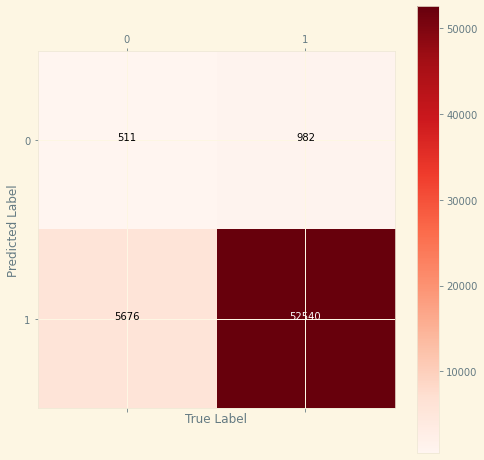

In [72]:
plot_confusion_matrix(xgb_test_result2)

Compared with the model1, model2's AUC has decreased a lot but its recall rate for the 0 label has increased.

### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

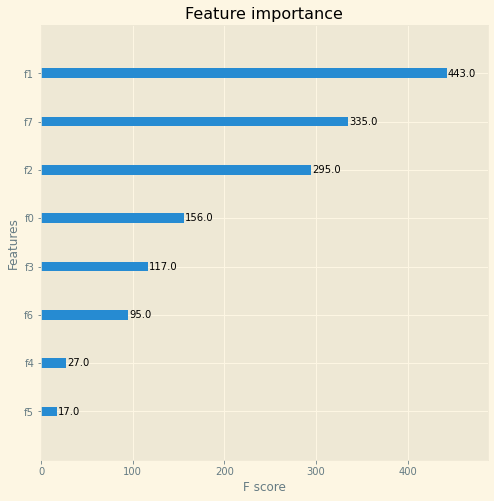

In [73]:
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(model_list2[0],ax=ax)

## Version3

We try to use deep learning model to predict

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import xgboost as xgb
from collections import Counter
from sklearn.metrics import confusion_matrix
import warnings 
import torch
import torch.nn as nn

from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.dataloaders import DataLoaderImbalanced, DataLoaderDefault
from pytorch_widedeep.models import Wide, TabMlp, WideDeep
from pytorch_widedeep.metrics import Accuracy, F1Score, Precision, Recall
from pytorch_widedeep.datasets import load_adult
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F


warnings.filterwarnings('ignore')


/home/szxie/anaconda3/envs/nerftorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data():
    df_train = pd.read_csv(f'./data/training.csv',index_col='id')
    df_test = pd.read_csv(f'./data/test.csv',index_col='id')

    return df_train, df_test

For neural network, we need to fill NA and standardized

### Fill NA and standardization

In [3]:
df_train_val, df_test = load_data()
features =[ 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8']
label = 'event'

scaler = StandardScaler()

for ds in [df_train_val, df_test]:
    tmp = ds.isna().sum()
    for fe in features:
        print(fe)
        set_values = ds[fe].unique()
        na_value = ds[fe].min() - ds[fe].max() # out of distribution value
        ds[fe].fillna(value=na_value, inplace=True)
        # df_train_val.iloc[fe][0:-1] = scaler.fit_transform(df_train_val[fe][0:-1].to_numpy())
        print(ds[fe].min())
        print(ds[fe].max())
        print(tmp[fe], len(ds[fe]) - tmp[fe], len(set_values))


# 
# df_train_val.iloc[:,0:-1] = scaler.fit_transform(df_train_val.iloc[:,0:-1].to_numpy())
# df_test.iloc[:,0:-1] = scaler.fit_transform(df_test.iloc[:,0:-1].to_numpy())

var1
-120.0
121.0
105800 133036 76
var2
-2817427941.438
2817427941.438
121800 117036 93826
var3
-10175.48156420513
10175.48156420513
192199 46637 46116
var4
-12.0
13.0
160649 78187 14
var5
-334283.5571428572
334283.5571428572
230549 8287 8176
var6
-167427.56397849464
164300.40000000002
232897 5939 5926
var7
-22.0
24.0
211294 27542 24
var8
-94.25000000000001
118.66666666666669
137689 101147 5720
var1
-110.0
111.0
26290 33419 62
var2
-1590072360.074
1590072360.074
30310 29399 26616
var3
-8615.982449561667
8615.982449561667
48178 11531 11406
var4
-12.0
13.0
40351 19358 14
var5
-116654.45
116654.45
57604 2105 2085
var6
-19876.064142671574
19484.277852348994
58187 1522 1523
var7
-22.0
24.0
52886 6823 24
var8
-82.91666666666669
107.41666666666669
34458 25251 3240


In [4]:

df_train_val.head()

,event,var1,var2,var3,var4,var5,var6,var7,var8,split
id,,,,,,,,,,
0,1,-120.0,-2.817428e+09,-10175.481564,-12.0,-334283.557143,-167427.563978,-22.0,-94.25,dev
1,1,-120.0,-2.817428e+09,-10175.481564,-12.0,-334283.557143,-167427.563978,-22.0,-94.25,dev
2,1,-120.0,-2.817428e+09,-10175.481564,-12.0,-334283.557143,-167427.563978,-22.0,-94.25,dev
3,1,1.0,2.096510e+07,-10175.481564,-12.0,-334283.557143,-167427.563978,-22.0,62.75,dev
4,1,-120.0,-2.817428e+09,-10175.481564,-12.0,-334283.557143,-167427.563978,-22.0,-94.25,dev


**cat embed:**
var1, var4, var7

**continual:**
var2, var3, var5, var6, var8

### Loss Function

Use this loss function to adjust imbalanced sample weight

In [76]:
from torch import Tensor

class CustomBCELoss(nn.Module):
    def __init__(self, class_weight=0.97) -> None:
        super().__init__()
        self.class_weight = class_weight

    def forward(self, input: Tensor, target: Tensor) -> Tensor:

        input = torch.sigmoid(input)
        loss = (1-self.class_weight) * target * torch.log(input) + self.class_weight * (1 - target) * torch.log(1 - input)

        return torch.neg(torch.mean(loss))


NameError: name 'nn' is not defined

### Neural Netwrok and model training

In [6]:
def stats(gts, preds):
    for fn in [accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score]:
        print(fn.__name__, fn(gts, preds))
    cm = confusion_matrix(gts, preds)

    per_cls_acc = cm.astype(
            'float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-7)

    # 可视化混淆矩阵
    fig = plt.figure(figsize=(4, 4))
    sns.heatmap(per_cls_acc, annot=True, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [7]:
wide_cols = [
    "var1",
    "var2",
    "var8",
    "var4"
]
crossed_cols = [("var2", "var8"), ("var1", "var4")]

cat_embed_cols = [
    "var1",
    "var4",
]
continuous_cols = ["var2", "var3", "var8"]

target = "event"
target = df_train_val[target].values

# prepare the data
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_wide = wide_preprocessor.fit_transform(df_train_val)

tab_preprocessor = TabPreprocessor(
    cat_embed_cols=cat_embed_cols, continuous_cols=continuous_cols  # type: ignore[arg-type]
)
X_tab = tab_preprocessor.fit_transform(df_train_val)

# build the model
wide = Wide(input_dim=np.unique(X_wide).shape[0], pred_dim=1)
tab_mlp = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=continuous_cols,
    mlp_hidden_dims=[100],
    mlp_dropout=0.5,
    mlp_activation="leaky_relu",
)
model = WideDeep(wide=wide, deeptabular=tab_mlp)

predict: 100%|██████████| 234/234 [00:05<00:00, 44.17it/s] 


0 class weights: {ratio}
accuracy_score 0.5639685809509454
precision_score 0.9839102583380951
recall_score 0.5619760890476845
f1_score 0.7153618244831469
average_precision_score 0.9800053347392947
roc_auc_score 0.6018185870556573


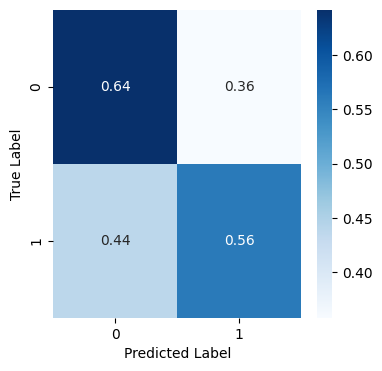

In [17]:
# train and validate
ratio = 0.97 # 0 class weights 0.97, 1 class weights 0.03
trainer = Trainer(
    model, 
    objective="binary", 
    # custom_loss_function=weighted_binary_cross_entropy,
    custom_loss_function=CustomBCELoss(ratio),
    optimizers=torch.optim.AdamW(model.parameters(), lr=0.002),
    custom_dataloader=DataLoaderImbalanced,
    metrics=[Accuracy, F1Score, Precision, Recall]
)

# binary lr=0.05

trainer.fit(
    X_wide=X_wide,
    X_tab=X_tab,
    target=target,
    n_epochs=15,
    batch_size=256,
    val_split=0.2
)

# predict on test
X_wide_te = wide_preprocessor.transform(df_test)
X_tab_te = tab_preprocessor.transform(df_test)
gts = df_test[label].values

preds = trainer.predict(X_wide=X_wide_te, X_tab=X_tab_te)

print('0 class weights: {ratio}')
stats(gts, preds)

torch.save(model.state_dict(), f"model_weights/wd_custom{ratio}_model.pt")

Model3 has balance AUC and 0 label recall rate, which may have better performance